In [4]:
!pip install catboost --quiet
!pip install optuna --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.9 MB/s eta 0:00:00


In [84]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc
from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [51]:
dr = 'https://raw.githubusercontent.com/AkemiRiemann/Enzyme/main/'
train = pd.read_csv(dr+'train.csv')
test = pd.read_csv(dr+'test.csv')
sub = pd.read_csv(dr+'sample_submission.csv')

In [52]:
train.drop('id',inplace=True,axis=1)
test.drop('id',inplace=True,axis=1)
#train = train.drop(train[train['FpDensityMorgan1'] < -100].index)
#train = train.drop(train[train['FpDensityMorgan2'] < -100].index)
#train = train.drop(train[train['FpDensityMorgan3'] < -100].index)

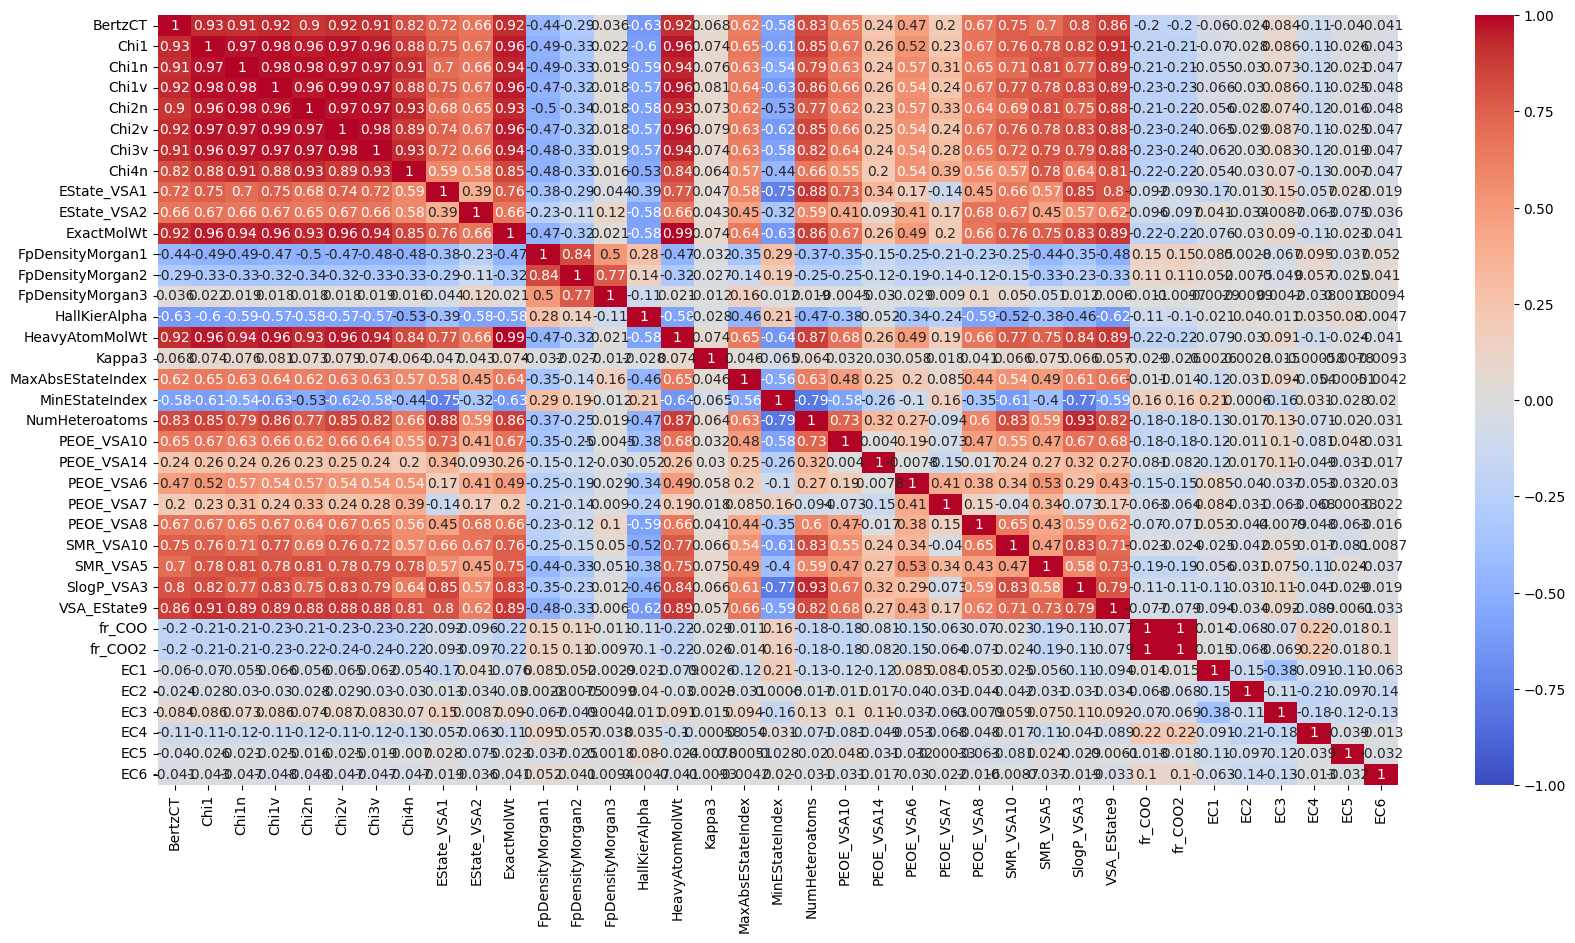

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

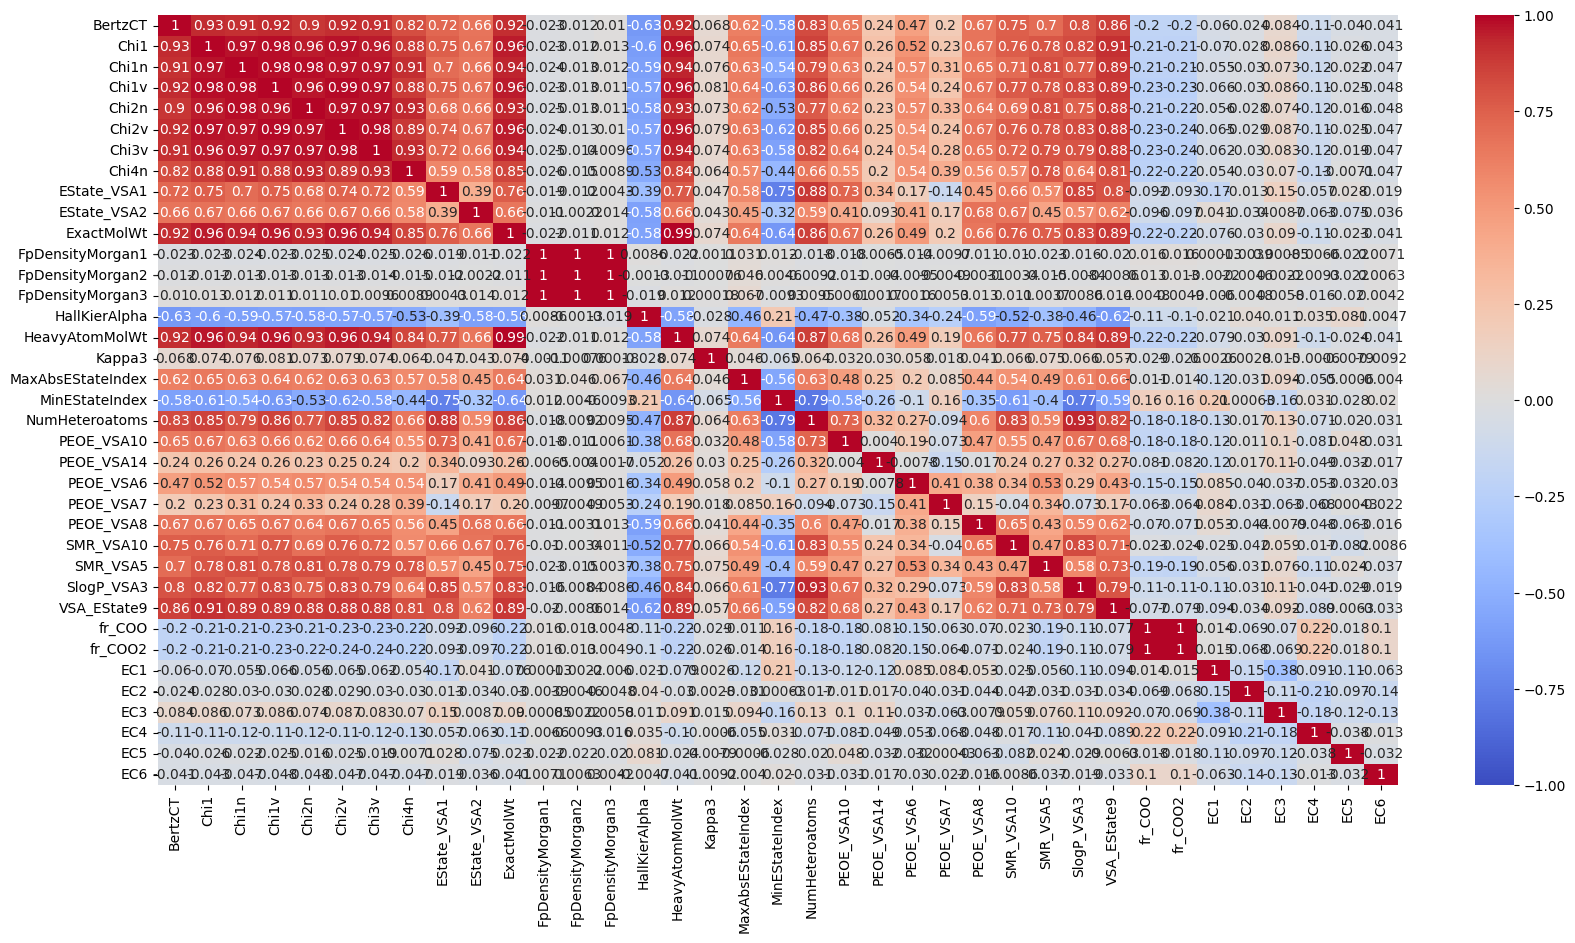

In [54]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm')
plt.show()

In [59]:
train_x, test_x, train_y, test_y = train_test_split(train[test.columns], train['EC1'], test_size=0.25)
xgb.set_config(verbosity=0)

def objective(trial):
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 7500, 12000, step=100),
        "max_depth":trial.suggest_int("max_depth", 4, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 7, 8),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.),
        "gamma": trial.suggest_float("gamma", 0.7, 1.0, step=0.1),
        "booster": "gbtree",
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }
    """
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    """
    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    print(preds)
    pred_labels = np.rint(preds)
    accuracy = roc_auc_score(test_y, preds)
    return accuracy

In [60]:
study_xgb = optuna.create_study(direction = 'maximize')
study_xgb.optimize(objective, n_trials=500)

[I 2023-07-07 06:09:51,071] A new study created in memory with name: no-name-50ac7d64-13d4-4724-b4a7-d4b311e0e039


[0]	validation-auc:0.68239
[1]	validation-auc:0.69111
[2]	validation-auc:0.68909
[3]	validation-auc:0.68814
[4]	validation-auc:0.69053
[5]	validation-auc:0.69322
[6]	validation-auc:0.69517
[7]	validation-auc:0.69574
[8]	validation-auc:0.69519
[9]	validation-auc:0.69422


[I 2023-07-07 06:09:55,009] Trial 0 finished with value: 0.6942222150096152 and parameters: {'n_estimators': 10200, 'max_depth': 17, 'min_child_weight': 7, 'learning_rate': 0.0001532822148601155, 'subsample': 0.9554339026046255, 'colsample_bytree': 0.3294674951625002, 'reg_alpha': 9.080545126058196, 'reg_lambda': 3.124113451215415, 'gamma': 1.0, 'lambda': 3.1848211694880944e-07, 'alpha': 0.006147518472733153}. Best is trial 0 with value: 0.6942222150096152.


[0.5003647  0.50046897 0.49991128 ... 0.5004309  0.50044453 0.49998325]
[0]	validation-auc:0.68272
[1]	validation-auc:0.69161
[2]	validation-auc:0.69115
[3]	validation-auc:0.69029
[4]	validation-auc:0.69084
[5]	validation-auc:0.69310
[6]	validation-auc:0.69513
[7]	validation-auc:0.69490
[8]	validation-auc:0.69399
[9]	validation-auc:0.69295


[I 2023-07-07 06:09:55,221] Trial 1 finished with value: 0.6929546173757111 and parameters: {'n_estimators': 11400, 'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.0005421351030776473, 'subsample': 0.9466240135207508, 'colsample_bytree': 0.33263739823825744, 'reg_alpha': 9.785979481967642, 'reg_lambda': 7.855315659085495, 'gamma': 1.0, 'lambda': 0.2591970371170303, 'alpha': 0.045297496381974924}. Best is trial 0 with value: 0.6942222150096152.


[0.5012339  0.5015994  0.49974075 ... 0.5014598  0.5015994  0.49999213]
[0]	validation-auc:0.67669
[1]	validation-auc:0.68646
[2]	validation-auc:0.68966
[3]	validation-auc:0.68980
[4]	validation-auc:0.69216
[5]	validation-auc:0.69270
[6]	validation-auc:0.69299
[7]	validation-auc:0.69405
[8]	validation-auc:0.69486
[9]	validation-auc:0.69503
[0.53347915 0.54276407 0.49743697 ... 0.5381476  0.5407597  0.48684183]

[I 2023-07-07 06:09:55,641] Trial 2 finished with value: 0.6950336332876235 and parameters: {'n_estimators': 8500, 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.014481825188847337, 'subsample': 0.8154586696165423, 'colsample_bytree': 0.8070130568041315, 'reg_alpha': 6.271895214207533, 'reg_lambda': 2.713677970949999, 'gamma': 0.8999999999999999, 'lambda': 0.0003418609953962977, 'alpha': 1.7503312519237455e-06}. Best is trial 2 with value: 0.6950336332876235.



[0]	validation-auc:0.67596
[1]	validation-auc:0.68861
[2]	validation-auc:0.69118
[3]	validation-auc:0.69183
[4]	validation-auc:0.69294
[5]	validation-auc:0.69347
[6]	validation-auc:0.69287
[7]	validation-auc:0.69359
[8]	validation-auc:0.69329
[9]	validation-auc:0.69374


[I 2023-07-07 06:09:56,050] Trial 3 finished with value: 0.6937439650765573 and parameters: {'n_estimators': 8500, 'max_depth': 19, 'min_child_weight': 7, 'learning_rate': 0.003816841307087056, 'subsample': 0.9187064408224126, 'colsample_bytree': 0.7838011001271504, 'reg_alpha': 9.778376772778143, 'reg_lambda': 6.0207857977327555, 'gamma': 0.8999999999999999, 'lambda': 7.215610616737943e-08, 'alpha': 0.26017925412514803}. Best is trial 2 with value: 0.6950336332876235.


[0.5082729  0.51160055 0.49917322 ... 0.51083815 0.51160055 0.49970526]
[0]	validation-auc:0.67954
[1]	validation-auc:0.68504
[2]	validation-auc:0.68961
[3]	validation-auc:0.69276
[4]	validation-auc:0.69409
[5]	validation-auc:0.69468
[6]	validation-auc:0.69538
[7]	validation-auc:0.69595
[8]	validation-auc:0.69630
[9]	validation-auc:0.69632


[I 2023-07-07 06:09:56,425] Trial 4 finished with value: 0.6963218409457892 and parameters: {'n_estimators': 11400, 'max_depth': 14, 'min_child_weight': 8, 'learning_rate': 0.00032142659951737366, 'subsample': 0.7989999049736531, 'colsample_bytree': 0.7030888436269476, 'reg_alpha': 4.105072097516053, 'reg_lambda': 2.8798552886144506, 'gamma': 0.7, 'lambda': 3.375169015242064e-08, 'alpha': 1.092732032483835e-06}. Best is trial 4 with value: 0.6963218409457892.


[0.5007794  0.50101745 0.4999531  ... 0.50089264 0.5009679  0.49991104]


[I 2023-07-07 06:09:56,530] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.67063


[I 2023-07-07 06:09:56,597] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68023
[1]	validation-auc:0.68400


[I 2023-07-07 06:09:56,749] Trial 7 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68303
[1]	validation-auc:0.69013
[2]	validation-auc:0.68891
[3]	validation-auc:0.69038
[4]	validation-auc:0.69047


[I 2023-07-07 06:09:56,905] Trial 8 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.68020
[1]	validation-auc:0.68484


[I 2023-07-07 06:09:56,990] Trial 9 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68087
[1]	validation-auc:0.68354


[I 2023-07-07 06:09:57,147] Trial 10 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68630
[1]	validation-auc:0.69050
[2]	validation-auc:0.68784
[3]	validation-auc:0.68617
[4]	validation-auc:0.69159


[I 2023-07-07 06:09:57,310] Trial 11 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.67899


[I 2023-07-07 06:09:57,461] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68036
[1]	validation-auc:0.69135
[2]	validation-auc:0.69437
[3]	validation-auc:0.69310
[4]	validation-auc:0.69415
[5]	validation-auc:0.69478
[6]	validation-auc:0.69642
[7]	validation-auc:0.69900
[8]	validation-auc:0.69851
[9]	validation-auc:0.69845


[I 2023-07-07 06:09:57,874] Trial 13 finished with value: 0.6984477568341705 and parameters: {'n_estimators': 12000, 'max_depth': 7, 'min_child_weight': 8, 'learning_rate': 0.0014767404225964362, 'subsample': 0.8427915766570391, 'colsample_bytree': 0.8234305008965304, 'reg_alpha': 4.071775467734418, 'reg_lambda': 1.23209819603723, 'gamma': 0.7999999999999999, 'lambda': 5.121781149815036e-06, 'alpha': 0.00039641462750617353}. Best is trial 13 with value: 0.6984477568341705.


[0.50346416 0.50462776 0.4997499  ... 0.5037856  0.50470567 0.49931797]
[0]	validation-auc:0.68204
[1]	validation-auc:0.69370
[2]	validation-auc:0.69604
[3]	validation-auc:0.69527
[4]	validation-auc:0.69694
[5]	validation-auc:0.69791
[6]	validation-auc:0.69792
[7]	validation-auc:0.69815
[8]	validation-auc:0.69821
[9]	validation-auc:0.69921


[I 2023-07-07 06:09:58,162] Trial 14 finished with value: 0.6992125997030209 and parameters: {'n_estimators': 11800, 'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.0010026326762596074, 'subsample': 0.8495204181830801, 'colsample_bytree': 0.6307332406043676, 'reg_alpha': 4.188112483739338, 'reg_lambda': 1.059522732020851, 'gamma': 0.7, 'lambda': 4.928368831515502e-06, 'alpha': 0.0005330454864694586}. Best is trial 14 with value: 0.6992125997030209.


[0.5024123  0.50311077 0.4996118  ... 0.50277954 0.50313836 0.49982613]
[0]	validation-auc:0.68496
[1]	validation-auc:0.69542
[2]	validation-auc:0.69727
[3]	validation-auc:0.69607
[4]	validation-auc:0.69658
[5]	validation-auc:0.69803
[6]	validation-auc:0.69799
[7]	validation-auc:0.69799
[8]	validation-auc:0.69800
[9]	validation-auc:0.69874


[I 2023-07-07 06:09:58,441] Trial 15 finished with value: 0.6987361348901746 and parameters: {'n_estimators': 10700, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0013890192787984431, 'subsample': 0.8568064760701642, 'colsample_bytree': 0.5881817600682913, 'reg_alpha': 4.4311607829197985, 'reg_lambda': 0.13880210010773197, 'gamma': 0.7999999999999999, 'lambda': 2.4613847139379803e-06, 'alpha': 0.0006847904065174057}. Best is trial 14 with value: 0.6992125997030209.


[0.50355905 0.50443184 0.4998578  ... 0.5040464  0.50411165 0.4998822 ]
[0]	validation-auc:0.68793
[1]	validation-auc:0.69489
[2]	validation-auc:0.69406
[3]	validation-auc:0.69437
[4]	validation-auc:0.69497
[5]	validation-auc:0.69678
[6]	validation-auc:0.69785
[7]	validation-auc:0.69705
[8]	validation-auc:0.69750
[9]	validation-auc:0.69799


[I 2023-07-07 06:09:58,718] Trial 16 finished with value: 0.697990441492685 and parameters: {'n_estimators': 10600, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0012401467428307664, 'subsample': 0.8672313704412146, 'colsample_bytree': 0.5782596131714609, 'reg_alpha': 2.2721929075457084, 'reg_lambda': 0.0851008382640508, 'gamma': 0.7, 'lambda': 2.0482869662816447e-06, 'alpha': 0.0003965507806603588}. Best is trial 14 with value: 0.6992125997030209.


[0.5027836  0.5040741  0.49974763 ... 0.5036921  0.5037724  0.49991062]
[0]	validation-auc:0.68784
[1]	validation-auc:0.69434
[2]	validation-auc:0.69541
[3]	validation-auc:0.69641
[4]	validation-auc:0.69632
[5]	validation-auc:0.69808
[6]	validation-auc:0.69822
[7]	validation-auc:0.69886
[8]	validation-auc:0.69879
[9]	validation-auc:0.69889
[0.50309503 0.50389725 0.49966726 ... 0.5036722  0.50365084 0.5003364 ]


[I 2023-07-07 06:09:59,039] Trial 17 finished with value: 0.6988873832571952 and parameters: {'n_estimators': 11900, 'max_depth': 6, 'min_child_weight': 8, 'learning_rate': 0.0012241796287125576, 'subsample': 0.9772668028848797, 'colsample_bytree': 0.5672653090295935, 'reg_alpha': 4.658786352886956, 'reg_lambda': 1.4440960808184062, 'gamma': 0.7999999999999999, 'lambda': 1.9461315887882616e-05, 'alpha': 0.001607523167908384}. Best is trial 14 with value: 0.6992125997030209.


[0]	validation-auc:0.68156


[I 2023-07-07 06:09:59,177] Trial 18 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68363
[1]	validation-auc:0.69306
[2]	validation-auc:0.69435
[3]	validation-auc:0.69678
[4]	validation-auc:0.69694
[5]	validation-auc:0.69565
[6]	validation-auc:0.69669
[7]	validation-auc:0.69663
[8]	validation-auc:0.69659
[9]	validation-auc:0.69667


[I 2023-07-07 06:09:59,559] Trial 19 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.68380
[1]	validation-auc:0.68929


[I 2023-07-07 06:09:59,726] Trial 20 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68284
[1]	validation-auc:0.69426
[2]	validation-auc:0.69652
[3]	validation-auc:0.69591
[4]	validation-auc:0.69711
[5]	validation-auc:0.69779
[6]	validation-auc:0.69780
[7]	validation-auc:0.69812
[8]	validation-auc:0.69825
[9]	validation-auc:0.69871


[I 2023-07-07 06:10:00,041] Trial 21 finished with value: 0.6987119546254899 and parameters: {'n_estimators': 11800, 'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.0008584215335672898, 'subsample': 0.857249915745504, 'colsample_bytree': 0.6195633906393415, 'reg_alpha': 4.625665911364813, 'reg_lambda': 0.7801635047497306, 'gamma': 0.7999999999999999, 'lambda': 8.103550775096565e-07, 'alpha': 0.0003329711680736698}. Best is trial 14 with value: 0.6992125997030209.


[0.50205386 0.502707   0.4996843  ... 0.5023895  0.50262445 0.49995607]
[0]	validation-auc:0.68945
[1]	validation-auc:0.69244
[2]	validation-auc:0.69514
[3]	validation-auc:0.69606
[4]	validation-auc:0.69763
[5]	validation-auc:0.69920
[6]	validation-auc:0.69994
[7]	validation-auc:0.69933
[8]	validation-auc:0.70043
[9]	validation-auc:0.70034


[I 2023-07-07 06:10:00,320] Trial 22 finished with value: 0.7003394974075187 and parameters: {'n_estimators': 10800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0023170174482408834, 'subsample': 0.9405221441594936, 'colsample_bytree': 0.5797372884188492, 'reg_alpha': 3.7647742261504202, 'reg_lambda': 1.8801014782277081, 'gamma': 0.7999999999999999, 'lambda': 1.2167345660951223e-05, 'alpha': 0.0016841596876368096}. Best is trial 22 with value: 0.7003394974075187.


[0.5058408  0.5072494  0.5003594  ... 0.50665265 0.5069131  0.49984998]
[0]	validation-auc:0.68363
[1]	validation-auc:0.69378
[2]	validation-auc:0.69760
[3]	validation-auc:0.69585
[4]	validation-auc:0.69480
[5]	validation-auc:0.69752
[6]	validation-auc:0.69876
[7]	validation-auc:0.69936
[8]	validation-auc:0.69952
[9]	validation-auc:0.69882


[I 2023-07-07 06:10:00,632] Trial 23 finished with value: 0.6988213338093654 and parameters: {'n_estimators': 11700, 'max_depth': 6, 'min_child_weight': 8, 'learning_rate': 0.0021437285068218494, 'subsample': 0.9629620884599455, 'colsample_bytree': 0.5315634715962324, 'reg_alpha': 3.7186596958199787, 'reg_lambda': 2.0779482304989667, 'gamma': 0.7999999999999999, 'lambda': 1.6820312965662597e-05, 'alpha': 0.005261311652450163}. Best is trial 22 with value: 0.7003394974075187.


[0.50518274 0.506587   0.49922243 ... 0.50647557 0.50635105 0.50023913]
[0]	validation-auc:0.68027


[I 2023-07-07 06:10:00,769] Trial 24 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68274
[1]	validation-auc:0.68990


[I 2023-07-07 06:10:00,898] Trial 25 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68582
[1]	validation-auc:0.69282
[2]	validation-auc:0.69545
[3]	validation-auc:0.69513
[4]	validation-auc:0.69900
[5]	validation-auc:0.69888
[6]	validation-auc:0.69859
[7]	validation-auc:0.69842
[8]	validation-auc:0.69912
[9]	validation-auc:0.69901


[I 2023-07-07 06:10:01,188] Trial 26 finished with value: 0.6990089337152409 and parameters: {'n_estimators': 10900, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.002129725863483322, 'subsample': 0.9306712011262881, 'colsample_bytree': 0.7165636635441226, 'reg_alpha': 3.4209409796085994, 'reg_lambda': 3.565718061030895, 'gamma': 0.7999999999999999, 'lambda': 6.476838538894203e-05, 'alpha': 0.0010252333107631031}. Best is trial 22 with value: 0.7003394974075187.


[0.50429755 0.50673527 0.50055987 ... 0.50620633 0.5065944  0.49988666]
[0]	validation-auc:0.68582
[1]	validation-auc:0.69288
[2]	validation-auc:0.69544
[3]	validation-auc:0.69554
[4]	validation-auc:0.69915
[5]	validation-auc:0.69894
[6]	validation-auc:0.69874
[7]	validation-auc:0.69853
[8]	validation-auc:0.69924
[9]	validation-auc:0.69909


[I 2023-07-07 06:10:01,463] Trial 27 finished with value: 0.6990861807353073 and parameters: {'n_estimators': 9400, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0023537817760752935, 'subsample': 0.9305019120460751, 'colsample_bytree': 0.7257324886963296, 'reg_alpha': 3.4005658724097314, 'reg_lambda': 3.426488679109144, 'gamma': 0.7, 'lambda': 5.5175970151150434e-05, 'alpha': 1.651562084008145e-05}. Best is trial 22 with value: 0.7003394974075187.


[0.50474966 0.5074513  0.50061995 ... 0.5068625  0.50729567 0.49987617]
[0]	validation-auc:0.68310


[I 2023-07-07 06:10:01,615] Trial 28 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:01,747] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68853
[1]	validation-auc:0.69392
[2]	validation-auc:0.69628
[3]	validation-auc:0.69593
[4]	validation-auc:0.69610


[I 2023-07-07 06:10:01,976] Trial 30 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68582
[1]	validation-auc:0.69285
[2]	validation-auc:0.69590
[3]	validation-auc:0.69546
[4]	validation-auc:0.69704
[5]	validation-auc:0.69687


[I 2023-07-07 06:10:02,176] Trial 31 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68574


[I 2023-07-07 06:10:02,332] Trial 32 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68464


[I 2023-07-07 06:10:02,480] Trial 33 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:02,602] Trial 34 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68704
[1]	validation-auc:0.69579
[2]	validation-auc:0.69603
[3]	validation-auc:0.69655
[4]	validation-auc:0.69609
[5]	validation-auc:0.69795
[6]	validation-auc:0.69831
[7]	validation-auc:0.69792
[8]	validation-auc:0.69813
[9]	validation-auc:0.69797


[I 2023-07-07 06:10:02,879] Trial 35 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.67475


[I 2023-07-07 06:10:03,028] Trial 36 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68346


[I 2023-07-07 06:10:03,194] Trial 37 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68331
[1]	validation-auc:0.69496
[2]	validation-auc:0.69643
[3]	validation-auc:0.69659
[4]	validation-auc:0.69813
[5]	validation-auc:0.69784
[6]	validation-auc:0.69794
[7]	validation-auc:0.69785
[8]	validation-auc:0.69839
[9]	validation-auc:0.69841


[I 2023-07-07 06:10:03,488] Trial 38 pruned. Trial was pruned at iteration 9.
[I 2023-07-07 06:10:03,614] Trial 39 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68076


[I 2023-07-07 06:10:03,736] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68643
[1]	validation-auc:0.69544
[2]	validation-auc:0.69558
[3]	validation-auc:0.69618
[4]	validation-auc:0.69711
[5]	validation-auc:0.69814
[6]	validation-auc:0.69863
[7]	validation-auc:0.69929
[8]	validation-auc:0.69940
[9]	validation-auc:0.70018


[I 2023-07-07 06:10:04,010] Trial 41 finished with value: 0.7001798102904067 and parameters: {'n_estimators': 11900, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0009920072562235322, 'subsample': 0.9737449462687532, 'colsample_bytree': 0.5597163670805941, 'reg_alpha': 4.651170432834118, 'reg_lambda': 1.9699192555297016, 'gamma': 0.7999999999999999, 'lambda': 2.4347177324543642e-05, 'alpha': 0.0011376732702959556}. Best is trial 22 with value: 0.7003394974075187.


[0.502609   0.5030578  0.49974978 ... 0.5028502  0.5029871  0.5001518 ]
[0]	validation-auc:0.68614
[1]	validation-auc:0.69521
[2]	validation-auc:0.69868
[3]	validation-auc:0.69734
[4]	validation-auc:0.69592
[5]	validation-auc:0.69667
[6]	validation-auc:0.69724
[7]	validation-auc:0.69725
[8]	validation-auc:0.69704


[I 2023-07-07 06:10:04,266] Trial 42 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.68622
[1]	validation-auc:0.69629
[2]	validation-auc:0.69656
[3]	validation-auc:0.69815
[4]	validation-auc:0.69844
[5]	validation-auc:0.70041
[6]	validation-auc:0.70079
[7]	validation-auc:0.70084
[8]	validation-auc:0.70077
[9]	validation-auc:0.70054


[I 2023-07-07 06:10:04,558] Trial 43 finished with value: 0.7005410537077759 and parameters: {'n_estimators': 9900, 'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.001744935802368234, 'subsample': 0.9478004738918984, 'colsample_bytree': 0.5566280386526303, 'reg_alpha': 4.631598300396074, 'reg_lambda': 1.871684283864816, 'gamma': 0.7999999999999999, 'lambda': 6.474129248517375e-06, 'alpha': 0.0006946672829030388}. Best is trial 43 with value: 0.7005410537077759.


[0.5044452  0.50553024 0.4995122  ... 0.5051699  0.5050179  0.49973473]


[I 2023-07-07 06:10:04,690] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:04,808] Trial 45 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68620
[1]	validation-auc:0.69255


[I 2023-07-07 06:10:04,974] Trial 46 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68457


[I 2023-07-07 06:10:05,207] Trial 47 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:05,663] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68656
[1]	validation-auc:0.69357
[2]	validation-auc:0.69497


[I 2023-07-07 06:10:07,037] Trial 49 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.68346


[I 2023-07-07 06:10:07,193] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68778
[1]	validation-auc:0.69348
[2]	validation-auc:0.69655
[3]	validation-auc:0.69717
[4]	validation-auc:0.70095
[5]	validation-auc:0.70074
[6]	validation-auc:0.70077
[7]	validation-auc:0.70024
[8]	validation-auc:0.70019
[9]	validation-auc:0.70076


[I 2023-07-07 06:10:07,468] Trial 51 finished with value: 0.700757702388004 and parameters: {'n_estimators': 10800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0025245589224068264, 'subsample': 0.927613708196215, 'colsample_bytree': 0.6330616006571401, 'reg_alpha': 3.360858311039637, 'reg_lambda': 3.054587045670674, 'gamma': 0.7999999999999999, 'lambda': 2.48760978955674e-05, 'alpha': 0.0013976309583333853}. Best is trial 51 with value: 0.700757702388004.


[0.505816   0.5079598  0.5003207  ... 0.50732243 0.5077703  0.50019276]
[0]	validation-auc:0.68616
[1]	validation-auc:0.69683
[2]	validation-auc:0.69899
[3]	validation-auc:0.69867
[4]	validation-auc:0.69634
[5]	validation-auc:0.69702
[6]	validation-auc:0.69733
[7]	validation-auc:0.69703
[8]	validation-auc:0.69709
[9]	validation-auc:0.69734


[I 2023-07-07 06:10:07,773] Trial 52 finished with value: 0.6973354646586769 and parameters: {'n_estimators': 10700, 'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.0028646228501626914, 'subsample': 0.9600491889652387, 'colsample_bytree': 0.6373795661360305, 'reg_alpha': 2.889859191533722, 'reg_lambda': 3.06508029731595, 'gamma': 0.7999999999999999, 'lambda': 1.945053088699741e-05, 'alpha': 0.0012223647318851637}. Best is trial 51 with value: 0.700757702388004.


[0.5069305  0.5090304  0.49917114 ... 0.50864184 0.5090304  0.500446  ]
[0]	validation-auc:0.68703
[1]	validation-auc:0.69601
[2]	validation-auc:0.69599
[3]	validation-auc:0.69640
[4]	validation-auc:0.69569


[I 2023-07-07 06:10:08,012] Trial 53 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68284


[I 2023-07-07 06:10:08,137] Trial 54 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68794
[1]	validation-auc:0.69514
[2]	validation-auc:0.69608
[3]	validation-auc:0.69695
[4]	validation-auc:0.69738
[5]	validation-auc:0.69894
[6]	validation-auc:0.69952
[7]	validation-auc:0.69946
[8]	validation-auc:0.69930
[9]	validation-auc:0.69978


[I 2023-07-07 06:10:08,417] Trial 55 finished with value: 0.6997833513197718 and parameters: {'n_estimators': 8700, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.001171667879144709, 'subsample': 0.9371058634989231, 'colsample_bytree': 0.6125293409328164, 'reg_alpha': 5.186125999567791, 'reg_lambda': 1.4582800823980222, 'gamma': 0.7999999999999999, 'lambda': 3.4413091724039636e-05, 'alpha': 0.0015014368888467038}. Best is trial 51 with value: 0.700757702388004.


[0.5029595  0.5036128  0.49998498 ... 0.50336325 0.5035234  0.49997354]
[0]	validation-auc:0.68640
[1]	validation-auc:0.69449
[2]	validation-auc:0.69601
[3]	validation-auc:0.69451
[4]	validation-auc:0.69433


[I 2023-07-07 06:10:08,626] Trial 56 pruned. Trial was pruned at iteration 4.
[I 2023-07-07 06:10:08,743] Trial 57 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68686
[1]	validation-auc:0.69190


[I 2023-07-07 06:10:08,890] Trial 58 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68654
[1]	validation-auc:0.69429
[2]	validation-auc:0.69504


[I 2023-07-07 06:10:09,081] Trial 59 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.68333


[I 2023-07-07 06:10:09,213] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68773
[1]	validation-auc:0.69335


[I 2023-07-07 06:10:09,366] Trial 61 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68944
[1]	validation-auc:0.69836
[2]	validation-auc:0.69919
[3]	validation-auc:0.69899
[4]	validation-auc:0.69739
[5]	validation-auc:0.69791
[6]	validation-auc:0.69847
[7]	validation-auc:0.69816
[8]	validation-auc:0.69804
[9]	validation-auc:0.69958


[I 2023-07-07 06:10:09,638] Trial 62 finished with value: 0.6995779002117801 and parameters: {'n_estimators': 9600, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.002060013190197675, 'subsample': 0.9711593784951061, 'colsample_bytree': 0.5867663519725433, 'reg_alpha': 3.6520467427107706, 'reg_lambda': 0.9643655046805603, 'gamma': 0.7999999999999999, 'lambda': 1.2546956417660503e-05, 'alpha': 0.0003821219765055811}. Best is trial 51 with value: 0.700757702388004.


[0.5051411  0.5065699  0.49973866 ... 0.5059449  0.50630176 0.5001034 ]
[0]	validation-auc:0.68134


[I 2023-07-07 06:10:09,773] Trial 63 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68773
[1]	validation-auc:0.69416
[2]	validation-auc:0.69518


[I 2023-07-07 06:10:09,949] Trial 64 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.68268


[I 2023-07-07 06:10:10,093] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68945
[1]	validation-auc:0.69635
[2]	validation-auc:0.69739
[3]	validation-auc:0.69672
[4]	validation-auc:0.69760
[5]	validation-auc:0.69909
[6]	validation-auc:0.69966
[7]	validation-auc:0.69880
[8]	validation-auc:0.69936
[9]	validation-auc:0.69872


[I 2023-07-07 06:10:10,350] Trial 66 finished with value: 0.698721691644826 and parameters: {'n_estimators': 10900, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0017237806797204905, 'subsample': 0.9409712984804457, 'colsample_bytree': 0.5257064103406394, 'reg_alpha': 4.5782915013760395, 'reg_lambda': 1.4545266350265478, 'gamma': 0.7999999999999999, 'lambda': 2.6636322144948277e-05, 'alpha': 0.001953380775431785}. Best is trial 51 with value: 0.700757702388004.


[0.50378746 0.505391   0.50004214 ... 0.5049149  0.50519496 0.49994767]


[I 2023-07-07 06:10:10,491] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:10,628] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68002


[I 2023-07-07 06:10:10,758] Trial 69 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68778
[1]	validation-auc:0.69400
[2]	validation-auc:0.69679
[3]	validation-auc:0.69724
[4]	validation-auc:0.70072
[5]	validation-auc:0.69958
[6]	validation-auc:0.69944
[7]	validation-auc:0.69911
[8]	validation-auc:0.69880
[9]	validation-auc:0.69862


[I 2023-07-07 06:10:11,074] Trial 70 finished with value: 0.698619452941797 and parameters: {'n_estimators': 10200, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0019593656017194046, 'subsample': 0.9517847961200216, 'colsample_bytree': 0.6848636756563783, 'reg_alpha': 3.606584338147915, 'reg_lambda': 2.4052695345268726, 'gamma': 0.8999999999999999, 'lambda': 1.556436418398107e-05, 'alpha': 0.0009043695062527443}. Best is trial 51 with value: 0.700757702388004.


[0.50414443 0.50622326 0.50007737 ... 0.5057135  0.5060936  0.49994415]
[0]	validation-auc:0.68734
[1]	validation-auc:0.69355


[I 2023-07-07 06:10:11,224] Trial 71 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68773


[I 2023-07-07 06:10:11,364] Trial 72 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:11,487] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68705
[1]	validation-auc:0.69632
[2]	validation-auc:0.69795
[3]	validation-auc:0.69795
[4]	validation-auc:0.69713
[5]	validation-auc:0.69851
[6]	validation-auc:0.69921
[7]	validation-auc:0.69854
[8]	validation-auc:0.69841
[9]	validation-auc:0.69857


[I 2023-07-07 06:10:11,768] Trial 74 finished with value: 0.6985675221720045 and parameters: {'n_estimators': 9400, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.004030787755689564, 'subsample': 0.9130322042555836, 'colsample_bytree': 0.5961027239735665, 'reg_alpha': 3.767807034658657, 'reg_lambda': 0.8901679320338061, 'gamma': 0.7999999999999999, 'lambda': 0.00020371607028478466, 'alpha': 2.5396097874393762e-05}. Best is trial 51 with value: 0.700757702388004.


[0.51000965 0.5125638  0.499938   ... 0.5116413  0.51168436 0.49979445]
[0]	validation-auc:0.68778
[1]	validation-auc:0.69408
[2]	validation-auc:0.69655
[3]	validation-auc:0.69693
[4]	validation-auc:0.69987
[5]	validation-auc:0.70046
[6]	validation-auc:0.70047
[7]	validation-auc:0.70025
[8]	validation-auc:0.69999
[9]	validation-auc:0.70032


[I 2023-07-07 06:10:12,054] Trial 75 finished with value: 0.7003184005322903 and parameters: {'n_estimators': 8900, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0018767257757362535, 'subsample': 0.9498175451741023, 'colsample_bytree': 0.6256222261743709, 'reg_alpha': 4.230027829010733, 'reg_lambda': 1.2506717467099462, 'gamma': 0.7, 'lambda': 4.687966587078685e-05, 'alpha': 0.0012180228906509773}. Best is trial 51 with value: 0.700757702388004.


[0.50454295 0.50595325 0.49974075 ... 0.5054732  0.5058117  0.50016326]


[I 2023-07-07 06:10:12,186] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:12,314] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68492


[I 2023-07-07 06:10:12,458] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68853
[1]	validation-auc:0.69405
[2]	validation-auc:0.69568


[I 2023-07-07 06:10:12,621] Trial 79 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.68662
[1]	validation-auc:0.69501
[2]	validation-auc:0.69765
[3]	validation-auc:0.69708
[4]	validation-auc:0.69584
[5]	validation-auc:0.69765


[I 2023-07-07 06:10:12,842] Trial 80 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68813


[I 2023-07-07 06:10:12,981] Trial 81 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68867
[1]	validation-auc:0.69703
[2]	validation-auc:0.69754
[3]	validation-auc:0.69816
[4]	validation-auc:0.69822
[5]	validation-auc:0.70018
[6]	validation-auc:0.70065
[7]	validation-auc:0.70036
[8]	validation-auc:0.70046
[9]	validation-auc:0.70038
[0.50487494 0.50587654 0.49958467 ... 0.5055034  0.5054433  0.49998248]

[I 2023-07-07 06:10:13,316] Trial 82 finished with value: 0.7003790946194853 and parameters: {'n_estimators': 9600, 'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.0018470575245857052, 'subsample': 0.9508490633265198, 'colsample_bytree': 0.5854471573509046, 'reg_alpha': 3.747789751521168, 'reg_lambda': 2.203995578229181, 'gamma': 0.7, 'lambda': 1.5876381258887608e-05, 'alpha': 0.0001496819658739548}. Best is trial 51 with value: 0.700757702388004.



[0]	validation-auc:0.68903
[1]	validation-auc:0.69703
[2]	validation-auc:0.69730
[3]	validation-auc:0.69832
[4]	validation-auc:0.69836
[5]	validation-auc:0.70053
[6]	validation-auc:0.70162
[7]	validation-auc:0.70103
[8]	validation-auc:0.70100
[9]	validation-auc:0.70081


[I 2023-07-07 06:10:13,611] Trial 83 finished with value: 0.7008068743356513 and parameters: {'n_estimators': 9900, 'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.0008498046972280155, 'subsample': 0.9499845512636141, 'colsample_bytree': 0.5776708849359494, 'reg_alpha': 3.898913356044247, 'reg_lambda': 1.948122337372382, 'gamma': 0.7, 'lambda': 9.875913393276674e-06, 'alpha': 0.00031027299549390736}. Best is trial 83 with value: 0.7008068743356513.


[0.50224406 0.5027109  0.49976033 ... 0.5025392  0.5025102  0.49980524]


[I 2023-07-07 06:10:13,734] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.67525


[I 2023-07-07 06:10:13,885] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:14,008] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68731
[1]	validation-auc:0.69571
[2]	validation-auc:0.69783
[3]	validation-auc:0.69783
[4]	validation-auc:0.69880
[5]	validation-auc:0.69975
[6]	validation-auc:0.70032
[7]	validation-auc:0.69987
[8]	validation-auc:0.70037
[9]	validation-auc:0.70027


[I 2023-07-07 06:10:14,281] Trial 87 finished with value: 0.7002744216616223 and parameters: {'n_estimators': 9500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0029729624130978563, 'subsample': 0.9450796449187556, 'colsample_bytree': 0.5586856479271641, 'reg_alpha': 4.024345949837905, 'reg_lambda': 3.0043586550038484, 'gamma': 0.7999999999999999, 'lambda': 3.4001302807404313e-06, 'alpha': 8.687335089619042e-05}. Best is trial 83 with value: 0.7008068743356513.


[0.5073375  0.50926584 0.49982303 ... 0.50843316 0.50866824 0.5000296 ]
[0]	validation-auc:0.68329


[I 2023-07-07 06:10:14,414] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:14,540] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68259


[I 2023-07-07 06:10:14,678] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68854
[1]	validation-auc:0.69592
[2]	validation-auc:0.69805
[3]	validation-auc:0.69669
[4]	validation-auc:0.69550


[I 2023-07-07 06:10:14,874] Trial 91 pruned. Trial was pruned at iteration 5.
[I 2023-07-07 06:10:14,996] Trial 92 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69056
[1]	validation-auc:0.69651
[2]	validation-auc:0.69892
[3]	validation-auc:0.69902
[4]	validation-auc:0.69934
[5]	validation-auc:0.70033
[6]	validation-auc:0.70024
[7]	validation-auc:0.70017
[8]	validation-auc:0.70052
[9]	validation-auc:0.70027


[I 2023-07-07 06:10:15,287] Trial 93 finished with value: 0.7002677680317427 and parameters: {'n_estimators': 9500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.001466406639044824, 'subsample': 0.9446820661398506, 'colsample_bytree': 0.6075973134828949, 'reg_alpha': 3.445781245557972, 'reg_lambda': 1.8596550038113118, 'gamma': 0.7999999999999999, 'lambda': 1.7008965324716328e-05, 'alpha': 0.00023423890910650191}. Best is trial 83 with value: 0.7008068743356513.


[0.5036541  0.50461763 0.5        ... 0.5042601  0.5043204  0.5000167 ]


[I 2023-07-07 06:10:15,414] Trial 94 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68444


[I 2023-07-07 06:10:15,535] Trial 95 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68995
[1]	validation-auc:0.69635
[2]	validation-auc:0.69694
[3]	validation-auc:0.69801
[4]	validation-auc:0.69803
[5]	validation-auc:0.70045
[6]	validation-auc:0.70072
[7]	validation-auc:0.70043
[8]	validation-auc:0.70154
[9]	validation-auc:0.70180


[I 2023-07-07 06:10:15,837] Trial 96 finished with value: 0.7018015108608336 and parameters: {'n_estimators': 9000, 'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.0015577909914483833, 'subsample': 0.9412890787991762, 'colsample_bytree': 0.5591690690897201, 'reg_alpha': 4.480659337957778, 'reg_lambda': 1.9270518984542222, 'gamma': 0.7999999999999999, 'lambda': 1.8091731219234464e-05, 'alpha': 0.0009621865478473994}. Best is trial 96 with value: 0.7018015108608336.


[0.5040021  0.50494057 0.49979112 ... 0.50461197 0.5045674  0.49993098]
[0]	validation-auc:0.68581


[I 2023-07-07 06:10:15,976] Trial 97 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68181


[I 2023-07-07 06:10:16,106] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:16,239] Trial 99 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68457


[I 2023-07-07 06:10:16,362] Trial 100 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68685
[1]	validation-auc:0.69542


[I 2023-07-07 06:10:16,519] Trial 101 pruned. Trial was pruned at iteration 2.
[I 2023-07-07 06:10:16,640] Trial 102 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68521


[I 2023-07-07 06:10:16,766] Trial 103 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68444


[I 2023-07-07 06:10:16,895] Trial 104 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68606


[I 2023-07-07 06:10:17,030] Trial 105 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68213


[I 2023-07-07 06:10:17,226] Trial 106 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68853


[I 2023-07-07 06:10:18,292] Trial 107 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68701
[1]	validation-auc:0.69135


[I 2023-07-07 06:10:18,762] Trial 108 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:18,995] Trial 109 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68659


[I 2023-07-07 06:10:19,292] Trial 110 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69011
[1]	validation-auc:0.69715
[2]	validation-auc:0.69901
[3]	validation-auc:0.69939
[4]	validation-auc:0.69752
[5]	validation-auc:0.69788
[6]	validation-auc:0.69851
[7]	validation-auc:0.69835
[8]	validation-auc:0.69832
[9]	validation-auc:0.69891


[I 2023-07-07 06:10:19,615] Trial 111 finished with value: 0.6989133486420915 and parameters: {'n_estimators': 9600, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0030242403956468916, 'subsample': 0.9699255917161207, 'colsample_bytree': 0.5765235339721829, 'reg_alpha': 3.62654711067825, 'reg_lambda': 0.9545899438207536, 'gamma': 0.7999999999999999, 'lambda': 2.8958465686442055e-05, 'alpha': 0.0004061114660545401}. Best is trial 96 with value: 0.7018015108608336.


[0.5077734  0.5095001  0.4992079  ... 0.50870115 0.5091047  0.5001323 ]
[0]	validation-auc:0.68991
[1]	validation-auc:0.69640
[2]	validation-auc:0.69905
[3]	validation-auc:0.69846
[4]	validation-auc:0.69812
[5]	validation-auc:0.69801
[6]	validation-auc:0.69851
[7]	validation-auc:0.69814
[8]	validation-auc:0.69828
[9]	validation-auc:0.69921


[I 2023-07-07 06:10:19,907] Trial 112 finished with value: 0.6992147093905436 and parameters: {'n_estimators': 9500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0021947697609094965, 'subsample': 0.9794802740700222, 'colsample_bytree': 0.5952860320047383, 'reg_alpha': 2.9351743689445833, 'reg_lambda': 1.7201941761921202, 'gamma': 0.7999999999999999, 'lambda': 1.0733782423433457e-05, 'alpha': 0.000614523313003236}. Best is trial 96 with value: 0.7018015108608336.


[0.5049741  0.5072165  0.5000891  ... 0.50634205 0.5067498  0.50021017]
[0]	validation-auc:0.68944
[1]	validation-auc:0.69584
[2]	validation-auc:0.69873
[3]	validation-auc:0.69943
[4]	validation-auc:0.69768
[5]	validation-auc:0.69850
[6]	validation-auc:0.69892
[7]	validation-auc:0.69874
[8]	validation-auc:0.69873
[9]	validation-auc:0.69894


[I 2023-07-07 06:10:20,200] Trial 113 finished with value: 0.6989449939549338 and parameters: {'n_estimators': 10600, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0020289417941132797, 'subsample': 0.9646651758043044, 'colsample_bytree': 0.551376922751932, 'reg_alpha': 3.7864149892652015, 'reg_lambda': 1.4413659800311065, 'gamma': 0.7999999999999999, 'lambda': 4.4838056920767206e-05, 'alpha': 0.00011498150556896179}. Best is trial 96 with value: 0.7018015108608336.


[0.5052253  0.50632846 0.49990633 ... 0.5058404  0.50618684 0.4999926 ]
[0]	validation-auc:0.68573


[I 2023-07-07 06:10:20,342] Trial 114 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68351


[I 2023-07-07 06:10:20,482] Trial 115 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:20,609] Trial 116 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68692


[I 2023-07-07 06:10:20,736] Trial 117 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68877
[1]	validation-auc:0.69627
[2]	validation-auc:0.69727
[3]	validation-auc:0.69802
[4]	validation-auc:0.69709
[5]	validation-auc:0.69804


[I 2023-07-07 06:10:20,979] Trial 118 pruned. Trial was pruned at iteration 5.
[I 2023-07-07 06:10:21,120] Trial 119 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68953
[1]	validation-auc:0.69646
[2]	validation-auc:0.69896
[3]	validation-auc:0.69593
[4]	validation-auc:0.69572
[5]	validation-auc:0.69550
[6]	validation-auc:0.69797
[7]	validation-auc:0.69824
[8]	validation-auc:0.69850
[9]	validation-auc:0.69914


[I 2023-07-07 06:10:21,416] Trial 120 finished with value: 0.6991421685964898 and parameters: {'n_estimators': 11500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0030064576233774423, 'subsample': 0.9852952068518258, 'colsample_bytree': 0.5836384737817666, 'reg_alpha': 2.679962348829166, 'reg_lambda': 1.2236963030127488, 'gamma': 0.7, 'lambda': 2.75644063628717e-06, 'alpha': 0.00243603839387521}. Best is trial 96 with value: 0.7018015108608336.


[0.506621   0.5096307  0.5006433  ... 0.50774914 0.5092678  0.5001304 ]
[0]	validation-auc:0.68849
[1]	validation-auc:0.69508
[2]	validation-auc:0.69665
[3]	validation-auc:0.69747
[4]	validation-auc:0.69908
[5]	validation-auc:0.69877
[6]	validation-auc:0.69878
[7]	validation-auc:0.69805
[8]	validation-auc:0.69763
[9]	validation-auc:0.69864


[I 2023-07-07 06:10:21,715] Trial 121 finished with value: 0.6986389269804691 and parameters: {'n_estimators': 9500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.002251945431903094, 'subsample': 0.9749093847221052, 'colsample_bytree': 0.6300908667530283, 'reg_alpha': 2.9879400695156573, 'reg_lambda': 1.8077086465126595, 'gamma': 0.7999999999999999, 'lambda': 1.0273628983701586e-05, 'alpha': 0.0005671766135273104}. Best is trial 96 with value: 0.7018015108608336.


[0.50518703 0.5072876  0.49977228 ... 0.5065757  0.50703514 0.50024015]
[0]	validation-auc:0.68943
[1]	validation-auc:0.69732
[2]	validation-auc:0.69731
[3]	validation-auc:0.69781
[4]	validation-auc:0.69814


[I 2023-07-07 06:10:21,961] Trial 122 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69006
[1]	validation-auc:0.69644
[2]	validation-auc:0.69825
[3]	validation-auc:0.69844
[4]	validation-auc:0.69889
[5]	validation-auc:0.69933
[6]	validation-auc:0.70029
[7]	validation-auc:0.70003
[8]	validation-auc:0.70079
[9]	validation-auc:0.70068


[I 2023-07-07 06:10:22,243] Trial 123 finished with value: 0.7006754245746138 and parameters: {'n_estimators': 9000, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.002372322330049217, 'subsample': 0.947481747420999, 'colsample_bytree': 0.5731473194917609, 'reg_alpha': 2.8361442179637577, 'reg_lambda': 2.006723138979351, 'gamma': 0.7999999999999999, 'lambda': 4.728948111112243e-05, 'alpha': 0.001305146939229493}. Best is trial 96 with value: 0.7018015108608336.


[0.5058966  0.5074906  0.49952695 ... 0.5068658  0.5070146  0.49985233]
[0]	validation-auc:0.68945
[1]	validation-auc:0.69642
[2]	validation-auc:0.69740
[3]	validation-auc:0.69692
[4]	validation-auc:0.69768
[5]	validation-auc:0.69915
[6]	validation-auc:0.69973
[7]	validation-auc:0.69887
[8]	validation-auc:0.69952
[9]	validation-auc:0.69872


[I 2023-07-07 06:10:22,541] Trial 124 finished with value: 0.6987218539284816 and parameters: {'n_estimators': 9000, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0025651430561013074, 'subsample': 0.9409524273139445, 'colsample_bytree': 0.5225666926361562, 'reg_alpha': 4.101214954499185, 'reg_lambda': 2.3692594467419674, 'gamma': 0.7999999999999999, 'lambda': 4.7387550186464014e-05, 'alpha': 0.001299437319672563}. Best is trial 96 with value: 0.7018015108608336.


[0.5056084  0.50798887 0.50006396 ... 0.50662464 0.507698   0.4999268 ]
[0]	validation-auc:0.68581


[I 2023-07-07 06:10:22,682] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:22,803] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:22,930] Trial 127 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:23,065] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:23,196] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:23,325] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68977
[1]	validation-auc:0.69667
[2]	validation-auc:0.69920
[3]	validation-auc:0.69781
[4]	validation-auc:0.69878
[5]	validation-auc:0.69826
[6]	validation-auc:0.69868
[7]	validation-auc:0.69838
[8]	validation-auc:0.70016
[9]	validation-auc:0.70062


[I 2023-07-07 06:10:23,624] Trial 131 finished with value: 0.7006163533239751 and parameters: {'n_estimators': 9500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0023396844296496664, 'subsample': 0.9892313972265289, 'colsample_bytree': 0.5928372939076145, 'reg_alpha': 2.917388338108066, 'reg_lambda': 1.8912982469727246, 'gamma': 0.7999999999999999, 'lambda': 1.0252289947519215e-05, 'alpha': 0.0005834029973303839}. Best is trial 96 with value: 0.7018015108608336.


[0.5054519  0.5076386  0.5004927  ... 0.50636846 0.5072086  0.5003561 ]
[0]	validation-auc:0.68933
[1]	validation-auc:0.69651
[2]	validation-auc:0.69919
[3]	validation-auc:0.69774
[4]	validation-auc:0.69873
[5]	validation-auc:0.69907
[6]	validation-auc:0.69903
[7]	validation-auc:0.69870
[8]	validation-auc:0.69883
[9]	validation-auc:0.69892


[I 2023-07-07 06:10:23,926] Trial 132 finished with value: 0.6989224365268052 and parameters: {'n_estimators': 9600, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0024237767164510997, 'subsample': 0.991330986690381, 'colsample_bytree': 0.5733084574788997, 'reg_alpha': 2.8043944832298675, 'reg_lambda': 2.3936348633100293, 'gamma': 0.7999999999999999, 'lambda': 4.334630380304731e-06, 'alpha': 0.00048216063747083304}. Best is trial 96 with value: 0.7018015108608336.


[0.505839   0.5078722  0.4998066  ... 0.50697494 0.5074266  0.50025827]


[I 2023-07-07 06:10:24,072] Trial 133 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68978
[1]	validation-auc:0.69667
[2]	validation-auc:0.69944
[3]	validation-auc:0.69813
[4]	validation-auc:0.69813
[5]	validation-auc:0.69895
[6]	validation-auc:0.69907
[7]	validation-auc:0.69801
[8]	validation-auc:0.69795
[9]	validation-auc:0.69822


[I 2023-07-07 06:10:24,357] Trial 134 finished with value: 0.6982181254614941 and parameters: {'n_estimators': 9700, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0016808339711811087, 'subsample': 0.9974698470437011, 'colsample_bytree': 0.5361360327406657, 'reg_alpha': 3.4209770135836415, 'reg_lambda': 2.118742162249852, 'gamma': 0.7999999999999999, 'lambda': 1.0197775624443445e-05, 'alpha': 0.001511860224169185}. Best is trial 96 with value: 0.7018015108608336.


[0.50361115 0.50528663 0.49998307 ... 0.5048207  0.5048757  0.50008756]


[I 2023-07-07 06:10:24,507] Trial 135 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68945
[1]	validation-auc:0.69581
[2]	validation-auc:0.69795
[3]	validation-auc:0.69796
[4]	validation-auc:0.69851
[5]	validation-auc:0.70000
[6]	validation-auc:0.70044
[7]	validation-auc:0.70022
[8]	validation-auc:0.70102
[9]	validation-auc:0.70131


[I 2023-07-07 06:10:24,796] Trial 136 finished with value: 0.7013071948458711 and parameters: {'n_estimators': 9100, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0019390456664707457, 'subsample': 0.9410842833409623, 'colsample_bytree': 0.5577098597339655, 'reg_alpha': 4.447372412453312, 'reg_lambda': 0.9839428687986292, 'gamma': 0.7999999999999999, 'lambda': 1.469043759327324e-06, 'alpha': 0.0019320600097465126}. Best is trial 96 with value: 0.7018015108608336.


[0.50489646 0.50607497 0.5000619  ... 0.50558805 0.5057925  0.49998784]
[0]	validation-auc:0.68382


[I 2023-07-07 06:10:24,932] Trial 137 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:25,060] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68444


[I 2023-07-07 06:10:25,204] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68944
[1]	validation-auc:0.69634
[2]	validation-auc:0.69846
[3]	validation-auc:0.69822
[4]	validation-auc:0.69895
[5]	validation-auc:0.70004
[6]	validation-auc:0.70074
[7]	validation-auc:0.70032
[8]	validation-auc:0.70057
[9]	validation-auc:0.70090


[I 2023-07-07 06:10:25,505] Trial 140 finished with value: 0.7009000251539668 and parameters: {'n_estimators': 9100, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.001857430657369383, 'subsample': 0.9547098699766293, 'colsample_bytree': 0.5690134320156751, 'reg_alpha': 4.331849535810162, 'reg_lambda': 1.6703379508689067, 'gamma': 0.7, 'lambda': 8.313449556401843e-06, 'alpha': 0.0011596338582368453}. Best is trial 96 with value: 0.7018015108608336.


[0.5047104  0.5058076  0.49968597 ... 0.50532943 0.505548   0.49976087]
[0]	validation-auc:0.68944
[1]	validation-auc:0.69580
[2]	validation-auc:0.69854
[3]	validation-auc:0.69829
[4]	validation-auc:0.69702


[I 2023-07-07 06:10:25,712] Trial 141 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68945
[1]	validation-auc:0.69640
[2]	validation-auc:0.69740
[3]	validation-auc:0.69675
[4]	validation-auc:0.69764


[I 2023-07-07 06:10:25,908] Trial 142 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.68529


[I 2023-07-07 06:10:26,040] Trial 143 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:26,175] Trial 144 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:26,313] Trial 145 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68614


[I 2023-07-07 06:10:26,447] Trial 146 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68944
[1]	validation-auc:0.69596
[2]	validation-auc:0.69853
[3]	validation-auc:0.69843
[4]	validation-auc:0.69692


[I 2023-07-07 06:10:26,660] Trial 147 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.68612


[I 2023-07-07 06:10:26,796] Trial 148 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:26,930] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68318


[I 2023-07-07 06:10:27,068] Trial 150 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68892
[1]	validation-auc:0.69561
[2]	validation-auc:0.69848
[3]	validation-auc:0.69942
[4]	validation-auc:0.69744
[5]	validation-auc:0.69767
[6]	validation-auc:0.69787
[7]	validation-auc:0.69765
[8]	validation-auc:0.69761
[9]	validation-auc:0.69800


[I 2023-07-07 06:10:27,355] Trial 151 finished with value: 0.6979975819735318 and parameters: {'n_estimators': 9600, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.00192517812460177, 'subsample': 0.9649214998685542, 'colsample_bytree': 0.5984688754763858, 'reg_alpha': 3.708790276817398, 'reg_lambda': 1.0054160341099436, 'gamma': 0.7999999999999999, 'lambda': 1.1968556363736194e-05, 'alpha': 0.00036185247615991783}. Best is trial 96 with value: 0.7018015108608336.


[0.50501543 0.5060041  0.5001094  ... 0.50557923 0.5058708  0.4999944 ]
[0]	validation-auc:0.68854


[I 2023-07-07 06:10:27,514] Trial 152 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68900
[1]	validation-auc:0.69687
[2]	validation-auc:0.69736
[3]	validation-auc:0.69827
[4]	validation-auc:0.69632


[I 2023-07-07 06:10:27,740] Trial 153 pruned. Trial was pruned at iteration 5.
[I 2023-07-07 06:10:27,912] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:28,043] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68614


[I 2023-07-07 06:10:28,176] Trial 156 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:28,319] Trial 157 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:28,452] Trial 158 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68840


[I 2023-07-07 06:10:28,628] Trial 159 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68470


[I 2023-07-07 06:10:28,759] Trial 160 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68991
[1]	validation-auc:0.69623
[2]	validation-auc:0.69897
[3]	validation-auc:0.69856
[4]	validation-auc:0.69746
[5]	validation-auc:0.69782
[6]	validation-auc:0.69786
[7]	validation-auc:0.69775
[8]	validation-auc:0.69806
[9]	validation-auc:0.69878


[I 2023-07-07 06:10:29,052] Trial 161 finished with value: 0.6987825480156766 and parameters: {'n_estimators': 9500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.002355069705100435, 'subsample': 0.9818880645669557, 'colsample_bytree': 0.5958077907983242, 'reg_alpha': 2.8937294976377657, 'reg_lambda': 1.7556914078257577, 'gamma': 0.7999999999999999, 'lambda': 1.1013631228545629e-05, 'alpha': 0.0006061622617198446}. Best is trial 96 with value: 0.7018015108608336.


[0.5055154  0.50773865 0.50036323 ... 0.5067794  0.50726324 0.5002025 ]
[0]	validation-auc:0.68954
[1]	validation-auc:0.69676
[2]	validation-auc:0.69894
[3]	validation-auc:0.69867
[4]	validation-auc:0.69809
[5]	validation-auc:0.69779
[6]	validation-auc:0.69869
[7]	validation-auc:0.69825
[8]	validation-auc:0.69844
[9]	validation-auc:0.69909


[I 2023-07-07 06:10:29,366] Trial 162 finished with value: 0.6990863430189629 and parameters: {'n_estimators': 9500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0033726321926998287, 'subsample': 0.9775716701946217, 'colsample_bytree': 0.5851468074916814, 'reg_alpha': 3.0008138047516666, 'reg_lambda': 1.4784554556916032, 'gamma': 0.7999999999999999, 'lambda': 5.826130868287893e-06, 'alpha': 0.0009164264323048568}. Best is trial 96 with value: 0.7018015108608336.


[0.5076075  0.51104575 0.5001202  ... 0.5097125  0.51032627 0.5003108 ]
[0]	validation-auc:0.68853


[I 2023-07-07 06:10:29,646] Trial 163 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:29,882] Trial 164 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68614


[I 2023-07-07 06:10:30,108] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68945
[1]	validation-auc:0.69640
[2]	validation-auc:0.69846
[3]	validation-auc:0.69833
[4]	validation-auc:0.69699
[5]	validation-auc:0.69853
[6]	validation-auc:0.69875
[7]	validation-auc:0.69847


[I 2023-07-07 06:10:31,128] Trial 166 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.68185


[I 2023-07-07 06:10:31,451] Trial 167 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68291


[I 2023-07-07 06:10:31,698] Trial 168 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:31,916] Trial 169 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68699


[I 2023-07-07 06:10:32,131] Trial 170 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:32,262] Trial 171 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:32,397] Trial 172 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68606


[I 2023-07-07 06:10:32,524] Trial 173 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68318


[I 2023-07-07 06:10:32,681] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68176


[I 2023-07-07 06:10:32,821] Trial 175 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68624


[I 2023-07-07 06:10:32,957] Trial 176 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68483


[I 2023-07-07 06:10:33,094] Trial 177 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68514


[I 2023-07-07 06:10:33,230] Trial 178 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:33,362] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:33,493] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68953
[1]	validation-auc:0.69643
[2]	validation-auc:0.69897
[3]	validation-auc:0.69614
[4]	validation-auc:0.69704
[5]	validation-auc:0.69736
[6]	validation-auc:0.69943
[7]	validation-auc:0.69980
[8]	validation-auc:0.69993
[9]	validation-auc:0.70041


[I 2023-07-07 06:10:33,795] Trial 181 finished with value: 0.7004074942592158 and parameters: {'n_estimators': 12000, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.002897155171931911, 'subsample': 0.985828869225809, 'colsample_bytree': 0.5842643423315753, 'reg_alpha': 2.8076673482934935, 'reg_lambda': 1.226673428913069, 'gamma': 0.7, 'lambda': 2.4918854907562673e-06, 'alpha': 0.0028395375354520647}. Best is trial 96 with value: 0.7018015108608336.


[0.5063934  0.5094252  0.5006182  ... 0.50745606 0.50883794 0.5001242 ]
[0]	validation-auc:0.68967
[1]	validation-auc:0.69650
[2]	validation-auc:0.69886
[3]	validation-auc:0.69815
[4]	validation-auc:0.69737
[5]	validation-auc:0.69715
[6]	validation-auc:0.69895
[7]	validation-auc:0.69857
[8]	validation-auc:0.69887
[9]	validation-auc:0.69950


[I 2023-07-07 06:10:34,122] Trial 182 finished with value: 0.6995035742975146 and parameters: {'n_estimators': 12000, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0029549924358512527, 'subsample': 0.9812621202959493, 'colsample_bytree': 0.5887376215025071, 'reg_alpha': 2.740030561635498, 'reg_lambda': 1.2977756776021931, 'gamma': 0.7, 'lambda': 2.7931463036602257e-06, 'alpha': 0.005259353088556502}. Best is trial 96 with value: 0.7018015108608336.


[0.50658464 0.509632   0.50045675 ... 0.50809646 0.50918525 0.50025576]
[0]	validation-auc:0.68967
[1]	validation-auc:0.69616
[2]	validation-auc:0.69877
[3]	validation-auc:0.69810
[4]	validation-auc:0.69764
[5]	validation-auc:0.69760
[6]	validation-auc:0.69793
[7]	validation-auc:0.69784
[8]	validation-auc:0.69881


[I 2023-07-07 06:10:34,404] Trial 183 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.68977
[1]	validation-auc:0.69646
[2]	validation-auc:0.69887
[3]	validation-auc:0.69891
[4]	validation-auc:0.69960
[5]	validation-auc:0.69944
[6]	validation-auc:0.70008
[7]	validation-auc:0.69942
[8]	validation-auc:0.70007
[9]	validation-auc:0.69995


[I 2023-07-07 06:10:34,715] Trial 184 finished with value: 0.6999451481244067 and parameters: {'n_estimators': 11900, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.003520753935912598, 'subsample': 0.975222435170645, 'colsample_bytree': 0.5374062140227671, 'reg_alpha': 2.209459936262629, 'reg_lambda': 0.8565891629671235, 'gamma': 0.7, 'lambda': 1.4108917660750464e-06, 'alpha': 0.0033211072068113166}. Best is trial 96 with value: 0.7018015108608336.


[0.5071608  0.5109078  0.49937886 ... 0.50819457 0.51078576 0.5000125 ]
[0]	validation-auc:0.68895
[1]	validation-auc:0.69648
[2]	validation-auc:0.69946
[3]	validation-auc:0.69859
[4]	validation-auc:0.69857
[5]	validation-auc:0.69830
[6]	validation-auc:0.69922
[7]	validation-auc:0.69844
[8]	validation-auc:0.69951
[9]	validation-auc:0.69931


[I 2023-07-07 06:10:35,001] Trial 185 finished with value: 0.6993146761223944 and parameters: {'n_estimators': 12000, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.003857105083144452, 'subsample': 0.991072613603931, 'colsample_bytree': 0.5291747106255272, 'reg_alpha': 2.5072082624607646, 'reg_lambda': 0.8684109041351052, 'gamma': 0.7, 'lambda': 9.369424548826226e-07, 'alpha': 0.0060267479350053915}. Best is trial 96 with value: 0.7018015108608336.


[0.5078965  0.51183593 0.49948937 ... 0.50814515 0.5111963  0.50008535]
[0]	validation-auc:0.68970
[1]	validation-auc:0.69684
[2]	validation-auc:0.69996
[3]	validation-auc:0.69803
[4]	validation-auc:0.69765
[5]	validation-auc:0.69843
[6]	validation-auc:0.69932
[7]	validation-auc:0.69890
[8]	validation-auc:0.69897
[9]	validation-auc:0.69870


[I 2023-07-07 06:10:35,304] Trial 186 finished with value: 0.6986986473657306 and parameters: {'n_estimators': 12000, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.002797819878138595, 'subsample': 0.9716878425873514, 'colsample_bytree': 0.5463505737874876, 'reg_alpha': 2.3203536620201333, 'reg_lambda': 1.2747112470831892, 'gamma': 0.7, 'lambda': 6.838936007827743e-07, 'alpha': 0.002806196134851757}. Best is trial 96 with value: 0.7018015108608336.


[0.50581294 0.50865495 0.49894455 ... 0.5070492  0.5081626  0.50025725]


[I 2023-07-07 06:10:35,440] Trial 187 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68467


[I 2023-07-07 06:10:35,574] Trial 188 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68470


[I 2023-07-07 06:10:35,714] Trial 189 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68977
[1]	validation-auc:0.69693
[2]	validation-auc:0.69934
[3]	validation-auc:0.69899
[4]	validation-auc:0.69919
[5]	validation-auc:0.69926
[6]	validation-auc:0.69929
[7]	validation-auc:0.69922
[8]	validation-auc:0.69930
[9]	validation-auc:0.69990


[I 2023-07-07 06:10:36,013] Trial 190 finished with value: 0.6999024675229835 and parameters: {'n_estimators': 11800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0029354685269121243, 'subsample': 0.9882330528972145, 'colsample_bytree': 0.595740690857834, 'reg_alpha': 2.8404970859686753, 'reg_lambda': 2.4298242858356844, 'gamma': 0.7, 'lambda': 6.617572819310901e-07, 'alpha': 0.006384355189754307}. Best is trial 96 with value: 0.7018015108608336.


[0.50730413 0.50936663 0.5004619  ... 0.50844985 0.5088311  0.5004165 ]
[0]	validation-auc:0.68977
[1]	validation-auc:0.69694
[2]	validation-auc:0.69936
[3]	validation-auc:0.69719
[4]	validation-auc:0.69742
[5]	validation-auc:0.69784
[6]	validation-auc:0.69858
[7]	validation-auc:0.69827
[8]	validation-auc:0.69842
[9]	validation-auc:0.69938


[I 2023-07-07 06:10:36,326] Trial 191 finished with value: 0.6993833221087139 and parameters: {'n_estimators': 11800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0031892718756712747, 'subsample': 0.987987391893609, 'colsample_bytree': 0.5941732393709809, 'reg_alpha': 2.8478328114512346, 'reg_lambda': 2.5174894659880906, 'gamma': 0.7, 'lambda': 5.176907909057023e-07, 'alpha': 0.005820085494845943}. Best is trial 96 with value: 0.7018015108608336.


[0.50744045 0.51029617 0.5006737  ... 0.5092616  0.5096853  0.5001353 ]


[I 2023-07-07 06:10:36,475] Trial 192 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68638


[I 2023-07-07 06:10:36,607] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68991
[1]	validation-auc:0.69652
[2]	validation-auc:0.69921
[3]	validation-auc:0.69868
[4]	validation-auc:0.69960
[5]	validation-auc:0.69876
[6]	validation-auc:0.69961
[7]	validation-auc:0.69934
[8]	validation-auc:0.69925
[9]	validation-auc:0.69982


[I 2023-07-07 06:10:36,914] Trial 194 finished with value: 0.6998240845173279 and parameters: {'n_estimators': 11800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0019124382571429808, 'subsample': 0.9788506045395401, 'colsample_bytree': 0.5562425146628595, 'reg_alpha': 2.527758434140303, 'reg_lambda': 2.4025735756764903, 'gamma': 0.7, 'lambda': 8.482323938775597e-07, 'alpha': 0.005033754250142277}. Best is trial 96 with value: 0.7018015108608336.


[0.50466144 0.5061355  0.49986294 ... 0.5055057  0.5057843  0.5001811 ]


[I 2023-07-07 06:10:37,055] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68944
[1]	validation-auc:0.69587


[I 2023-07-07 06:10:37,206] Trial 196 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68875


[I 2023-07-07 06:10:37,342] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68172


[I 2023-07-07 06:10:37,484] Trial 198 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68614


[I 2023-07-07 06:10:37,619] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68529


[I 2023-07-07 06:10:37,765] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68991
[1]	validation-auc:0.69628


[I 2023-07-07 06:10:37,926] Trial 201 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68916
[1]	validation-auc:0.69654
[2]	validation-auc:0.69891
[3]	validation-auc:0.69590
[4]	validation-auc:0.69566
[5]	validation-auc:0.69566
[6]	validation-auc:0.69677


[I 2023-07-07 06:10:38,158] Trial 202 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.68827


[I 2023-07-07 06:10:38,300] Trial 203 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68573


[I 2023-07-07 06:10:38,440] Trial 204 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68924
[1]	validation-auc:0.69515


[I 2023-07-07 06:10:38,592] Trial 205 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68891


[I 2023-07-07 06:10:38,728] Trial 206 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:38,864] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68729


[I 2023-07-07 06:10:39,005] Trial 208 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68481


[I 2023-07-07 06:10:39,155] Trial 209 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68804


[I 2023-07-07 06:10:39,298] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68977
[1]	validation-auc:0.69658
[2]	validation-auc:0.69919
[3]	validation-auc:0.69702
[4]	validation-auc:0.69741
[5]	validation-auc:0.69810
[6]	validation-auc:0.69875
[7]	validation-auc:0.69855
[8]	validation-auc:0.69830
[9]	validation-auc:0.69932


[I 2023-07-07 06:10:39,601] Trial 211 finished with value: 0.6993174349445395 and parameters: {'n_estimators': 11800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0028666960568776794, 'subsample': 0.9848053878071173, 'colsample_bytree': 0.5915229556973981, 'reg_alpha': 2.7279736330709734, 'reg_lambda': 2.5166367186962497, 'gamma': 0.7, 'lambda': 5.506029802379858e-07, 'alpha': 0.004747172741579402}. Best is trial 96 with value: 0.7018015108608336.


[0.5066922  0.5092313  0.5006016  ... 0.50833863 0.50868267 0.50012076]


[I 2023-07-07 06:10:39,743] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68978
[1]	validation-auc:0.69650
[2]	validation-auc:0.69944
[3]	validation-auc:0.69720
[4]	validation-auc:0.69716
[5]	validation-auc:0.69811
[6]	validation-auc:0.69894
[7]	validation-auc:0.69843
[8]	validation-auc:0.69856
[9]	validation-auc:0.69930


[I 2023-07-07 06:10:40,062] Trial 213 finished with value: 0.699295202083722 and parameters: {'n_estimators': 11900, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.004072401426488233, 'subsample': 0.98750647495216, 'colsample_bytree': 0.5699573688157893, 'reg_alpha': 3.2080069286915545, 'reg_lambda': 2.214521627343713, 'gamma': 0.7, 'lambda': 9.348082466566905e-07, 'alpha': 0.006446822861496095}. Best is trial 96 with value: 0.7018015108608336.


[0.5094567  0.5130451  0.5004082  ... 0.5117457  0.51226324 0.50015974]
[0]	validation-auc:0.68991
[1]	validation-auc:0.69649
[2]	validation-auc:0.69901
[3]	validation-auc:0.69860
[4]	validation-auc:0.69959
[5]	validation-auc:0.69872
[6]	validation-auc:0.69936
[7]	validation-auc:0.69915
[8]	validation-auc:0.69902
[9]	validation-auc:0.70010


[I 2023-07-07 06:10:40,371] Trial 214 finished with value: 0.7001045106742074 and parameters: {'n_estimators': 9100, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0018046471432206375, 'subsample': 0.9795128475623583, 'colsample_bytree': 0.5929136075683591, 'reg_alpha': 2.631884595077687, 'reg_lambda': 2.482528069739269, 'gamma': 0.7, 'lambda': 1.7130339051383703e-06, 'alpha': 0.011742758973374056}. Best is trial 96 with value: 0.7018015108608336.


[0.5044391  0.50572455 0.5000714  ... 0.5052076  0.50550526 0.500175  ]


[I 2023-07-07 06:10:40,511] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:40,650] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.67872


[I 2023-07-07 06:10:40,813] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68778


[I 2023-07-07 06:10:40,965] Trial 218 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68756


[I 2023-07-07 06:10:41,108] Trial 219 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69048
[1]	validation-auc:0.69673
[2]	validation-auc:0.69905
[3]	validation-auc:0.69921
[4]	validation-auc:0.69727
[5]	validation-auc:0.69821
[6]	validation-auc:0.69843
[7]	validation-auc:0.69831
[8]	validation-auc:0.69819
[9]	validation-auc:0.69820


[I 2023-07-07 06:10:41,408] Trial 220 finished with value: 0.69820351993249 and parameters: {'n_estimators': 9500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0022318003518410853, 'subsample': 0.9725142606153827, 'colsample_bytree': 0.5919968500437591, 'reg_alpha': 2.5824174979932146, 'reg_lambda': 3.049104606144459, 'gamma': 0.7999999999999999, 'lambda': 6.575392277618e-05, 'alpha': 0.0009511259377813733}. Best is trial 96 with value: 0.7018015108608336.


[0.50577396 0.5069601  0.49939278 ... 0.5064345  0.50680786 0.5001234 ]
[0]	validation-auc:0.68977
[1]	validation-auc:0.69648
[2]	validation-auc:0.69893
[3]	validation-auc:0.69856
[4]	validation-auc:0.69802
[5]	validation-auc:0.69858
[6]	validation-auc:0.69904
[7]	validation-auc:0.69871
[8]	validation-auc:0.69825
[9]	validation-auc:0.69938


[I 2023-07-07 06:10:41,737] Trial 221 finished with value: 0.6993773176134566 and parameters: {'n_estimators': 9100, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.002421520686703722, 'subsample': 0.9802580919453079, 'colsample_bytree': 0.5953255501590128, 'reg_alpha': 2.7732485326789282, 'reg_lambda': 2.56567674928977, 'gamma': 0.7, 'lambda': 8.090434591718414e-07, 'alpha': 0.006823043069367245}. Best is trial 96 with value: 0.7018015108608336.


[0.5061188  0.5076256  0.5003876  ... 0.5069729  0.5073601  0.50022614]
[0]	validation-auc:0.68678


[I 2023-07-07 06:10:41,894] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68977
[1]	validation-auc:0.69676
[2]	validation-auc:0.69929
[3]	validation-auc:0.69715
[4]	validation-auc:0.69744
[5]	validation-auc:0.69787
[6]	validation-auc:0.69853
[7]	validation-auc:0.69850
[8]	validation-auc:0.69872
[9]	validation-auc:0.69954


[I 2023-07-07 06:10:42,241] Trial 223 finished with value: 0.6995404126873361 and parameters: {'n_estimators': 12000, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.003246763739594585, 'subsample': 0.9881794830285475, 'colsample_bytree': 0.6071841971343539, 'reg_alpha': 2.9448527391783292, 'reg_lambda': 2.258316832274685, 'gamma': 0.7, 'lambda': 1.2209501680335522e-06, 'alpha': 0.015647426237991018}. Best is trial 96 with value: 0.7018015108608336.


[0.50749683 0.51059675 0.5006822  ... 0.50943685 0.509777   0.50027657]
[0]	validation-auc:0.68700


[I 2023-07-07 06:10:42,475] Trial 224 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68534


[I 2023-07-07 06:10:43,162] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68576


[I 2023-07-07 06:10:44,229] Trial 226 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68818


[I 2023-07-07 06:10:44,388] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68429


[I 2023-07-07 06:10:44,530] Trial 228 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:44,664] Trial 229 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:44,805] Trial 230 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:44,950] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68967
[1]	validation-auc:0.69647
[2]	validation-auc:0.69962
[3]	validation-auc:0.69888
[4]	validation-auc:0.69862
[5]	validation-auc:0.69948
[6]	validation-auc:0.69984
[7]	validation-auc:0.69942
[8]	validation-auc:0.69921
[9]	validation-auc:0.69986


[I 2023-07-07 06:10:45,263] Trial 232 finished with value: 0.6998644931475726 and parameters: {'n_estimators': 11800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0030298746880822215, 'subsample': 0.990817981552396, 'colsample_bytree': 0.6056929857416556, 'reg_alpha': 3.445058423862236, 'reg_lambda': 2.6605807301042903, 'gamma': 0.7, 'lambda': 4.4800513842423353e-07, 'alpha': 0.02705276734274439}. Best is trial 96 with value: 0.7018015108608336.


[0.50779414 0.5095111  0.50008446 ... 0.5086567  0.50907713 0.50031465]


[I 2023-07-07 06:10:45,418] Trial 233 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68967
[1]	validation-auc:0.69660
[2]	validation-auc:0.69947
[3]	validation-auc:0.69896
[4]	validation-auc:0.69985
[5]	validation-auc:0.70024
[6]	validation-auc:0.70031
[7]	validation-auc:0.69994
[8]	validation-auc:0.69947
[9]	validation-auc:0.70008


[I 2023-07-07 06:10:45,725] Trial 234 finished with value: 0.7000835760826349 and parameters: {'n_estimators': 12000, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.004050062777921706, 'subsample': 0.9937848704556546, 'colsample_bytree': 0.5832757337090481, 'reg_alpha': 3.9031473409741975, 'reg_lambda': 0.917098514915983, 'gamma': 0.7, 'lambda': 3.7500007390440573e-07, 'alpha': 0.028488615334086115}. Best is trial 96 with value: 0.7018015108608336.


[0.5100459  0.5128244  0.5001194  ... 0.5116245  0.51206833 0.50042504]
[0]	validation-auc:0.68997


[I 2023-07-07 06:10:45,892] Trial 235 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68967
[1]	validation-auc:0.69652
[2]	validation-auc:0.69923
[3]	validation-auc:0.69775
[4]	validation-auc:0.69866
[5]	validation-auc:0.69900
[6]	validation-auc:0.69906
[7]	validation-auc:0.69865
[8]	validation-auc:0.69858
[9]	validation-auc:0.69891


[I 2023-07-07 06:10:46,197] Trial 236 finished with value: 0.6989146469113363 and parameters: {'n_estimators': 11700, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.004421584499232401, 'subsample': 0.9917213747086098, 'colsample_bytree': 0.5755618346236197, 'reg_alpha': 3.900666142739261, 'reg_lambda': 0.7223815772870196, 'gamma': 0.7, 'lambda': 2.724172686666142e-07, 'alpha': 0.03161184708622087}. Best is trial 96 with value: 0.7018015108608336.


[0.5105809  0.5142653  0.49964643 ... 0.51268005 0.5134459  0.5004561 ]


[I 2023-07-07 06:10:46,337] Trial 237 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:46,472] Trial 238 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68444


[I 2023-07-07 06:10:46,612] Trial 239 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68721


[I 2023-07-07 06:10:46,751] Trial 240 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:46,902] Trial 241 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:47,050] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69049
[1]	validation-auc:0.69720
[2]	validation-auc:0.69905
[3]	validation-auc:0.69841
[4]	validation-auc:0.69818
[5]	validation-auc:0.69801
[6]	validation-auc:0.69891
[7]	validation-auc:0.69836
[8]	validation-auc:0.69801


[I 2023-07-07 06:10:47,347] Trial 243 pruned. Trial was pruned at iteration 9.
[I 2023-07-07 06:10:47,487] Trial 244 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68909


[I 2023-07-07 06:10:47,624] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:47,758] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68886


[I 2023-07-07 06:10:47,908] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68510


[I 2023-07-07 06:10:48,062] Trial 248 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68520


[I 2023-07-07 06:10:48,226] Trial 249 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68639


[I 2023-07-07 06:10:48,367] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:48,510] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68849


[I 2023-07-07 06:10:48,650] Trial 252 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68445


[I 2023-07-07 06:10:48,803] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69059
[1]	validation-auc:0.69266


[I 2023-07-07 06:10:48,973] Trial 254 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:49,123] Trial 255 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68967
[1]	validation-auc:0.69665
[2]	validation-auc:0.69927
[3]	validation-auc:0.69880
[4]	validation-auc:0.69951
[5]	validation-auc:0.69997
[6]	validation-auc:0.70020
[7]	validation-auc:0.69967
[8]	validation-auc:0.69953
[9]	validation-auc:0.69978


[I 2023-07-07 06:10:49,436] Trial 256 finished with value: 0.6997848118726723 and parameters: {'n_estimators': 11700, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0006056724975259778, 'subsample': 0.9934271363593026, 'colsample_bytree': 0.5485494009726747, 'reg_alpha': 3.869569249741997, 'reg_lambda': 1.4851726422989138, 'gamma': 0.7, 'lambda': 3.0194768150235326e-06, 'alpha': 0.002939438288143687}. Best is trial 96 with value: 0.7018015108608336.


[0.50152236 0.5019437  0.49995166 ... 0.5017557  0.5018308  0.5000629 ]


[I 2023-07-07 06:10:49,579] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68979
[1]	validation-auc:0.69604


[I 2023-07-07 06:10:49,740] Trial 258 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:49,874] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.67012


[I 2023-07-07 06:10:50,036] Trial 260 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68937


[I 2023-07-07 06:10:50,186] Trial 261 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:50,329] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68631


[I 2023-07-07 06:10:50,479] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68891


[I 2023-07-07 06:10:50,628] Trial 264 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68978
[1]	validation-auc:0.69643
[2]	validation-auc:0.69977
[3]	validation-auc:0.69809
[4]	validation-auc:0.69847
[5]	validation-auc:0.69903
[6]	validation-auc:0.69916
[7]	validation-auc:0.69806
[8]	validation-auc:0.69803
[9]	validation-auc:0.69833


[I 2023-07-07 06:10:50,974] Trial 265 finished with value: 0.6983328600060045 and parameters: {'n_estimators': 8300, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0004057050257115547, 'subsample': 0.9838328770649787, 'colsample_bytree': 0.5370282182453446, 'reg_alpha': 3.309979722601855, 'reg_lambda': 2.1198730952448424, 'gamma': 0.7999999999999999, 'lambda': 4.246261800690976e-06, 'alpha': 0.0023735202205632743}. Best is trial 96 with value: 0.7018015108608336.


[0.50087196 0.50128925 0.49999726 ... 0.50116235 0.50117725 0.5000025 ]


[I 2023-07-07 06:10:51,136] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:51,279] Trial 267 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68640


[I 2023-07-07 06:10:51,421] Trial 268 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:51,577] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68782


[I 2023-07-07 06:10:51,717] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68775


[I 2023-07-07 06:10:51,863] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:52,002] Trial 272 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:52,365] Trial 273 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:52,510] Trial 274 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:52,651] Trial 275 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:52,797] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68131


[I 2023-07-07 06:10:52,954] Trial 277 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68940


[I 2023-07-07 06:10:53,110] Trial 278 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68699


[I 2023-07-07 06:10:53,266] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68979
[1]	validation-auc:0.69664


[I 2023-07-07 06:10:53,444] Trial 280 pruned. Trial was pruned at iteration 2.
[I 2023-07-07 06:10:53,588] Trial 281 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:53,731] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68978


[I 2023-07-07 06:10:53,891] Trial 283 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:54,060] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68173


[I 2023-07-07 06:10:54,227] Trial 285 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:54,396] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:55,061] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:55,915] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68962


[I 2023-07-07 06:10:56,384] Trial 289 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:10:56,553] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:56,694] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69006
[1]	validation-auc:0.69644
[2]	validation-auc:0.69829


[I 2023-07-07 06:10:56,885] Trial 292 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.68781


[I 2023-07-07 06:10:57,050] Trial 293 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:57,227] Trial 294 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:57,403] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:57,546] Trial 296 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68726


[I 2023-07-07 06:10:57,697] Trial 297 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:57,852] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:57,992] Trial 299 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68534


[I 2023-07-07 06:10:58,133] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68937


[I 2023-07-07 06:10:58,317] Trial 301 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:58,467] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:58,617] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68903


[I 2023-07-07 06:10:58,763] Trial 304 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:58,915] Trial 305 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68778


[I 2023-07-07 06:10:59,057] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68778


[I 2023-07-07 06:10:59,206] Trial 307 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:59,370] Trial 308 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:59,515] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68461


[I 2023-07-07 06:10:59,664] Trial 310 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:10:59,811] Trial 311 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.67769


[I 2023-07-07 06:10:59,982] Trial 312 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68969
[1]	validation-auc:0.69626


[I 2023-07-07 06:11:00,190] Trial 313 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:11:00,370] Trial 314 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:00,533] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:00,711] Trial 316 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:00,859] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:01,005] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68478


[I 2023-07-07 06:11:01,155] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:01,322] Trial 320 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:01,480] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68774


[I 2023-07-07 06:11:01,628] Trial 322 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68710


[I 2023-07-07 06:11:01,775] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68796


[I 2023-07-07 06:11:01,938] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68422


[I 2023-07-07 06:11:02,100] Trial 325 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:02,244] Trial 326 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:02,400] Trial 327 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68209


[I 2023-07-07 06:11:02,554] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68893


[I 2023-07-07 06:11:02,714] Trial 329 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:02,866] Trial 330 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68639


[I 2023-07-07 06:11:03,016] Trial 331 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68796


[I 2023-07-07 06:11:03,182] Trial 332 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:03,330] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:03,494] Trial 334 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:03,646] Trial 335 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68545


[I 2023-07-07 06:11:03,797] Trial 336 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:03,963] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.67268


[I 2023-07-07 06:11:04,147] Trial 338 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:04,306] Trial 339 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68979
[1]	validation-auc:0.69802
[2]	validation-auc:0.70021
[3]	validation-auc:0.69898
[4]	validation-auc:0.69872
[5]	validation-auc:0.69886
[6]	validation-auc:0.69887
[7]	validation-auc:0.69761
[8]	validation-auc:0.69774
[9]	validation-auc:0.69816


[I 2023-07-07 06:11:04,653] Trial 340 finished with value: 0.6981632735859009 and parameters: {'n_estimators': 9400, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.004694299141621529, 'subsample': 0.9997846489679111, 'colsample_bytree': 0.5181563959248899, 'reg_alpha': 3.919235850102601, 'reg_lambda': 1.6821838301864032, 'gamma': 0.7999999999999999, 'lambda': 1.1204945995131837e-06, 'alpha': 0.001973610998805893}. Best is trial 96 with value: 0.7018015108608336.


[0.50994706 0.51457083 0.49935853 ... 0.5132641  0.5134349  0.5000695 ]
[0]	validation-auc:0.68347


[I 2023-07-07 06:11:04,809] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68953
[1]	validation-auc:0.69466


[I 2023-07-07 06:11:05,170] Trial 342 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.67544


[I 2023-07-07 06:11:05,598] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68776


[I 2023-07-07 06:11:05,752] Trial 344 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68945
[1]	validation-auc:0.69587


[I 2023-07-07 06:11:05,935] Trial 345 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68550


[I 2023-07-07 06:11:06,622] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:06,936] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68463


[I 2023-07-07 06:11:07,985] Trial 348 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68904


[I 2023-07-07 06:11:08,525] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68307


[I 2023-07-07 06:11:08,781] Trial 350 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68486


[I 2023-07-07 06:11:09,046] Trial 351 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68614


[I 2023-07-07 06:11:09,282] Trial 352 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:09,524] Trial 353 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:09,714] Trial 354 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68359


[I 2023-07-07 06:11:09,877] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69130
[1]	validation-auc:0.69664
[2]	validation-auc:0.70055
[3]	validation-auc:0.69955
[4]	validation-auc:0.70027
[5]	validation-auc:0.70058
[6]	validation-auc:0.70053
[7]	validation-auc:0.70059
[8]	validation-auc:0.70040
[9]	validation-auc:0.70032


[I 2023-07-07 06:11:10,209] Trial 356 finished with value: 0.7003190496669128 and parameters: {'n_estimators': 9800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.00015809134206403838, 'subsample': 0.9931920947133558, 'colsample_bytree': 0.5098370904269162, 'reg_alpha': 3.6958506860173426, 'reg_lambda': 1.4903980433684152, 'gamma': 0.7, 'lambda': 4.8077890364152503e-05, 'alpha': 0.00013612002122540814}. Best is trial 96 with value: 0.7018015108608336.


[0.50033617 0.5005015  0.49995512 ... 0.5004502  0.5004867  0.5000222 ]


[I 2023-07-07 06:11:10,364] Trial 357 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68477


[I 2023-07-07 06:11:10,524] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68944


[I 2023-07-07 06:11:10,692] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68324


[I 2023-07-07 06:11:10,855] Trial 360 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:11,006] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68979
[1]	validation-auc:0.69671
[2]	validation-auc:0.69874
[3]	validation-auc:0.69760
[4]	validation-auc:0.69854
[5]	validation-auc:0.69893
[6]	validation-auc:0.69940
[7]	validation-auc:0.69815
[8]	validation-auc:0.69830
[9]	validation-auc:0.69851


[I 2023-07-07 06:11:11,343] Trial 362 finished with value: 0.6985134817146891 and parameters: {'n_estimators': 9500, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0002709129504893378, 'subsample': 0.9946328238875765, 'colsample_bytree': 0.5409742211868531, 'reg_alpha': 4.3158845067389375, 'reg_lambda': 1.2499242013777454, 'gamma': 0.7, 'lambda': 2.6783088920662873e-05, 'alpha': 0.00011667027283786361}. Best is trial 96 with value: 0.7018015108608336.


[0.50058115 0.50085586 0.49996257 ... 0.5007783  0.5007862  0.5000049 ]
[0]	validation-auc:0.67858


[I 2023-07-07 06:11:11,529] Trial 363 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69049
[1]	validation-auc:0.69734
[2]	validation-auc:0.69895
[3]	validation-auc:0.69889
[4]	validation-auc:0.69709
[5]	validation-auc:0.69725
[6]	validation-auc:0.69802


[I 2023-07-07 06:11:11,815] Trial 364 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.68308


[I 2023-07-07 06:11:11,995] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:12,145] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:12,313] Trial 367 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.67982


[I 2023-07-07 06:11:12,470] Trial 368 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:12,620] Trial 369 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68978


[I 2023-07-07 06:11:12,807] Trial 370 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:11:12,971] Trial 371 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:13,119] Trial 372 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:13,285] Trial 373 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68826


[I 2023-07-07 06:11:13,445] Trial 374 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:13,626] Trial 375 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68642


[I 2023-07-07 06:11:13,802] Trial 376 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68782


[I 2023-07-07 06:11:13,967] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:14,134] Trial 378 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:14,282] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:14,435] Trial 380 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68773


[I 2023-07-07 06:11:14,599] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68853


[I 2023-07-07 06:11:14,771] Trial 382 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:14,931] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:15,085] Trial 384 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:15,242] Trial 385 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68415


[I 2023-07-07 06:11:15,397] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68944


[I 2023-07-07 06:11:15,564] Trial 387 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:15,725] Trial 388 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:15,896] Trial 389 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68774


[I 2023-07-07 06:11:16,049] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68193


[I 2023-07-07 06:11:16,222] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:16,375] Trial 392 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68967
[1]	validation-auc:0.69669
[2]	validation-auc:0.69951
[3]	validation-auc:0.69901
[4]	validation-auc:0.69979
[5]	validation-auc:0.70019
[6]	validation-auc:0.70011
[7]	validation-auc:0.69988
[8]	validation-auc:0.69957
[9]	validation-auc:0.70002


[I 2023-07-07 06:11:16,707] Trial 393 finished with value: 0.700021583726195 and parameters: {'n_estimators': 10900, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0004643447798670644, 'subsample': 0.9923928745435001, 'colsample_bytree': 0.5852390407963952, 'reg_alpha': 3.3567444239305892, 'reg_lambda': 1.76164978159865, 'gamma': 0.7999999999999999, 'lambda': 9.589424065871371e-05, 'alpha': 1.572433783175829e-05}. Best is trial 96 with value: 0.7018015108608336.


[0.5011693  0.5014912  0.50001466 ... 0.5013528  0.50140494 0.5000502 ]
[0]	validation-auc:0.68967
[1]	validation-auc:0.69673
[2]	validation-auc:0.69952
[3]	validation-auc:0.69903
[4]	validation-auc:0.69971
[5]	validation-auc:0.70009
[6]	validation-auc:0.70009
[7]	validation-auc:0.69989
[8]	validation-auc:0.69951
[9]	validation-auc:0.70003


[I 2023-07-07 06:11:17,071] Trial 394 finished with value: 0.7000287242070415 and parameters: {'n_estimators': 10800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.00015176449680143604, 'subsample': 0.9948768063393659, 'colsample_bytree': 0.5824049050614366, 'reg_alpha': 3.262434553374747, 'reg_lambda': 1.7935925119188652, 'gamma': 0.7999999999999999, 'lambda': 0.0001780047576570695, 'alpha': 1.2585963618811094e-05}. Best is trial 96 with value: 0.7018015108608336.


[0.500383   0.5004882  0.50000525 ... 0.5004432  0.50045985 0.50001657]
[0]	validation-auc:0.68967
[1]	validation-auc:0.69701
[2]	validation-auc:0.69929
[3]	validation-auc:0.69887
[4]	validation-auc:0.69959
[5]	validation-auc:0.69992
[6]	validation-auc:0.70024
[7]	validation-auc:0.69965
[8]	validation-auc:0.69952
[9]	validation-auc:0.69979


[I 2023-07-07 06:11:17,426] Trial 395 finished with value: 0.6997924392044855 and parameters: {'n_estimators': 10600, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.00015112823229537566, 'subsample': 0.9943170171017105, 'colsample_bytree': 0.5497998628870899, 'reg_alpha': 3.2829751605758926, 'reg_lambda': 1.8372642402982093, 'gamma': 0.7999999999999999, 'lambda': 6.42926126802099e-05, 'alpha': 1.0163694936304813e-05}. Best is trial 96 with value: 0.7018015108608336.


[0.5003811  0.500486   0.49998826 ... 0.5004402  0.5004578  0.5000162 ]


[I 2023-07-07 06:11:17,597] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:17,759] Trial 397 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68705


[I 2023-07-07 06:11:17,940] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68978
[1]	validation-auc:0.69673
[2]	validation-auc:0.69993
[3]	validation-auc:0.69889
[4]	validation-auc:0.69942
[5]	validation-auc:0.69979
[6]	validation-auc:0.70014
[7]	validation-auc:0.69912
[8]	validation-auc:0.69921
[9]	validation-auc:0.69923


[I 2023-07-07 06:11:18,288] Trial 399 finished with value: 0.6992315868907264 and parameters: {'n_estimators': 10700, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.00014884491136563693, 'subsample': 0.9900485880733347, 'colsample_bytree': 0.5278602795796034, 'reg_alpha': 3.333851108165478, 'reg_lambda': 1.7458084213336797, 'gamma': 0.7999999999999999, 'lambda': 7.990780363537308e-05, 'alpha': 8.337628479758727e-06}. Best is trial 96 with value: 0.7018015108608336.


[0.5003212  0.5004725  0.49999857 ... 0.5004281  0.50043523 0.5000012 ]
[0]	validation-auc:0.68468


[I 2023-07-07 06:11:18,466] Trial 400 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68967
[1]	validation-auc:0.69666
[2]	validation-auc:0.69947
[3]	validation-auc:0.69617
[4]	validation-auc:0.69612
[5]	validation-auc:0.69702
[6]	validation-auc:0.69788
[7]	validation-auc:0.69788
[8]	validation-auc:0.69797
[9]	validation-auc:0.69928


[I 2023-07-07 06:11:18,809] Trial 401 finished with value: 0.6992763771796724 and parameters: {'n_estimators': 10700, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.00012029904921920107, 'subsample': 0.9976621230163498, 'colsample_bytree': 0.5932408267511708, 'reg_alpha': 3.203191237359705, 'reg_lambda': 2.421598011032686, 'gamma': 0.7999999999999999, 'lambda': 0.00010004116980291961, 'alpha': 5.218833909856574e-06}. Best is trial 96 with value: 0.7018015108608336.


[0.5002809  0.5003944  0.5000258  ... 0.50035393 0.50037366 0.500011  ]


[I 2023-07-07 06:11:18,989] Trial 402 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:19,150] Trial 403 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68641


[I 2023-07-07 06:11:19,312] Trial 404 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68462


[I 2023-07-07 06:11:19,496] Trial 405 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68705


[I 2023-07-07 06:11:19,922] Trial 406 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68637


[I 2023-07-07 06:11:20,696] Trial 407 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68418


[I 2023-07-07 06:11:21,364] Trial 408 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:21,717] Trial 409 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:21,907] Trial 410 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68576


[I 2023-07-07 06:11:22,085] Trial 411 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68891


[I 2023-07-07 06:11:22,252] Trial 412 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68977
[1]	validation-auc:0.69672
[2]	validation-auc:0.70000
[3]	validation-auc:0.69933
[4]	validation-auc:0.69980
[5]	validation-auc:0.69962
[6]	validation-auc:0.69973
[7]	validation-auc:0.69874
[8]	validation-auc:0.69953
[9]	validation-auc:0.69961


[I 2023-07-07 06:11:22,608] Trial 413 finished with value: 0.6996053261495768 and parameters: {'n_estimators': 10800, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.0003685426837815562, 'subsample': 0.9876093612760074, 'colsample_bytree': 0.5187828706177602, 'reg_alpha': 2.6507976343375574, 'reg_lambda': 1.9228191926450673, 'gamma': 0.7999999999999999, 'lambda': 2.1117860779584593e-08, 'alpha': 1.3538205907526404e-05}. Best is trial 96 with value: 0.7018015108608336.


[0.50077564 0.5011768  0.49999905 ... 0.5009374  0.5010745  0.5000042 ]
[0]	validation-auc:0.67967


[I 2023-07-07 06:11:22,778] Trial 414 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.67533


[I 2023-07-07 06:11:22,989] Trial 415 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68257


[I 2023-07-07 06:11:23,184] Trial 416 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68365


[I 2023-07-07 06:11:23,359] Trial 417 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:23,529] Trial 418 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68978


[I 2023-07-07 06:11:23,715] Trial 419 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68695


[I 2023-07-07 06:11:23,876] Trial 420 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69056


[I 2023-07-07 06:11:24,073] Trial 421 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:11:24,227] Trial 422 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:24,389] Trial 423 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68681


[I 2023-07-07 06:11:24,563] Trial 424 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68479


[I 2023-07-07 06:11:24,720] Trial 425 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:24,889] Trial 426 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68705


[I 2023-07-07 06:11:25,058] Trial 427 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69046
[1]	validation-auc:0.69602


[I 2023-07-07 06:11:25,257] Trial 428 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:11:25,419] Trial 429 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68191


[I 2023-07-07 06:11:25,573] Trial 430 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68186


[I 2023-07-07 06:11:25,743] Trial 431 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68713


[I 2023-07-07 06:11:25,912] Trial 432 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68480


[I 2023-07-07 06:11:26,092] Trial 433 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68304


[I 2023-07-07 06:11:26,262] Trial 434 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68827


[I 2023-07-07 06:11:26,431] Trial 435 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:26,593] Trial 436 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68297


[I 2023-07-07 06:11:26,751] Trial 437 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68817


[I 2023-07-07 06:11:26,921] Trial 438 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68863


[I 2023-07-07 06:11:27,109] Trial 439 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:27,277] Trial 440 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:27,441] Trial 441 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68910


[I 2023-07-07 06:11:27,598] Trial 442 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:27,769] Trial 443 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:27,939] Trial 444 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:28,122] Trial 445 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:28,290] Trial 446 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:28,467] Trial 447 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68868


[I 2023-07-07 06:11:28,647] Trial 448 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68355


[I 2023-07-07 06:11:28,814] Trial 449 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:28,977] Trial 450 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:29,172] Trial 451 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68713


[I 2023-07-07 06:11:29,344] Trial 452 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:29,522] Trial 453 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68444


[I 2023-07-07 06:11:29,694] Trial 454 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68870


[I 2023-07-07 06:11:29,897] Trial 455 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:30,101] Trial 456 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68591


[I 2023-07-07 06:11:30,302] Trial 457 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:30,518] Trial 458 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:30,690] Trial 459 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:30,873] Trial 460 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:31,033] Trial 461 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:31,207] Trial 462 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69048


[I 2023-07-07 06:11:31,396] Trial 463 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68204


[I 2023-07-07 06:11:31,566] Trial 464 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:31,731] Trial 465 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68306


[I 2023-07-07 06:11:31,967] Trial 466 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68978
[1]	validation-auc:0.69650
[2]	validation-auc:0.69943
[3]	validation-auc:0.69867
[4]	validation-auc:0.69878
[5]	validation-auc:0.69966
[6]	validation-auc:0.69991
[7]	validation-auc:0.69963
[8]	validation-auc:0.69978
[9]	validation-auc:0.70008
[0.501234   0.50154495 0.5000226  ... 0.5014047  0.5014852  0.5000665 ]


[I 2023-07-07 06:11:32,977] Trial 467 finished with value: 0.7000769224527552 and parameters: {'n_estimators': 9700, 'max_depth': 4, 'min_child_weight': 8, 'learning_rate': 0.00048753486428375375, 'subsample': 0.9883095614564132, 'colsample_bytree': 0.5525185945856064, 'reg_alpha': 3.4805135521774844, 'reg_lambda': 2.7940073368749676, 'gamma': 0.7999999999999999, 'lambda': 6.0181851484431925e-05, 'alpha': 0.0031948998007212187}. Best is trial 96 with value: 0.7018015108608336.


[0]	validation-auc:0.68853


[I 2023-07-07 06:11:33,515] Trial 468 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68485


[I 2023-07-07 06:11:34,189] Trial 469 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68590


[I 2023-07-07 06:11:34,382] Trial 470 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:34,554] Trial 471 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:34,724] Trial 472 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:34,892] Trial 473 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68525


[I 2023-07-07 06:11:35,073] Trial 474 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:35,246] Trial 475 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:35,448] Trial 476 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:35,608] Trial 477 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68978
[1]	validation-auc:0.69642


[I 2023-07-07 06:11:35,803] Trial 478 pruned. Trial was pruned at iteration 1.
[I 2023-07-07 06:11:35,993] Trial 479 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68499


[I 2023-07-07 06:11:36,169] Trial 480 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.67892


[I 2023-07-07 06:11:36,373] Trial 481 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:36,553] Trial 482 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:36,725] Trial 483 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:36,891] Trial 484 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:37,070] Trial 485 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.69297


[I 2023-07-07 06:11:37,256] Trial 486 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.69054


[I 2023-07-07 06:11:37,455] Trial 487 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.68405


[I 2023-07-07 06:11:37,630] Trial 488 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:37,802] Trial 489 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:37,973] Trial 490 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:38,144] Trial 491 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:38,312] Trial 492 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:38,507] Trial 493 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:38,678] Trial 494 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:38,858] Trial 495 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68520


[I 2023-07-07 06:11:39,025] Trial 496 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68661


[I 2023-07-07 06:11:39,206] Trial 497 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.68903


[I 2023-07-07 06:11:39,409] Trial 498 pruned. Trial was pruned at iteration 0.
[I 2023-07-07 06:11:39,591] Trial 499 pruned. Trial was pruned at iteration 0.


In [61]:
study_xgb.best_trials

[FrozenTrial(number=96, state=TrialState.COMPLETE, values=[0.7018015108608336], datetime_start=datetime.datetime(2023, 7, 7, 6, 10, 15, 539030), datetime_complete=datetime.datetime(2023, 7, 7, 6, 10, 15, 836965), params={'n_estimators': 9000, 'max_depth': 5, 'min_child_weight': 8, 'learning_rate': 0.0015577909914483833, 'subsample': 0.9412890787991762, 'colsample_bytree': 0.5591690690897201, 'reg_alpha': 4.480659337957778, 'reg_lambda': 1.9270518984542222, 'gamma': 0.7999999999999999, 'lambda': 1.8091731219234464e-05, 'alpha': 0.0009621865478473994}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.6899492863576245, 1: 0.6963513765711087, 2: 0.696936246865897, 3: 0.6980142971900585, 4: 0.698026306180573, 5: 0.7004530959664398, 6: 0.7007213508491492, 7: 0.7004279419998215, 8: 0.7015428307138046, 9: 0.7018015108608336}, distributions={'n_estimators': IntDistribution(high=12000, log=False, low=7500, step=100), 'max_depth': IntDistribution(high=20, log=False, low=4, step=1), 'min_

In [62]:
study_xgb.best_params

{'n_estimators': 9000,
 'max_depth': 5,
 'min_child_weight': 8,
 'learning_rate': 0.0015577909914483833,
 'subsample': 0.9412890787991762,
 'colsample_bytree': 0.5591690690897201,
 'reg_alpha': 4.480659337957778,
 'reg_lambda': 1.9270518984542222,
 'gamma': 0.7999999999999999,
 'lambda': 1.8091731219234464e-05,
 'alpha': 0.0009621865478473994}

In [65]:
model = XGBClassifier(**study_xgb.best_params)
model.fit(train[test.columns], train['EC1'])
model.predict(test)

array([0, 1, 1, ..., 0, 0, 0])

In [67]:
model.predict_proba(test)[:,1]

array([0.39834875, 0.8382165 , 0.7849398 , ..., 0.32678765, 0.41543928,
       0.2927619 ], dtype=float32)

In [69]:
# 1 : Predict EC1 and EC2 at the same time
# 2 : Predict EC1, relearn data including EC1 predictions, and predict EC2

order = 1

#-------------------------------------------------------
# 【optuna】
#-------------------------------------------------------
# optunaを使うか使わないかを指定
# optuna switch(Using optuna or not)

optuna_switch = 'on' # 'on' or other

# optunaを回す回数を指定
# Specify the number of times to run optuna

round_opt = 5

#-------------------------------------------------------
# 【GPU】
#-------------------------------------------------------
# GPUを使うかどうかを指定（使うときはACCELERATORを指定する）
# usingGPU(Using GPU or not)

usingGPU = 'n' # 'y' or other

objective = "binary"
metric = "auc" # binary_logloss, binary_error, auc
test_size = 0.2

In [71]:
# optuna
import lightgbm as lgb
import optuna.integration.lightgbm as lgbo

def tuneParam(X, value, test_size, usingGPU):
    if usingGPU == 'y':
        opt_params = {
            'device': 'gpu',
            "objective" : objective,
            "metric" : metric
        }
    else:
        opt_params = {
            "objective" : objective,
            "metric" : metric
        }

    X_train,X_test,y_train,y_test = train_test_split(
        X,
        value,
        test_size = test_size
    )

    reg_train = lgb.Dataset(
        X_train,
        y_train
    )

    reg_eval = lgb.Dataset(
        X_test,
        y_test,
        reference = reg_train
    )

    opt = lgbo.train(
        opt_params,
        reg_train,
        valid_sets = reg_eval,
        verbose_eval = False,
        num_boost_round = 100,
        early_stopping_rounds = 100
    )
    return opt

In [72]:
target_ary = ['EC1', 'EC2']
X = train[test.columns]

In [73]:
%%time

if optuna_switch == 'on':
    print('【optuna】')
    dict_opt = {}
    for target in target_ary:
        if order == 2 and target == 'EC2':
            X = train[np.append(np.array(test.columns), 'EC1')]
        else:
            X = train[test.columns]
        #value = train[target]
        print('='*40)
        print(f'Target : {target}')
        print('='*40)
        value = train[target]
        opt_ary = []
        for i in range(round_opt):
            print('-'*80)
            print(f'Target : {target} Round {i+1} / {round_opt} Start >>>')
            print('-'*80)
            opt = tuneParam(X, value, test_size, usingGPU)
            score = opt.best_score['valid_0'][metric]
            print('-'*80)
            print(f'Target : {target} Round {i+1} / {round_opt} Result')
            print(f'Score : {score}')
            print(opt.params)
            print('-'*80)
            inner_ary = {'score' : score,
                         'params' : opt.params}
            opt_ary.append(inner_ary)
        dict_opt[target] = opt_ary

[I 2023-07-07 06:38:29,872] A new study created in memory with name: no-name-93e8214f-df6f-434d-8915-a665edc27c34


【optuna】
Target : EC1
--------------------------------------------------------------------------------
Target : EC1 Round 1 / 5 Start >>>
--------------------------------------------------------------------------------


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction, val_score: 0.708145:  14%|#4        | 1/7 [00:01<00:06,  1.15s/it]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction, val_score: 0.708145:  29%|##8       | 2/7 [00:03<00:09,  1.81s/it]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction, val_score: 0.708853:  43%|####2     | 3/7 [00:03<00:04,  1.15s/it]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction, val_score: 0.708853:  57%|#####7    | 4/7 [00:04<00:02,  1.20it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction, val_score: 0.708853:  71%|#######1  | 5/7 [00:04<00:01,  1.45it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction, val_score: 0.709690:  86%|########5 | 6/7 [00:04<00:00,  1.67it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:   5%|5         | 1/20 [00:00<00:07,  2.42it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  10%|#         | 2/20 [00:00<00:08,  2.19it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  15%|#5        | 3/20 [00:01<00:06,  2.52it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  20%|##        | 4/20 [00:02<00:13,  1.17it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  25%|##5       | 5/20 [00:04<00:15,  1.01s/it]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  30%|###       | 6/20 [00:04<00:13,  1.05it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  35%|###5      | 7/20 [00:05<00:12,  1.06it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  40%|####      | 8/20 [00:06<00:10,  1.14it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  45%|####5     | 9/20 [00:07<00:10,  1.02it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  50%|#####     | 10/20 [00:11<00:17,  1.70s/it]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  55%|#####5    | 11/20 [00:11<00:12,  1.36s/it]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  60%|######    | 12/20 [00:12<00:10,  1.30s/it]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  70%|#######   | 14/20 [00:14<00:05,  1.09it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097
[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.709690:  75%|#######5  | 15/20 [00:14<00:03,  1.30it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  80%|########  | 16/20 [00:15<00:02,  1.39it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  85%|########5 | 17/20 [00:15<00:02,  1.42it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  90%|######### | 18/20 [00:16<00:01,  1.60it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


num_leaves, val_score: 0.709690:  95%|#########5| 19/20 [00:16<00:00,  1.51it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:  10%|#         | 1/10 [00:00<00:04,  2.08it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:  20%|##        | 2/10 [00:00<00:03,  2.20it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:  30%|###       | 3/10 [00:01<00:03,  2.22it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:  40%|####      | 4/10 [00:01<00:02,  2.31it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:  50%|#####     | 5/10 [00:04<00:05,  1.08s/it]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:  60%|######    | 6/10 [00:04<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:  70%|#######   | 7/10 [00:04<00:02,  1.37it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:  80%|########  | 8/10 [00:05<00:01,  1.58it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


bagging, val_score: 0.709690:  90%|######### | 9/10 [00:05<00:00,  1.73it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction_stage2, val_score: 0.709690:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction_stage2, val_score: 0.709690:  17%|#6        | 1/6 [00:00<00:01,  2.74it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction_stage2, val_score: 0.710868:  33%|###3      | 2/6 [00:00<00:01,  2.62it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction_stage2, val_score: 0.710868:  50%|#####     | 3/6 [00:01<00:01,  2.23it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction_stage2, val_score: 0.710868:  67%|######6   | 4/6 [00:01<00:00,  2.29it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


feature_fraction_stage2, val_score: 0.710868:  83%|########3 | 5/6 [00:02<00:00,  2.37it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.710868:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.710934:   5%|5         | 1/20 [00:00<00:08,  2.18it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.711067:  10%|#         | 2/20 [00:00<00:08,  2.19it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.711067:  15%|#5        | 3/20 [00:01<00:07,  2.17it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.711419:  20%|##        | 4/20 [00:01<00:07,  2.21it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.711906:  25%|##5       | 5/20 [00:02<00:06,  2.21it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.711906:  30%|###       | 6/20 [00:02<00:06,  2.20it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.711906:  35%|###5      | 7/20 [00:03<00:05,  2.21it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.711906:  40%|####      | 8/20 [00:03<00:05,  2.19it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  45%|####5     | 9/20 [00:04<00:05,  2.15it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  50%|#####     | 10/20 [00:04<00:04,  2.16it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  55%|#####5    | 11/20 [00:05<00:04,  2.17it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  60%|######    | 12/20 [00:07<00:07,  1.05it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  65%|######5   | 13/20 [00:07<00:05,  1.23it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  70%|#######   | 14/20 [00:08<00:04,  1.42it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  75%|#######5  | 15/20 [00:08<00:03,  1.61it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  80%|########  | 16/20 [00:08<00:02,  1.74it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  85%|########5 | 17/20 [00:09<00:01,  1.88it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  90%|######### | 18/20 [00:09<00:01,  1.98it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


regularization_factors, val_score: 0.712013:  95%|#########5| 19/20 [00:10<00:00,  2.06it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


min_data_in_leaf, val_score: 0.712013:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


min_data_in_leaf, val_score: 0.712013:  20%|##        | 1/5 [00:00<00:01,  2.28it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


min_data_in_leaf, val_score: 0.712013:  40%|####      | 2/5 [00:00<00:01,  2.27it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


min_data_in_leaf, val_score: 0.712013:  60%|######    | 3/5 [00:01<00:00,  2.20it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097


min_data_in_leaf, val_score: 0.712013:  80%|########  | 4/5 [00:01<00:00,  2.22it/s]

[LightGBM] [Info] Number of positive: 7900, number of negative: 3970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665543 -> initscore=0.688097
[LightGBM] [Info] Start training from score 0.688097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.713255: 100%|##########| 5/5 [00:02<00:00,  2.22it/s]
[I 2023-07-07 06:39:15,014] A new study created in memory with name: no-name-5aa81ac4-3d7b-4510-90fc-187678130c81


--------------------------------------------------------------------------------
Target : EC1 Round 1 / 5 Result
Score : 0.7132550527058433
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 9.245852940295732, 'lambda_l2': 0.013020611473167807, 'num_leaves': 31, 'feature_fraction': 0.584, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100, 'num_iterations': 100, 'early_stopping_round': 100}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Target : EC1 Round 2 / 5 Start >>>
--------------------------------------------------------------------------------


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


feature_fraction, val_score: 0.693095:  14%|#4        | 1/7 [00:00<00:01,  3.16it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


feature_fraction, val_score: 0.693095:  29%|##8       | 2/7 [00:00<00:01,  2.63it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


feature_fraction, val_score: 0.693095:  43%|####2     | 3/7 [00:01<00:01,  2.45it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


feature_fraction, val_score: 0.693095:  57%|#####7    | 4/7 [00:01<00:01,  2.58it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


feature_fraction, val_score: 0.693095:  71%|#######1  | 5/7 [00:01<00:00,  2.48it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


feature_fraction, val_score: 0.693095:  86%|########5 | 6/7 [00:02<00:00,  2.57it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:   5%|5         | 1/20 [00:00<00:14,  1.31it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  10%|#         | 2/20 [00:01<00:11,  1.53it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  15%|#5        | 3/20 [00:03<00:24,  1.46s/it]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  25%|##5       | 5/20 [00:05<00:13,  1.08it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133
[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[Li

num_leaves, val_score: 0.693095:  35%|###5      | 7/20 [00:06<00:09,  1.36it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133
[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.693095:  40%|####      | 8/20 [00:06<00:07,  1.54it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  45%|####5     | 9/20 [00:07<00:08,  1.34it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  50%|#####     | 10/20 [00:08<00:06,  1.56it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  55%|#####5    | 11/20 [00:09<00:06,  1.44it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  60%|######    | 12/20 [00:09<00:05,  1.47it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  65%|######5   | 13/20 [00:10<00:05,  1.32it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  70%|#######   | 14/20 [00:11<00:03,  1.55it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  75%|#######5  | 15/20 [00:11<00:02,  1.76it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  80%|########  | 16/20 [00:11<00:02,  1.96it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  85%|########5 | 17/20 [00:12<00:01,  2.11it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  90%|######### | 18/20 [00:12<00:00,  2.15it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


num_leaves, val_score: 0.693095:  95%|#########5| 19/20 [00:12<00:00,  2.34it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:  10%|#         | 1/10 [00:00<00:04,  2.16it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:  20%|##        | 2/10 [00:02<00:11,  1.41s/it]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:  30%|###       | 3/10 [00:02<00:06,  1.08it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:  40%|####      | 4/10 [00:03<00:04,  1.40it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:  50%|#####     | 5/10 [00:03<00:02,  1.70it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:  60%|######    | 6/10 [00:04<00:02,  1.95it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:  70%|#######   | 7/10 [00:04<00:01,  2.14it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:  80%|########  | 8/10 [00:04<00:00,  2.26it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


bagging, val_score: 0.693095:  90%|######### | 9/10 [00:05<00:00,  2.37it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


feature_fraction_stage2, val_score: 0.693095:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


feature_fraction_stage2, val_score: 0.693095:  33%|###3      | 1/3 [00:00<00:00,  2.84it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


feature_fraction_stage2, val_score: 0.693095:  67%|######6   | 2/3 [00:00<00:00,  2.85it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693095:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:   5%|5         | 1/20 [00:00<00:07,  2.52it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  10%|#         | 2/20 [00:00<00:07,  2.54it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  15%|#5        | 3/20 [00:01<00:11,  1.50it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  20%|##        | 4/20 [00:02<00:08,  1.83it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  25%|##5       | 5/20 [00:02<00:07,  2.08it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  30%|###       | 6/20 [00:02<00:06,  2.27it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  35%|###5      | 7/20 [00:03<00:05,  2.42it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  40%|####      | 8/20 [00:03<00:04,  2.51it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  45%|####5     | 9/20 [00:03<00:04,  2.60it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  50%|#####     | 10/20 [00:04<00:03,  2.68it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  55%|#####5    | 11/20 [00:04<00:03,  2.71it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  60%|######    | 12/20 [00:05<00:02,  2.75it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  65%|######5   | 13/20 [00:05<00:02,  2.79it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  70%|#######   | 14/20 [00:05<00:02,  2.78it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  75%|#######5  | 15/20 [00:06<00:02,  2.29it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  80%|########  | 16/20 [00:08<00:03,  1.15it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  85%|########5 | 17/20 [00:08<00:02,  1.40it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  90%|######### | 18/20 [00:08<00:01,  1.64it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


regularization_factors, val_score: 0.693322:  95%|#########5| 19/20 [00:09<00:00,  1.89it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


min_data_in_leaf, val_score: 0.693322:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


min_data_in_leaf, val_score: 0.693322:  20%|##        | 1/5 [00:00<00:01,  2.66it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


min_data_in_leaf, val_score: 0.693696:  40%|####      | 2/5 [00:00<00:01,  2.69it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


min_data_in_leaf, val_score: 0.693696:  60%|######    | 3/5 [00:01<00:00,  2.73it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


min_data_in_leaf, val_score: 0.693696:  80%|########  | 4/5 [00:02<00:00,  1.54it/s]

[LightGBM] [Info] Number of positive: 7937, number of negative: 3933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668660 -> initscore=0.702133
[LightGBM] [Info] Start training from score 0.702133


min_data_in_leaf, val_score: 0.693696: 100%|##########| 5/5 [00:02<00:00,  1.97it/s]
[I 2023-07-07 06:39:49,933] A new study created in memory with name: no-name-2cd5a21d-d8cf-414a-9bd1-bc9576ef27a8


--------------------------------------------------------------------------------
Target : EC1 Round 2 / 5 Result
Score : 0.6936960042990463
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 1.2320732132435812, 'lambda_l2': 4.8795803915243466e-05, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 100, 'early_stopping_round': 100}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Target : EC1 Round 3 / 5 Start >>>
--------------------------------------------------------------------------------


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


feature_fraction, val_score: 0.704314:  14%|#4        | 1/7 [00:01<00:06,  1.12s/it]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


feature_fraction, val_score: 0.704314:  29%|##8       | 2/7 [00:02<00:05,  1.13s/it]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


feature_fraction, val_score: 0.704314:  43%|####2     | 3/7 [00:02<00:03,  1.26it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


feature_fraction, val_score: 0.704314:  57%|#####7    | 4/7 [00:03<00:01,  1.58it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


feature_fraction, val_score: 0.704314:  71%|#######1  | 5/7 [00:03<00:01,  1.81it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


feature_fraction, val_score: 0.704566:  86%|########5 | 6/7 [00:03<00:00,  2.06it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:   5%|5         | 1/20 [00:00<00:09,  2.03it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  10%|#         | 2/20 [00:01<00:10,  1.78it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  15%|#5        | 3/20 [00:01<00:07,  2.18it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  20%|##        | 4/20 [00:04<00:22,  1.40s/it]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  25%|##5       | 5/20 [00:05<00:18,  1.24s/it]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  30%|###       | 6/20 [00:06<00:15,  1.10s/it]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  40%|####      | 8/20 [00:06<00:07,  1.57it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475
[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.704566:  45%|####5     | 9/20 [00:07<00:06,  1.63it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  50%|#####     | 10/20 [00:07<00:06,  1.49it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  60%|######    | 12/20 [00:08<00:03,  2.12it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475
[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.704566:  65%|######5   | 13/20 [00:09<00:04,  1.73it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  70%|#######   | 14/20 [00:09<00:03,  1.85it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  75%|#######5  | 15/20 [00:11<00:05,  1.00s/it]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  80%|########  | 16/20 [00:12<00:03,  1.14it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  85%|########5 | 17/20 [00:13<00:02,  1.22it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  90%|######### | 18/20 [00:13<00:01,  1.50it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


num_leaves, val_score: 0.704566:  95%|#########5| 19/20 [00:15<00:01,  1.13s/it]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.704566:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.704566:  10%|#         | 1/10 [00:00<00:03,  2.31it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.704566:  20%|##        | 2/10 [00:00<00:03,  2.60it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.704566:  30%|###       | 3/10 [00:01<00:02,  2.57it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.706787:  40%|####      | 4/10 [00:01<00:02,  2.62it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.706787:  50%|#####     | 5/10 [00:01<00:01,  2.64it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.706787:  60%|######    | 6/10 [00:02<00:01,  2.60it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.706787:  70%|#######   | 7/10 [00:02<00:01,  2.62it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.706787:  80%|########  | 8/10 [00:03<00:00,  2.65it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


bagging, val_score: 0.706787:  90%|######### | 9/10 [00:03<00:00,  2.60it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


feature_fraction_stage2, val_score: 0.706787:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


feature_fraction_stage2, val_score: 0.706787:  33%|###3      | 1/3 [00:00<00:00,  2.65it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


feature_fraction_stage2, val_score: 0.706787:  67%|######6   | 2/3 [00:00<00:00,  2.54it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:   5%|5         | 1/20 [00:00<00:07,  2.51it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  10%|#         | 2/20 [00:00<00:06,  2.59it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  15%|#5        | 3/20 [00:01<00:06,  2.59it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  20%|##        | 4/20 [00:01<00:06,  2.58it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  25%|##5       | 5/20 [00:01<00:05,  2.58it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  30%|###       | 6/20 [00:02<00:05,  2.59it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  35%|###5      | 7/20 [00:02<00:05,  2.57it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  40%|####      | 8/20 [00:03<00:04,  2.58it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  45%|####5     | 9/20 [00:03<00:04,  2.59it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  50%|#####     | 10/20 [00:03<00:03,  2.59it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  55%|#####5    | 11/20 [00:06<00:08,  1.08it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  60%|######    | 12/20 [00:06<00:06,  1.31it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  65%|######5   | 13/20 [00:06<00:04,  1.53it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  70%|#######   | 14/20 [00:07<00:03,  1.76it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  75%|#######5  | 15/20 [00:07<00:02,  1.96it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  80%|########  | 16/20 [00:07<00:01,  2.10it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  85%|########5 | 17/20 [00:08<00:01,  2.23it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  90%|######### | 18/20 [00:08<00:00,  2.30it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


regularization_factors, val_score: 0.706787:  95%|#########5| 19/20 [00:09<00:00,  2.37it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


min_data_in_leaf, val_score: 0.706787:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


min_data_in_leaf, val_score: 0.706787:  20%|##        | 1/5 [00:00<00:01,  2.64it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


min_data_in_leaf, val_score: 0.706787:  40%|####      | 2/5 [00:02<00:04,  1.34s/it]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


min_data_in_leaf, val_score: 0.706787:  60%|######    | 3/5 [00:02<00:01,  1.06it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


min_data_in_leaf, val_score: 0.706787:  80%|########  | 4/5 [00:03<00:00,  1.40it/s]

[LightGBM] [Info] Number of positive: 7901, number of negative: 3969
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665628 -> initscore=0.688475
[LightGBM] [Info] Start training from score 0.688475


min_data_in_leaf, val_score: 0.706787: 100%|##########| 5/5 [00:03<00:00,  1.39it/s]
[I 2023-07-07 06:40:28,944] A new study created in memory with name: no-name-ef699f45-97f7-4ddb-a040-d10bd0978bb8


--------------------------------------------------------------------------------
Target : EC1 Round 3 / 5 Result
Score : 0.7067869117817088
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.5907644392194698, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Target : EC1 Round 4 / 5 Start >>>
--------------------------------------------------------------------------------


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction, val_score: 0.709484:  14%|#4        | 1/7 [00:00<00:02,  2.46it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction, val_score: 0.709484:  29%|##8       | 2/7 [00:00<00:01,  2.68it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction, val_score: 0.709484:  43%|####2     | 3/7 [00:01<00:01,  2.70it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction, val_score: 0.709484:  57%|#####7    | 4/7 [00:01<00:01,  2.56it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction, val_score: 0.709484:  71%|#######1  | 5/7 [00:01<00:00,  2.56it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction, val_score: 0.709484:  86%|########5 | 6/7 [00:02<00:00,  2.46it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709484:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709484:   5%|5         | 1/20 [00:02<00:44,  2.34s/it]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709484:  10%|#         | 2/20 [00:03<00:30,  1.67s/it]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  15%|#5        | 3/20 [00:03<00:18,  1.07s/it]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  20%|##        | 4/20 [00:04<00:12,  1.27it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  25%|##5       | 5/20 [00:05<00:11,  1.25it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  30%|###       | 6/20 [00:05<00:11,  1.25it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  35%|###5      | 7/20 [00:07<00:12,  1.01it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  45%|####5     | 9/20 [00:08<00:07,  1.50it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612
[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[Li

num_leaves, val_score: 0.709510:  50%|#####     | 10/20 [00:09<00:07,  1.26it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  55%|#####5    | 11/20 [00:09<00:06,  1.36it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  60%|######    | 12/20 [00:10<00:06,  1.21it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  65%|######5   | 13/20 [00:14<00:10,  1.57s/it]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  75%|#######5  | 15/20 [00:14<00:04,  1.07it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612
[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.709510:  80%|########  | 16/20 [00:15<00:03,  1.29it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  85%|########5 | 17/20 [00:15<00:02,  1.33it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  90%|######### | 18/20 [00:16<00:01,  1.56it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


num_leaves, val_score: 0.709510:  95%|#########5| 19/20 [00:17<00:00,  1.36it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.709510:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.709510:  10%|#         | 1/10 [00:00<00:04,  2.18it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.709510:  20%|##        | 2/10 [00:00<00:03,  2.45it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.712043:  30%|###       | 3/10 [00:01<00:03,  2.32it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.712043:  40%|####      | 4/10 [00:01<00:02,  2.27it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.712043:  50%|#####     | 5/10 [00:02<00:02,  2.38it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.712043:  60%|######    | 6/10 [00:02<00:01,  2.32it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.712043:  70%|#######   | 7/10 [00:03<00:01,  2.30it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.712043:  80%|########  | 8/10 [00:03<00:00,  2.31it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


bagging, val_score: 0.712043:  90%|######### | 9/10 [00:03<00:00,  2.28it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction_stage2, val_score: 0.712043:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction_stage2, val_score: 0.712043:  17%|#6        | 1/6 [00:00<00:02,  2.25it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction_stage2, val_score: 0.712043:  33%|###3      | 2/6 [00:00<00:01,  2.30it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction_stage2, val_score: 0.712043:  50%|#####     | 3/6 [00:01<00:01,  2.25it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction_stage2, val_score: 0.712043:  67%|######6   | 4/6 [00:01<00:00,  2.24it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


feature_fraction_stage2, val_score: 0.712043:  83%|########3 | 5/6 [00:03<00:01,  1.07s/it]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:   5%|5         | 1/20 [00:00<00:08,  2.12it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  10%|#         | 2/20 [00:00<00:08,  2.07it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  15%|#5        | 3/20 [00:01<00:08,  2.05it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  20%|##        | 4/20 [00:01<00:07,  2.08it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  25%|##5       | 5/20 [00:02<00:07,  2.09it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  30%|###       | 6/20 [00:02<00:06,  2.11it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  35%|###5      | 7/20 [00:03<00:06,  2.17it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  40%|####      | 8/20 [00:03<00:05,  2.15it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  45%|####5     | 9/20 [00:04<00:05,  2.06it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  50%|#####     | 10/20 [00:04<00:04,  2.06it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  55%|#####5    | 11/20 [00:05<00:04,  2.05it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  60%|######    | 12/20 [00:05<00:03,  2.07it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  65%|######5   | 13/20 [00:06<00:03,  2.07it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  70%|#######   | 14/20 [00:06<00:02,  2.05it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  75%|#######5  | 15/20 [00:07<00:02,  2.03it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  80%|########  | 16/20 [00:07<00:01,  2.05it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  85%|########5 | 17/20 [00:08<00:01,  2.00it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  90%|######### | 18/20 [00:08<00:00,  2.04it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


regularization_factors, val_score: 0.712043:  95%|#########5| 19/20 [00:09<00:00,  2.04it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


min_data_in_leaf, val_score: 0.712043:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


min_data_in_leaf, val_score: 0.712043:  20%|##        | 1/5 [00:00<00:01,  2.06it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


min_data_in_leaf, val_score: 0.712043:  40%|####      | 2/5 [00:00<00:01,  2.12it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


min_data_in_leaf, val_score: 0.712043:  60%|######    | 3/5 [00:01<00:00,  2.14it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


min_data_in_leaf, val_score: 0.712043:  80%|########  | 4/5 [00:01<00:00,  2.18it/s]

[LightGBM] [Info] Number of positive: 7933, number of negative: 3937
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668324 -> initscore=0.700612
[LightGBM] [Info] Start training from score 0.700612


min_data_in_leaf, val_score: 0.712043: 100%|##########| 5/5 [00:02<00:00,  2.15it/s]
[I 2023-07-07 06:41:12,322] A new study created in memory with name: no-name-0e5c4144-a695-46df-88b9-3e12b75452fb


--------------------------------------------------------------------------------
Target : EC1 Round 4 / 5 Result
Score : 0.712043290374393
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 24, 'feature_fraction': 0.6, 'bagging_fraction': 0.9817140503618293, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Target : EC1 Round 5 / 5 Start >>>
--------------------------------------------------------------------------------


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction, val_score: 0.704537:  14%|#4        | 1/7 [00:00<00:02,  2.06it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction, val_score: 0.707337:  29%|##8       | 2/7 [00:00<00:02,  2.31it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction, val_score: 0.707337:  43%|####2     | 3/7 [00:01<00:01,  2.46it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction, val_score: 0.707337:  57%|#####7    | 4/7 [00:01<00:01,  2.52it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction, val_score: 0.707337:  71%|#######1  | 5/7 [00:01<00:00,  2.67it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction, val_score: 0.707337:  86%|########5 | 6/7 [00:02<00:00,  2.57it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.707337:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:   5%|5         | 1/20 [00:00<00:07,  2.42it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  10%|#         | 2/20 [00:01<00:11,  1.50it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  20%|##        | 4/20 [00:02<00:07,  2.02it/s][I 2023-07-07 06:41:17,363] Trial 10 finished with value: 0.7070682240992358 and parameters: {'num_leaves': 8}. Best is trial 7 with value: 0.7085106047993694.


[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  20%|##        | 4/20 [00:02<00:07,  2.02it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  25%|##5       | 5/20 [00:03<00:12,  1.21it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  35%|###5      | 7/20 [00:04<00:06,  1.90it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654
[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  40%|####      | 8/20 [00:04<00:06,  1.84it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  45%|####5     | 9/20 [00:07<00:12,  1.12s/it]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  50%|#####     | 10/20 [00:08<00:11,  1.17s/it]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  55%|#####5    | 11/20 [00:09<00:10,  1.12s/it]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  60%|######    | 12/20 [00:09<00:07,  1.09it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  65%|######5   | 13/20 [00:10<00:06,  1.13it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708511:  70%|#######   | 14/20 [00:11<00:05,  1.05it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.708818:  75%|#######5  | 15/20 [00:12<00:04,  1.24it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.709331:  80%|########  | 16/20 [00:12<00:02,  1.44it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.709331:  85%|########5 | 17/20 [00:13<00:02,  1.42it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.709331:  90%|######### | 18/20 [00:13<00:01,  1.58it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


num_leaves, val_score: 0.709331:  95%|#########5| 19/20 [00:14<00:00,  1.70it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:  10%|#         | 1/10 [00:00<00:04,  2.01it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:  20%|##        | 2/10 [00:00<00:03,  2.07it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:  30%|###       | 3/10 [00:01<00:03,  2.05it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:  40%|####      | 4/10 [00:03<00:07,  1.17s/it]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:  50%|#####     | 5/10 [00:04<00:04,  1.07it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:  60%|######    | 6/10 [00:04<00:03,  1.28it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:  70%|#######   | 7/10 [00:05<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:  80%|########  | 8/10 [00:05<00:01,  1.60it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


bagging, val_score: 0.709331:  90%|######### | 9/10 [00:06<00:00,  1.75it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction_stage2, val_score: 0.709331:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction_stage2, val_score: 0.709331:  17%|#6        | 1/6 [00:00<00:02,  2.30it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction_stage2, val_score: 0.709331:  33%|###3      | 2/6 [00:00<00:01,  2.22it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction_stage2, val_score: 0.709331:  50%|#####     | 3/6 [00:01<00:01,  2.25it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction_stage2, val_score: 0.709331:  67%|######6   | 4/6 [00:01<00:00,  2.29it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


feature_fraction_stage2, val_score: 0.709331:  83%|########3 | 5/6 [00:02<00:00,  2.26it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709331:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709331:   5%|5         | 1/20 [00:00<00:08,  2.13it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709331:  10%|#         | 2/20 [00:00<00:08,  2.12it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709331:  15%|#5        | 3/20 [00:01<00:07,  2.16it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709331:  20%|##        | 4/20 [00:01<00:07,  2.12it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709331:  25%|##5       | 5/20 [00:02<00:07,  2.10it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709331:  30%|###       | 6/20 [00:02<00:06,  2.13it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709789:  35%|###5      | 7/20 [00:03<00:06,  2.06it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709789:  40%|####      | 8/20 [00:03<00:05,  2.06it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709789:  45%|####5     | 9/20 [00:04<00:05,  2.02it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709789:  50%|#####     | 10/20 [00:06<00:09,  1.01it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.709789:  55%|#####5    | 11/20 [00:07<00:07,  1.15it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.710067:  60%|######    | 12/20 [00:07<00:05,  1.34it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.710067:  65%|######5   | 13/20 [00:07<00:04,  1.50it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.710067:  70%|#######   | 14/20 [00:08<00:03,  1.63it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.710067:  75%|#######5  | 15/20 [00:08<00:02,  1.74it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.710067:  80%|########  | 16/20 [00:09<00:02,  1.76it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.710067:  85%|########5 | 17/20 [00:09<00:01,  1.86it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.710067:  90%|######### | 18/20 [00:10<00:01,  1.91it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


regularization_factors, val_score: 0.710067:  95%|#########5| 19/20 [00:10<00:00,  1.98it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


min_data_in_leaf, val_score: 0.710067:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


min_data_in_leaf, val_score: 0.710067:  20%|##        | 1/5 [00:00<00:01,  2.10it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


min_data_in_leaf, val_score: 0.710067:  40%|####      | 2/5 [00:00<00:01,  2.05it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


min_data_in_leaf, val_score: 0.710067:  60%|######    | 3/5 [00:01<00:00,  2.16it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


min_data_in_leaf, val_score: 0.710067:  80%|########  | 4/5 [00:01<00:00,  2.15it/s]

[LightGBM] [Info] Number of positive: 7941, number of negative: 3929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.668997 -> initscore=0.703654
[LightGBM] [Info] Start training from score 0.703654


min_data_in_leaf, val_score: 0.710067: 100%|##########| 5/5 [00:02<00:00,  2.13it/s]
[I 2023-07-07 06:41:53,480] A new study created in memory with name: no-name-2f7ecc18-69ba-4fda-9da3-2cb4c44c4bbf


--------------------------------------------------------------------------------
Target : EC1 Round 5 / 5 Result
Score : 0.7100672586183516
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 1.963732416002187e-08, 'lambda_l2': 0.014124846634661736, 'num_leaves': 35, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}
--------------------------------------------------------------------------------
Target : EC2
--------------------------------------------------------------------------------
Target : EC2 Round 1 / 5 Start >>>
--------------------------------------------------------------------------------


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction, val_score: 0.596809:  14%|#4        | 1/7 [00:00<00:02,  2.34it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction, val_score: 0.596809:  29%|##8       | 2/7 [00:00<00:02,  2.28it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction, val_score: 0.596809:  43%|####2     | 3/7 [00:01<00:01,  2.23it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction, val_score: 0.596809:  57%|#####7    | 4/7 [00:01<00:01,  2.26it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction, val_score: 0.596809:  71%|#######1  | 5/7 [00:02<00:00,  2.33it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction, val_score: 0.596809:  86%|########5 | 6/7 [00:02<00:00,  2.41it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.596809:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.596809:   5%|5         | 1/20 [00:02<00:45,  2.41s/it]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.596809:  10%|#         | 2/20 [00:03<00:30,  1.68s/it]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.596809:  15%|#5        | 3/20 [00:04<00:21,  1.28s/it]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.596809:  20%|##        | 4/20 [00:05<00:22,  1.40s/it]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.599087:  30%|###       | 6/20 [00:06<00:10,  1.32it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446
[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.599087:  35%|###5      | 7/20 [00:06<00:07,  1.63it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.600421:  40%|####      | 8/20 [00:07<00:06,  1.92it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.600421:  45%|####5     | 9/20 [00:07<00:05,  1.86it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.600421:  55%|#####5    | 11/20 [00:08<00:03,  2.33it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446
[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.600421:  60%|######    | 12/20 [00:09<00:04,  1.73it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.600421:  65%|######5   | 13/20 [00:10<00:04,  1.63it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.601030:  75%|#######5  | 15/20 [00:11<00:03,  1.60it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446
[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.601030:  80%|########  | 16/20 [00:11<00:02,  1.74it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


num_leaves, val_score: 0.601030:  90%|######### | 18/20 [00:14<00:01,  1.23it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446
[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.601030:  95%|#########5| 19/20 [00:14<00:00,  1.41it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.601073:  10%|#         | 1/10 [00:00<00:02,  3.94it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.604575:  20%|##        | 2/10 [00:00<00:02,  3.85it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.604575:  30%|###       | 3/10 [00:00<00:01,  3.91it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.604575:  40%|####      | 4/10 [00:01<00:01,  3.98it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.604575:  50%|#####     | 5/10 [00:01<00:01,  4.03it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.604575:  60%|######    | 6/10 [00:01<00:01,  3.92it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.607613:  70%|#######   | 7/10 [00:01<00:00,  3.90it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.607613:  80%|########  | 8/10 [00:02<00:00,  3.96it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.607613:  90%|######### | 9/10 [00:02<00:00,  3.88it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


bagging, val_score: 0.607613: 100%|##########| 10/10 [00:02<00:00,  3.88it/s]


[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction_stage2, val_score: 0.609134:  17%|#6        | 1/6 [00:00<00:01,  3.96it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction_stage2, val_score: 0.609134:  33%|###3      | 2/6 [00:00<00:00,  4.07it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction_stage2, val_score: 0.611171:  50%|#####     | 3/6 [00:00<00:00,  4.15it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction_stage2, val_score: 0.611171:  67%|######6   | 4/6 [00:00<00:00,  4.17it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction_stage2, val_score: 0.611171:  83%|########3 | 5/6 [00:01<00:00,  4.06it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


feature_fraction_stage2, val_score: 0.611171: 100%|##########| 6/6 [00:01<00:00,  4.06it/s]


[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:   5%|5         | 1/20 [00:00<00:05,  3.48it/s][I 2023-07-07 06:42:16,069] Trial 43 finished with value: 0.6113835178728226 and parameters: {'lambda_l1': 0.021022447505898764, 'lambda_l2': 2.389239063656083e-06}. Best is trial 43 with value: 0.6113835178728226.


[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  10%|#         | 2/20 [00:00<00:04,  3.72it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  15%|#5        | 3/20 [00:00<00:04,  3.68it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  20%|##        | 4/20 [00:01<00:04,  3.77it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  25%|##5       | 5/20 [00:01<00:03,  3.78it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  30%|###       | 6/20 [00:01<00:03,  3.84it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  35%|###5      | 7/20 [00:01<00:03,  3.78it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  40%|####      | 8/20 [00:02<00:03,  3.89it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  45%|####5     | 9/20 [00:02<00:02,  3.87it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  50%|#####     | 10/20 [00:02<00:02,  3.88it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  55%|#####5    | 11/20 [00:02<00:02,  3.86it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  60%|######    | 12/20 [00:03<00:02,  3.88it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  65%|######5   | 13/20 [00:03<00:01,  3.77it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  65%|######5   | 13/20 [00:03<00:01,  3.77it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  75%|#######5  | 15/20 [00:03<00:01,  3.67it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  80%|########  | 16/20 [00:04<00:01,  3.76it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  85%|########5 | 17/20 [00:04<00:00,  3.77it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446
[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

regularization_factors, val_score: 0.611384:  90%|######### | 18/20 [00:04<00:00,  3.61it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


regularization_factors, val_score: 0.611384:  95%|#########5| 19/20 [00:06<00:00,  1.36it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


min_data_in_leaf, val_score: 0.611384:  20%|##        | 1/5 [00:00<00:01,  3.65it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


min_data_in_leaf, val_score: 0.611384:  40%|####      | 2/5 [00:00<00:00,  3.85it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


min_data_in_leaf, val_score: 0.611384:  60%|######    | 3/5 [00:00<00:00,  3.90it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


min_data_in_leaf, val_score: 0.611384:  80%|########  | 4/5 [00:01<00:00,  3.88it/s]

[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446


min_data_in_leaf, val_score: 0.611384: 100%|##########| 5/5 [00:01<00:00,  3.80it/s]
[I 2023-07-07 06:42:24,119] A new study created in memory with name: no-name-b03d7ddb-95f7-4822-b617-f2b45fe1b22b


[LightGBM] [Info] Number of positive: 9460, number of negative: 2410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6270
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796967 -> initscore=1.367446
[LightGBM] [Info] Start training from score 1.367446
--------------------------------------------------------------------------------
Target : EC2 Round 1 / 5 Result
Score : 0.6113835178728226
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.021022447505898764, 'lambda_l2': 2.389239063656083e-06, 'num_leaves': 5, 'feature_fraction': 0.584, 'bagging_fraction': 0.43950144432660143, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 100, 'early_sto

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


feature_fraction, val_score: 0.583120:  14%|#4        | 1/7 [00:00<00:02,  2.48it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


feature_fraction, val_score: 0.583120:  29%|##8       | 2/7 [00:00<00:02,  2.39it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


feature_fraction, val_score: 0.583434:  43%|####2     | 3/7 [00:01<00:01,  2.32it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


feature_fraction, val_score: 0.583434:  57%|#####7    | 4/7 [00:01<00:01,  2.35it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


feature_fraction, val_score: 0.583434:  71%|#######1  | 5/7 [00:02<00:00,  2.47it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


feature_fraction, val_score: 0.583434:  86%|########5 | 6/7 [00:02<00:00,  2.43it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:   5%|5         | 1/20 [00:00<00:11,  1.67it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:  10%|#         | 2/20 [00:01<00:15,  1.15it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:  15%|#5        | 3/20 [00:02<00:17,  1.02s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:  25%|##5       | 5/20 [00:05<00:14,  1.03it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037
[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.583434:  30%|###       | 6/20 [00:08<00:27,  1.94s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:  35%|###5      | 7/20 [00:10<00:22,  1.71s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:  40%|####      | 8/20 [00:10<00:16,  1.40s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:  45%|####5     | 9/20 [00:12<00:16,  1.47s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:  50%|#####     | 10/20 [00:13<00:12,  1.26s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.583434:  55%|#####5    | 11/20 [00:14<00:12,  1.34s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.584178:  65%|######5   | 13/20 [00:15<00:05,  1.25it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037
[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] 

num_leaves, val_score: 0.584178:  75%|#######5  | 15/20 [00:16<00:03,  1.54it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037
[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[Li

num_leaves, val_score: 0.584178:  80%|########  | 16/20 [00:17<00:02,  1.66it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.587490:  85%|########5 | 17/20 [00:17<00:01,  1.74it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.587490:  90%|######### | 18/20 [00:19<00:02,  1.11s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


num_leaves, val_score: 0.587490:  95%|#########5| 19/20 [00:20<00:00,  1.10it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:  10%|#         | 1/10 [00:00<00:05,  1.63it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:  20%|##        | 2/10 [00:01<00:04,  1.80it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:  30%|###       | 3/10 [00:01<00:03,  1.80it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:  40%|####      | 4/10 [00:02<00:03,  1.84it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:  50%|#####     | 5/10 [00:02<00:02,  1.83it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:  60%|######    | 6/10 [00:03<00:02,  1.79it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:  70%|#######   | 7/10 [00:03<00:01,  1.75it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:  80%|########  | 8/10 [00:04<00:01,  1.74it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


bagging, val_score: 0.587490:  90%|######### | 9/10 [00:05<00:00,  1.72it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


feature_fraction_stage2, val_score: 0.587490:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


feature_fraction_stage2, val_score: 0.587490:  33%|###3      | 1/3 [00:00<00:01,  1.91it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


feature_fraction_stage2, val_score: 0.587490:  67%|######6   | 2/3 [00:01<00:00,  1.93it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587490:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587490:   5%|5         | 1/20 [00:00<00:11,  1.71it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587490:  10%|#         | 2/20 [00:01<00:10,  1.66it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587491:  15%|#5        | 3/20 [00:03<00:20,  1.23s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  20%|##        | 4/20 [00:04<00:17,  1.09s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  25%|##5       | 5/20 [00:04<00:13,  1.11it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  30%|###       | 6/20 [00:05<00:10,  1.28it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  35%|###5      | 7/20 [00:05<00:09,  1.40it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  40%|####      | 8/20 [00:06<00:07,  1.51it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  45%|####5     | 9/20 [00:06<00:07,  1.56it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  50%|#####     | 10/20 [00:07<00:06,  1.60it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  55%|#####5    | 11/20 [00:08<00:05,  1.63it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  60%|######    | 12/20 [00:08<00:04,  1.63it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  65%|######5   | 13/20 [00:09<00:04,  1.64it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  70%|#######   | 14/20 [00:09<00:03,  1.66it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.587493:  75%|#######5  | 15/20 [00:10<00:02,  1.69it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.588204:  80%|########  | 16/20 [00:11<00:02,  1.69it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.588206:  85%|########5 | 17/20 [00:11<00:01,  1.70it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.588212:  90%|######### | 18/20 [00:12<00:01,  1.72it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


regularization_factors, val_score: 0.588212:  95%|#########5| 19/20 [00:12<00:00,  1.70it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


min_data_in_leaf, val_score: 0.588212:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


min_data_in_leaf, val_score: 0.591249:  20%|##        | 1/5 [00:01<00:07,  1.95s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


min_data_in_leaf, val_score: 0.591249:  40%|####      | 2/5 [00:02<00:04,  1.37s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


min_data_in_leaf, val_score: 0.591249:  60%|######    | 3/5 [00:03<00:02,  1.00s/it]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


min_data_in_leaf, val_score: 0.591249:  80%|########  | 4/5 [00:04<00:00,  1.19it/s]

[LightGBM] [Info] Number of positive: 9486, number of negative: 2384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799158 -> initscore=1.381037
[LightGBM] [Info] Start training from score 1.381037


min_data_in_leaf, val_score: 0.591249: 100%|##########| 5/5 [00:04<00:00,  1.06it/s]
[I 2023-07-07 06:43:13,233] A new study created in memory with name: no-name-8929a15c-3a69-4659-9631-43d4d860b046


--------------------------------------------------------------------------------
Target : EC2 Round 2 / 5 Result
Score : 0.5912488874450241
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 5.499353844582485e-07, 'lambda_l2': 0.005937780486493378, 'num_leaves': 39, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 100, 'early_stopping_round': 100}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Target : EC2 Round 3 / 5 Start >>>
--------------------------------------------------------------------------------


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction, val_score: 0.583145:  14%|#4        | 1/7 [00:00<00:02,  2.06it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction, val_score: 0.583145:  29%|##8       | 2/7 [00:00<00:02,  2.11it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction, val_score: 0.583145:  43%|####2     | 3/7 [00:01<00:01,  2.25it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction, val_score: 0.585955:  57%|#####7    | 4/7 [00:01<00:01,  2.25it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction, val_score: 0.585955:  71%|#######1  | 5/7 [00:02<00:00,  2.35it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction, val_score: 0.585955:  86%|########5 | 6/7 [00:02<00:00,  2.27it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.585955:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.585955:   5%|5         | 1/20 [00:00<00:12,  1.50it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.585955:  10%|#         | 2/20 [00:01<00:12,  1.43it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.585955:  15%|#5        | 3/20 [00:01<00:10,  1.60it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.585955:  20%|##        | 4/20 [00:03<00:18,  1.15s/it]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.585955:  25%|##5       | 5/20 [00:07<00:28,  1.88s/it]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.585955:  30%|###       | 6/20 [00:08<00:22,  1.62s/it]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.591776:  40%|####      | 8/20 [00:08<00:10,  1.12it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.591776:  45%|####5     | 9/20 [00:09<00:07,  1.43it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939
[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.591776:  50%|#####     | 10/20 [00:09<00:05,  1.71it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.591776:  60%|######    | 12/20 [00:10<00:04,  1.85it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939
[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.591776:  65%|######5   | 13/20 [00:11<00:04,  1.56it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.591776:  75%|#######5  | 15/20 [00:12<00:02,  2.01it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939
[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.591776:  80%|########  | 16/20 [00:12<00:01,  2.05it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


num_leaves, val_score: 0.591776:  90%|######### | 18/20 [00:13<00:00,  2.15it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939
[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[Li

num_leaves, val_score: 0.591776:  95%|#########5| 19/20 [00:14<00:00,  2.11it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


bagging, val_score: 0.591776:  10%|#         | 1/10 [00:00<00:02,  3.54it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


bagging, val_score: 0.591776:  20%|##        | 2/10 [00:00<00:02,  3.74it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


bagging, val_score: 0.591776:  30%|###       | 3/10 [00:00<00:01,  3.65it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


bagging, val_score: 0.591776:  40%|####      | 4/10 [00:01<00:01,  3.87it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


bagging, val_score: 0.591776:  50%|#####     | 5/10 [00:01<00:01,  3.77it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


bagging, val_score: 0.591776:  60%|######    | 6/10 [00:01<00:01,  3.73it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939
[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


bagging, val_score: 0.591776:  70%|#######   | 7/10 [00:02<00:01,  2.96it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


bagging, val_score: 0.591776:  90%|######### | 9/10 [00:04<00:00,  1.59it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


bagging, val_score: 0.591776: 100%|##########| 10/10 [00:04<00:00,  2.27it/s]


[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction_stage2, val_score: 0.591776:  17%|#6        | 1/6 [00:00<00:01,  4.01it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction_stage2, val_score: 0.591776:  33%|###3      | 2/6 [00:00<00:01,  3.88it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction_stage2, val_score: 0.591776:  50%|#####     | 3/6 [00:00<00:00,  3.98it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction_stage2, val_score: 0.591776:  67%|######6   | 4/6 [00:01<00:00,  4.06it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction_stage2, val_score: 0.591776:  83%|########3 | 5/6 [00:01<00:00,  3.93it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


feature_fraction_stage2, val_score: 0.591776: 100%|##########| 6/6 [00:01<00:00,  3.94it/s]


[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:   5%|5         | 1/20 [00:00<00:05,  3.65it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  10%|#         | 2/20 [00:00<00:05,  3.51it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


[I 2023-07-07 06:43:37,953] Trial 44 finished with value: 0.5917783042420508 and parameters: {'lambda_l1': 0.000952202847453682, 'lambda_l2': 5.58653955701669e-08}. Best is trial 43 with value: 0.5917790124899517.
regularization_factors, val_score: 0.591779:  15%|#5        | 3/20 [00:00<00:04,  3.76it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  20%|##        | 4/20 [00:01<00:04,  3.76it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  25%|##5       | 5/20 [00:01<00:04,  3.62it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


[I 2023-07-07 06:43:38,751] Trial 47 finished with value: 0.5917783042420508 and parameters: {'lambda_l1': 0.0008322148162828277, 'lambda_l2': 2.7911781019072904e-08}. Best is trial 43 with value: 0.5917790124899517.
regularization_factors, val_score: 0.591779:  30%|###       | 6/20 [00:01<00:03,  3.67it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  35%|###5      | 7/20 [00:01<00:03,  3.73it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  40%|####      | 8/20 [00:02<00:03,  3.71it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  45%|####5     | 9/20 [00:02<00:03,  3.57it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  50%|#####     | 10/20 [00:02<00:02,  3.62it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  55%|#####5    | 11/20 [00:03<00:02,  3.70it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  60%|######    | 12/20 [00:03<00:02,  3.68it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  65%|######5   | 13/20 [00:03<00:01,  3.60it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


[I 2023-07-07 06:43:40,944] Trial 55 finished with value: 0.591776179498348 and parameters: {'lambda_l1': 2.1956541040288195e-05, 'lambda_l2': 1.6901695606705645e-06}. Best is trial 43 with value: 0.5917790124899517.
regularization_factors, val_score: 0.591779:  70%|#######   | 14/20 [00:03<00:01,  3.56it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591779:  75%|#######5  | 15/20 [00:04<00:01,  3.63it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.591947:  80%|########  | 16/20 [00:04<00:01,  3.64it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.593084:  85%|########5 | 17/20 [00:04<00:00,  3.63it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.593133:  90%|######### | 18/20 [00:04<00:00,  3.65it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.593133:  95%|#########5| 19/20 [00:05<00:00,  3.72it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


regularization_factors, val_score: 0.593133: 100%|##########| 20/20 [00:05<00:00,  3.67it/s]


[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


min_data_in_leaf, val_score: 0.593133:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


min_data_in_leaf, val_score: 0.593133:  40%|####      | 2/5 [00:00<00:00,  3.62it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


min_data_in_leaf, val_score: 0.593133:  60%|######    | 3/5 [00:00<00:00,  3.75it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


min_data_in_leaf, val_score: 0.593133:  80%|########  | 4/5 [00:01<00:00,  3.67it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


min_data_in_leaf, val_score: 0.593133: 100%|##########| 5/5 [00:01<00:00,  3.64it/s]

[LightGBM] [Info] Number of positive: 9482, number of negative: 2388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6257
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798821 -> initscore=1.378939
[LightGBM] [Info] Start training from score 1.378939


[I 2023-07-07 06:43:44,236] Trial 67 finished with value: 0.5900030808783691 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.5931151221550567.
min_data_in_leaf, val_score: 0.593133: 100%|##########| 5/5 [00:01<00:00,  3.57it/s]
[I 2023-07-07 06:43:44,256] A new study created in memory with name: no-name-3d015753-74e8-403f-8938-fb95f3f08b07


--------------------------------------------------------------------------------
Target : EC2 Round 3 / 5 Result
Score : 0.59313282835258
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 1.3271182674319124e-07, 'lambda_l2': 0.823935296668809, 'num_leaves': 3, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Target : EC2 Round 4 / 5 Start >>>
--------------------------------------------------------------------------------


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction, val_score: 0.566885:  14%|#4        | 1/7 [00:00<00:02,  2.26it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction, val_score: 0.566885:  29%|##8       | 2/7 [00:00<00:02,  2.16it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction, val_score: 0.573443:  43%|####2     | 3/7 [00:01<00:02,  1.59it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction, val_score: 0.573443:  57%|#####7    | 4/7 [00:03<00:03,  1.08s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction, val_score: 0.575363:  71%|#######1  | 5/7 [00:04<00:01,  1.16it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction, val_score: 0.575363:  86%|########5 | 6/7 [00:04<00:00,  1.42it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:   5%|5         | 1/20 [00:01<00:33,  1.74s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  10%|#         | 2/20 [00:02<00:23,  1.32s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  15%|#5        | 3/20 [00:04<00:24,  1.44s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  25%|##5       | 5/20 [00:05<00:11,  1.31it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065
[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[Li

num_leaves, val_score: 0.575363:  30%|###       | 6/20 [00:05<00:09,  1.54it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  35%|###5      | 7/20 [00:06<00:09,  1.38it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  40%|####      | 8/20 [00:07<00:08,  1.37it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  45%|####5     | 9/20 [00:08<00:10,  1.09it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  50%|#####     | 10/20 [00:08<00:07,  1.27it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  55%|#####5    | 11/20 [00:11<00:11,  1.23s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  60%|######    | 12/20 [00:12<00:11,  1.41s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  65%|######5   | 13/20 [00:14<00:09,  1.36s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  70%|#######   | 14/20 [00:14<00:06,  1.13s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  75%|#######5  | 15/20 [00:15<00:05,  1.05s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  80%|########  | 16/20 [00:16<00:04,  1.08s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  85%|########5 | 17/20 [00:17<00:02,  1.09it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


num_leaves, val_score: 0.575363:  95%|#########5| 19/20 [00:19<00:00,  1.21it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065
[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[Li

bagging, val_score: 0.575363:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


bagging, val_score: 0.577616:  10%|#         | 1/10 [00:00<00:05,  1.76it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


bagging, val_score: 0.577616:  20%|##        | 2/10 [00:02<00:11,  1.46s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


bagging, val_score: 0.577616:  30%|###       | 3/10 [00:03<00:07,  1.11s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


bagging, val_score: 0.577616:  40%|####      | 4/10 [00:03<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


bagging, val_score: 0.577616:  50%|#####     | 5/10 [00:04<00:03,  1.37it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


bagging, val_score: 0.577616:  60%|######    | 6/10 [00:04<00:02,  1.52it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


bagging, val_score: 0.577616:  70%|#######   | 7/10 [00:05<00:01,  1.64it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


bagging, val_score: 0.577616:  80%|########  | 8/10 [00:05<00:01,  1.74it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


bagging, val_score: 0.577616:  90%|######### | 9/10 [00:06<00:00,  1.79it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction_stage2, val_score: 0.577616:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction_stage2, val_score: 0.577616:  17%|#6        | 1/6 [00:00<00:02,  1.90it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction_stage2, val_score: 0.577616:  33%|###3      | 2/6 [00:01<00:02,  1.92it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction_stage2, val_score: 0.577616:  50%|#####     | 3/6 [00:01<00:01,  1.94it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction_stage2, val_score: 0.577925:  67%|######6   | 4/6 [00:02<00:01,  1.93it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


feature_fraction_stage2, val_score: 0.577925:  83%|########3 | 5/6 [00:02<00:00,  1.91it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:   5%|5         | 1/20 [00:00<00:10,  1.74it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  10%|#         | 2/20 [00:01<00:10,  1.76it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  15%|#5        | 3/20 [00:01<00:09,  1.79it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  20%|##        | 4/20 [00:02<00:09,  1.77it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  25%|##5       | 5/20 [00:02<00:08,  1.77it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  30%|###       | 6/20 [00:05<00:16,  1.16s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  35%|###5      | 7/20 [00:07<00:19,  1.52s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  40%|####      | 8/20 [00:07<00:14,  1.21s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  45%|####5     | 9/20 [00:08<00:11,  1.00s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  50%|#####     | 10/20 [00:09<00:08,  1.14it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  55%|#####5    | 11/20 [00:09<00:07,  1.27it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  60%|######    | 12/20 [00:10<00:05,  1.39it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  65%|######5   | 13/20 [00:10<00:04,  1.50it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  70%|#######   | 14/20 [00:11<00:03,  1.56it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  75%|#######5  | 15/20 [00:11<00:03,  1.64it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  80%|########  | 16/20 [00:12<00:02,  1.67it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  85%|########5 | 17/20 [00:13<00:01,  1.69it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  90%|######### | 18/20 [00:13<00:01,  1.74it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


regularization_factors, val_score: 0.577925:  95%|#########5| 19/20 [00:14<00:00,  1.73it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


min_data_in_leaf, val_score: 0.577925:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


min_data_in_leaf, val_score: 0.577925:  20%|##        | 1/5 [00:01<00:05,  1.45s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


min_data_in_leaf, val_score: 0.577925:  40%|####      | 2/5 [00:02<00:04,  1.41s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


min_data_in_leaf, val_score: 0.577925:  60%|######    | 3/5 [00:03<00:02,  1.00s/it]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


min_data_in_leaf, val_score: 0.577925:  80%|########  | 4/5 [00:03<00:00,  1.20it/s]

[LightGBM] [Info] Number of positive: 9440, number of negative: 2430
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795282 -> initscore=1.357065
[LightGBM] [Info] Start training from score 1.357065


min_data_in_leaf, val_score: 0.577925: 100%|##########| 5/5 [00:04<00:00,  1.13it/s]
[I 2023-07-07 06:44:38,351] A new study created in memory with name: no-name-822a1bb3-c608-4638-9b9f-e1a0531450fb


--------------------------------------------------------------------------------
Target : EC2 Round 4 / 5 Result
Score : 0.5779246646374565
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.8839999999999999, 'bagging_fraction': 0.7619824469065111, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Target : EC2 Round 5 / 5 Start >>>
--------------------------------------------------------------------------------


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction, val_score: 0.592562:  14%|#4        | 1/7 [00:00<00:02,  2.24it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction, val_score: 0.592562:  29%|##8       | 2/7 [00:00<00:02,  2.36it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction, val_score: 0.592562:  43%|####2     | 3/7 [00:01<00:01,  2.18it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction, val_score: 0.592562:  57%|#####7    | 4/7 [00:01<00:01,  2.32it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction, val_score: 0.592562:  71%|#######1  | 5/7 [00:02<00:00,  2.30it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction, val_score: 0.592562:  86%|########5 | 6/7 [00:02<00:00,  2.27it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.592562:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.592562:   5%|5         | 1/20 [00:01<00:30,  1.60s/it]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.593091:  10%|#         | 2/20 [00:02<00:17,  1.03it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.593091:  15%|#5        | 3/20 [00:03<00:16,  1.04it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.593091:  20%|##        | 4/20 [00:03<00:11,  1.39it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  25%|##5       | 5/20 [00:03<00:09,  1.65it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  30%|###       | 6/20 [00:04<00:07,  1.92it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  35%|###5      | 7/20 [00:04<00:07,  1.78it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  40%|####      | 8/20 [00:07<00:13,  1.16s/it]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  45%|####5     | 9/20 [00:07<00:10,  1.02it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  50%|#####     | 10/20 [00:08<00:10,  1.01s/it]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  55%|#####5    | 11/20 [00:09<00:07,  1.17it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  60%|######    | 12/20 [00:10<00:06,  1.20it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  65%|######5   | 13/20 [00:11<00:06,  1.02it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  75%|#######5  | 15/20 [00:12<00:03,  1.50it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


[I 2023-07-07 06:44:53,811] Trial 21 finished with value: 0.5896278556299916 and parameters: {'num_leaves': 7}. Best is trial 11 with value: 0.595908533537583.
num_leaves, val_score: 0.595909:  75%|#######5  | 15/20 [00:12<00:03,  1.50it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  80%|########  | 16/20 [00:13<00:02,  1.40it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  85%|########5 | 17/20 [00:13<00:01,  1.55it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  90%|######### | 18/20 [00:14<00:01,  1.37it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


num_leaves, val_score: 0.595909:  95%|#########5| 19/20 [00:15<00:00,  1.15it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:  10%|#         | 1/10 [00:00<00:07,  1.28it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:  20%|##        | 2/10 [00:03<00:13,  1.73s/it]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:  30%|###       | 3/10 [00:03<00:08,  1.24s/it]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:  40%|####      | 4/10 [00:04<00:05,  1.03it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:  50%|#####     | 5/10 [00:05<00:04,  1.18it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:  60%|######    | 6/10 [00:05<00:03,  1.27it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:  70%|#######   | 7/10 [00:06<00:02,  1.34it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:  80%|########  | 8/10 [00:07<00:01,  1.40it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


bagging, val_score: 0.597216:  90%|######### | 9/10 [00:07<00:00,  1.48it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction_stage2, val_score: 0.597216:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction_stage2, val_score: 0.597216:  17%|#6        | 1/6 [00:00<00:02,  1.79it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction_stage2, val_score: 0.597216:  33%|###3      | 2/6 [00:01<00:02,  1.75it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction_stage2, val_score: 0.597216:  50%|#####     | 3/6 [00:01<00:01,  1.81it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction_stage2, val_score: 0.597216:  67%|######6   | 4/6 [00:02<00:01,  1.76it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


feature_fraction_stage2, val_score: 0.597216:  83%|########3 | 5/6 [00:02<00:00,  1.77it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597216:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597216:   5%|5         | 1/20 [00:00<00:12,  1.58it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597216:  10%|#         | 2/20 [00:01<00:12,  1.50it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597216:  15%|#5        | 3/20 [00:03<00:23,  1.40s/it]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597216:  20%|##        | 4/20 [00:04<00:17,  1.08s/it]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597216:  25%|##5       | 5/20 [00:04<00:13,  1.10it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597216:  30%|###       | 6/20 [00:05<00:11,  1.23it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  35%|###5      | 7/20 [00:06<00:09,  1.34it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  40%|####      | 8/20 [00:06<00:08,  1.41it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  45%|####5     | 9/20 [00:07<00:07,  1.47it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  50%|#####     | 10/20 [00:07<00:06,  1.50it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  55%|#####5    | 11/20 [00:08<00:05,  1.52it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  60%|######    | 12/20 [00:09<00:05,  1.55it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  65%|######5   | 13/20 [00:09<00:04,  1.58it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  70%|#######   | 14/20 [00:10<00:03,  1.59it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  75%|#######5  | 15/20 [00:11<00:03,  1.56it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  80%|########  | 16/20 [00:11<00:02,  1.58it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  85%|########5 | 17/20 [00:12<00:01,  1.60it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  90%|######### | 18/20 [00:12<00:01,  1.61it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


regularization_factors, val_score: 0.597908:  95%|#########5| 19/20 [00:15<00:01,  1.10s/it]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


min_data_in_leaf, val_score: 0.597908:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


min_data_in_leaf, val_score: 0.597908:  20%|##        | 1/5 [00:00<00:02,  1.53it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


min_data_in_leaf, val_score: 0.597908:  40%|####      | 2/5 [00:01<00:01,  1.52it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


min_data_in_leaf, val_score: 0.597908:  60%|######    | 3/5 [00:01<00:01,  1.54it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


min_data_in_leaf, val_score: 0.597908:  80%|########  | 4/5 [00:02<00:00,  1.54it/s]

[LightGBM] [Info] Number of positive: 9470, number of negative: 2400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797810 -> initscore=1.372660
[LightGBM] [Info] Start training from score 1.372660


min_data_in_leaf, val_score: 0.597908: 100%|##########| 5/5 [00:03<00:00,  1.51it/s]

--------------------------------------------------------------------------------
Target : EC2 Round 5 / 5 Result
Score : 0.5979082386700756
{'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.012051903724020043, 'lambda_l2': 8.862082115540685e-06, 'num_leaves': 57, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 100, 'early_stopping_round': 100}
--------------------------------------------------------------------------------
CPU times: user 11min 31s, sys: 6.91 s, total: 11min 38s
Wall time: 6min 58s


In [74]:
def learn_model(X, value, test_size, params):
    learning_rate = 0.003 # 0.003
    num_iterations = 1000000
    max_depth = -1

    X_train, X_test, t_train, t_test = train_test_split(X,
                                                        value,
                                                        test_size=test_size,
                                                        random_state=0)

    lgb_train = lgb.Dataset(X_train, t_train)
    lgb_eval = lgb.Dataset(X_test, t_test, reference=lgb_train)

    if usingGPU == 'y':
        device = 'gpu'
    else:
        device = ''

    params = {
        'device': device,
        'task': 'train',
        'objective': objective,
        'metric': metric,
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_iterations': num_iterations,
        'max_depth': max_depth,
        'feature_pre_filter': params['feature_pre_filter'],
        'lambda_l1': params['lambda_l1'],
        'lambda_l2': params['lambda_l2'],
        'num_leaves': params['num_leaves'],
        'feature_fraction': params['feature_fraction'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'min_child_samples': params['min_child_samples'],
        'verbosity': -1
    }

    evaluation_results = {}                       # 学習の経過を保存する
    model = lgb.train(
        params,
        valid_names=['train', 'valid'],           # 学習経過で表示する名称
        valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
        evals_result=evaluation_results,          # 学習の経過を保存
        train_set=lgb_train,
        early_stopping_rounds=100,#100
        verbose_eval=100
    )

    model_ary = {'evaluation_results' : evaluation_results, 'model' : model}
    return model_ary

In [76]:
%%time

dict_model = {}
for target in target_ary:
    if order == 2 and target == 'EC2':
        X = train[np.append(np.array(test.columns), 'EC1')]
    else:
        X = train[test.columns]
    opt_ary = dict_opt[target]
    value = train[target]
    print()
    print()
    print(f'=====【Target : {target}】=====')
    model_ary = []
    for i in range(len(opt_ary)):
        opt_score = opt_ary[i]['score']
        params = opt_ary[i]['params']
        print()
        print('-'*80)
        print(f'Round {i+1} / {len(opt_ary)}')
        print(f'optuna score : {opt_score}')
        print('-'*80)
        inner_ary = learn_model(X, value, test_size, params)
        model_ary.append(inner_ary)
    dict_model[target] = model_ary



=====【Target : EC1】=====

--------------------------------------------------------------------------------
Round 1 / 5
optuna score : 0.7132550527058433
--------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.722846	valid's auc: 0.716959
Early stopping, best iteration is:
[36]	train's auc: 0.72063	valid's auc: 0.718022

--------------------------------------------------------------------------------
Round 2 / 5
optuna score : 0.6936960042990463
--------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.740224	valid's auc: 0.716928
[200]	train's auc: 0.74522	valid's auc: 0.717504
[300]	train's auc: 0.75003	valid's auc: 0.717879
[400]	train's auc: 0.754886	valid's auc: 0.718057
[500]	train's auc: 0.759922	valid's auc: 0.718385
Early stopping, best iteration is:
[495]	train's a

In [77]:
def show_train_result(evaluation_results):
    plt.plot(evaluation_results['train'][metric], label='train')
    plt.plot(evaluation_results['valid'][metric], label='valid')
    plt.ylabel(metric)
    plt.xlabel('Boosting round')
    plt.title('Training performance')
    plt.legend()
    plt.show()

EC1
--------------------------------------------------------------------------------
Round 1 / 5
optuna score : 0.7132550527058433
valid score : 0.7180223376261119
--------------------------------------------------------------------------------


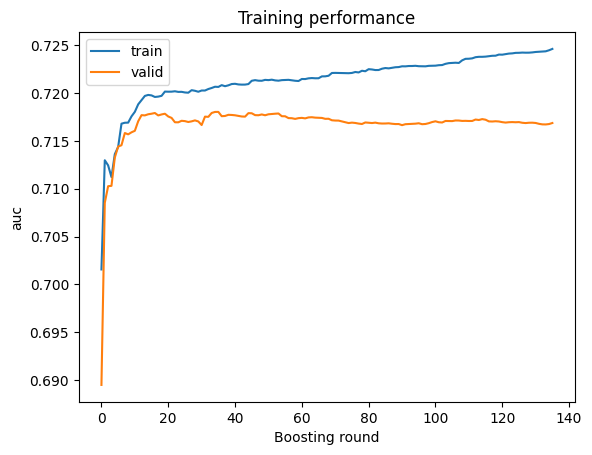

--------------------------------------------------------------------------------
Round 2 / 5
optuna score : 0.6936960042990463
valid score : 0.7184251060888541
--------------------------------------------------------------------------------


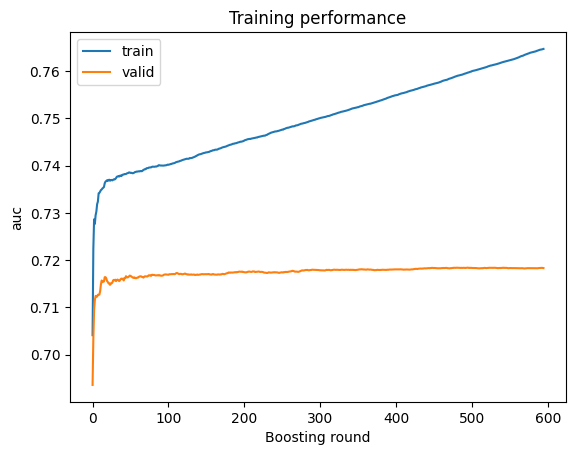

--------------------------------------------------------------------------------
Round 3 / 5
optuna score : 0.7067869117817088
valid score : 0.718851717624184
--------------------------------------------------------------------------------


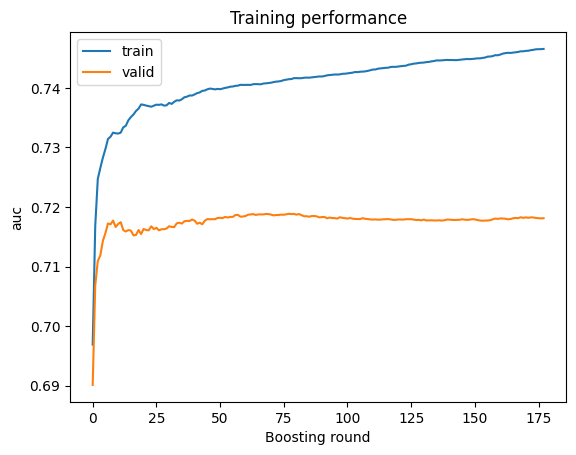

--------------------------------------------------------------------------------
Round 4 / 5
optuna score : 0.712043290374393
valid score : 0.7152234685568839
--------------------------------------------------------------------------------


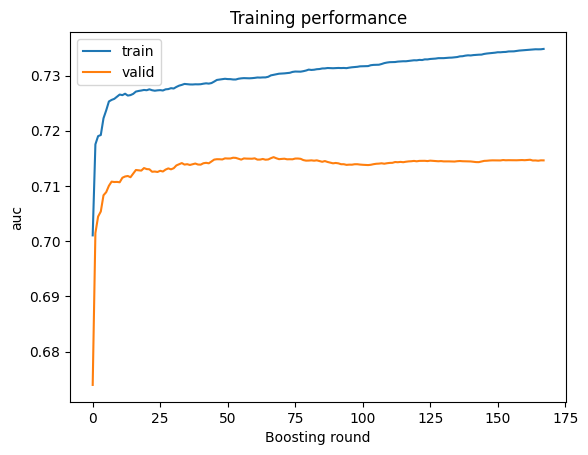

--------------------------------------------------------------------------------
Round 5 / 5
optuna score : 0.7100672586183516
valid score : 0.7144046000209203
--------------------------------------------------------------------------------


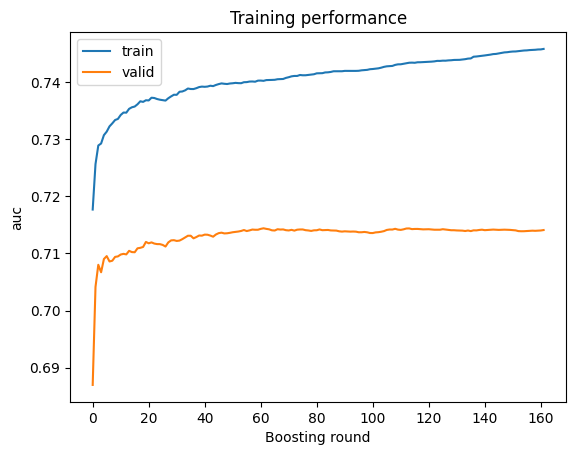

EC2
--------------------------------------------------------------------------------
Round 1 / 5
optuna score : 0.6113835178728226
valid score : 0.5931305811640742
--------------------------------------------------------------------------------


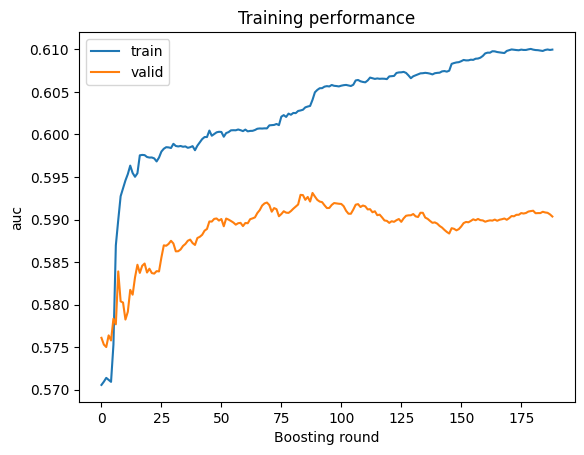

--------------------------------------------------------------------------------
Round 2 / 5
optuna score : 0.5912488874450241
valid score : 0.5748155640982967
--------------------------------------------------------------------------------


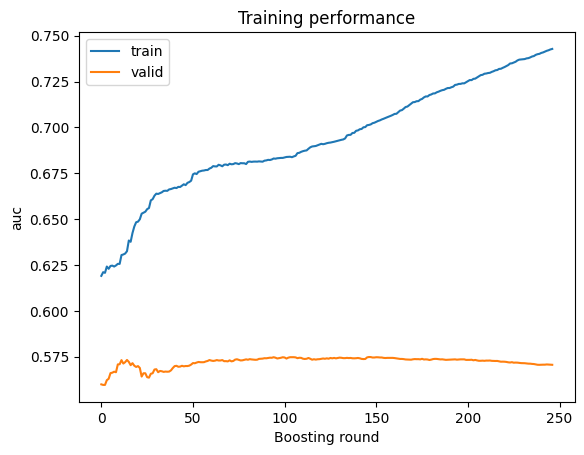

--------------------------------------------------------------------------------
Round 3 / 5
optuna score : 0.59313282835258
valid score : 0.5821769711586995
--------------------------------------------------------------------------------


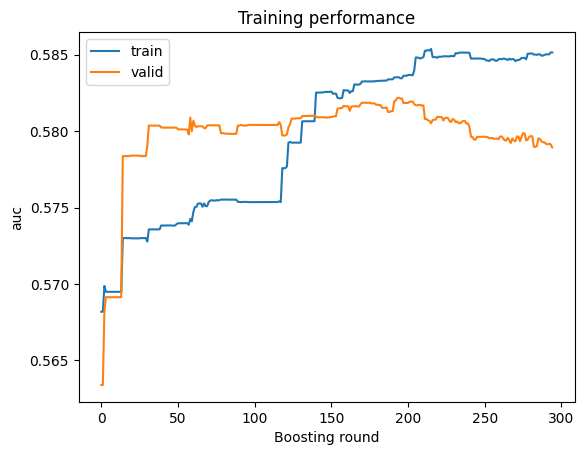

--------------------------------------------------------------------------------
Round 4 / 5
optuna score : 0.5779246646374565
valid score : 0.5861651246988593
--------------------------------------------------------------------------------


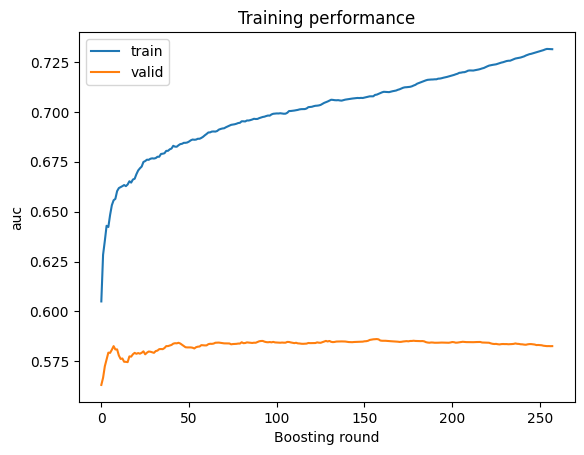

--------------------------------------------------------------------------------
Round 5 / 5
optuna score : 0.5979082386700756
valid score : 0.583428256889745
--------------------------------------------------------------------------------


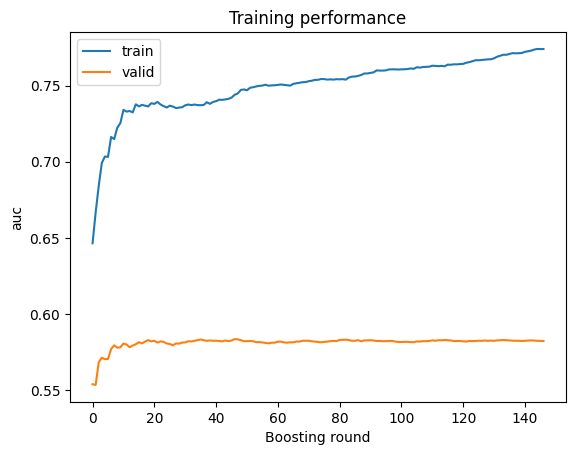

In [78]:
for target in target_ary:
    print(target)
    model_ary = dict_model[target]
    opt_ary = dict_opt[target]
    for i in range(len(model_ary)):
        print('-'*80)
        print(f'Round {i+1} / {len(model_ary)}')
        opt_score = opt_ary[i]['score']
        print(f'optuna score : {opt_score}')
        model = model_ary[i]['model']
        val_score = model.best_score['valid'][metric]
        print(f'valid score : {val_score}')
        print('-'*80)
        evaluation_results = model_ary[i]['evaluation_results']
        show_train_result(evaluation_results)

EC1
--------------------------------------------------------------------------------
Round 1 / 5
optuna score : 0.7132550527058433
valid score : 0.7180223376261119
--------------------------------------------------------------------------------


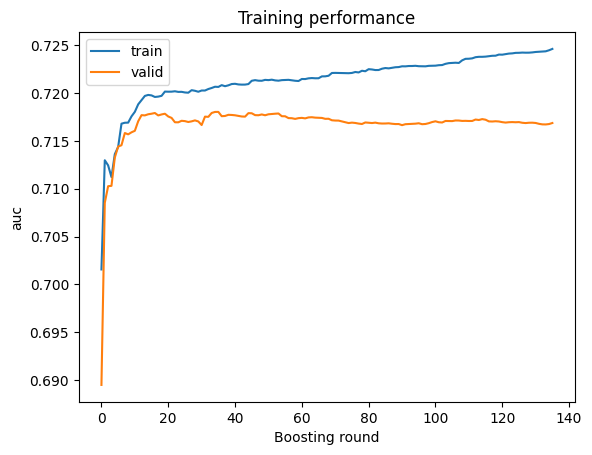

--------------------------------------------------------------------------------
Round 2 / 5
optuna score : 0.6936960042990463
valid score : 0.7184251060888541
--------------------------------------------------------------------------------


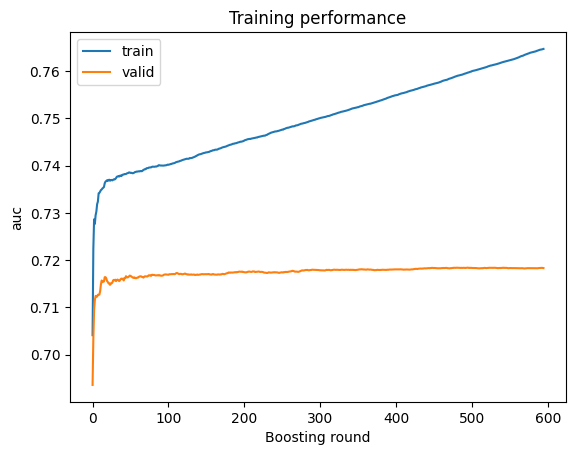

--------------------------------------------------------------------------------
Round 3 / 5
optuna score : 0.7067869117817088
valid score : 0.718851717624184
--------------------------------------------------------------------------------


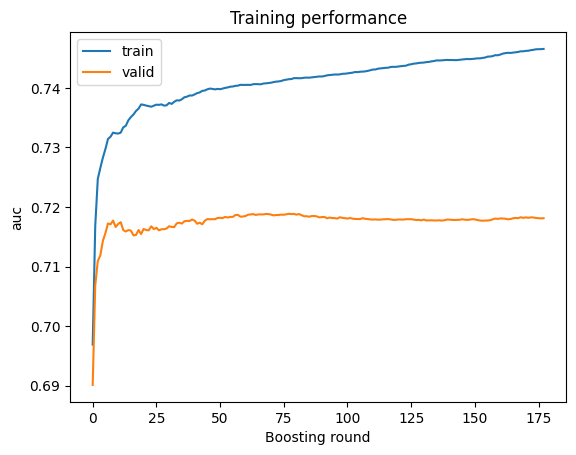

--------------------------------------------------------------------------------
Round 4 / 5
optuna score : 0.712043290374393
valid score : 0.7152234685568839
--------------------------------------------------------------------------------


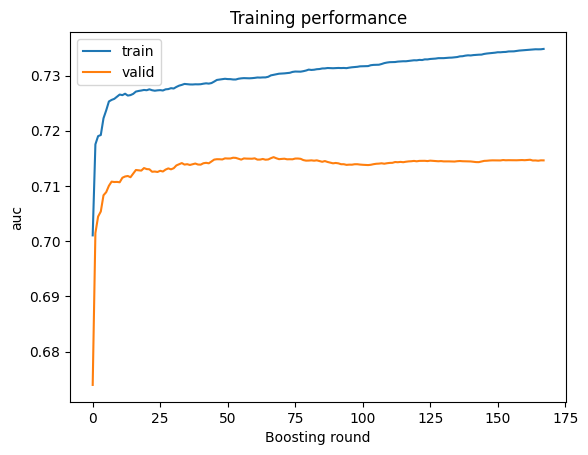

--------------------------------------------------------------------------------
Round 5 / 5
optuna score : 0.7100672586183516
valid score : 0.7144046000209203
--------------------------------------------------------------------------------


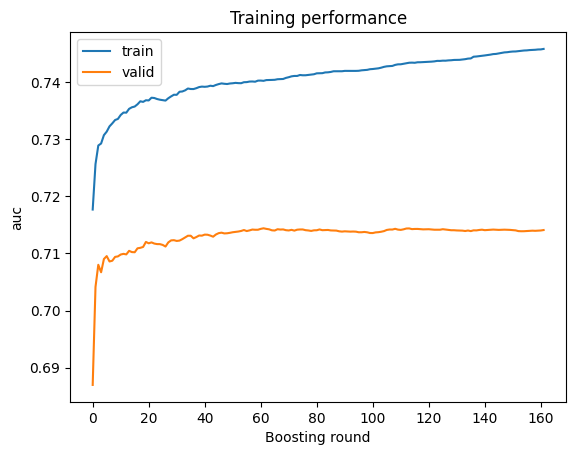

EC2
--------------------------------------------------------------------------------
Round 1 / 5
optuna score : 0.6113835178728226
valid score : 0.5931305811640742
--------------------------------------------------------------------------------


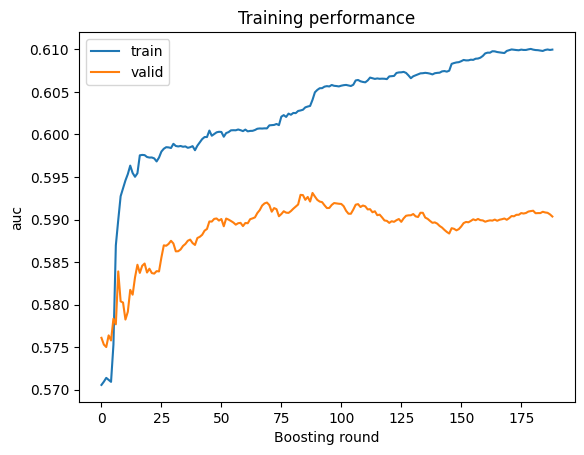

--------------------------------------------------------------------------------
Round 2 / 5
optuna score : 0.5912488874450241
valid score : 0.5748155640982967
--------------------------------------------------------------------------------


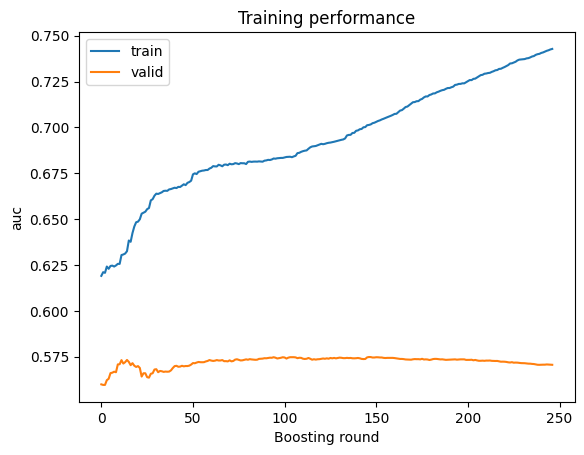

--------------------------------------------------------------------------------
Round 3 / 5
optuna score : 0.59313282835258
valid score : 0.5821769711586995
--------------------------------------------------------------------------------


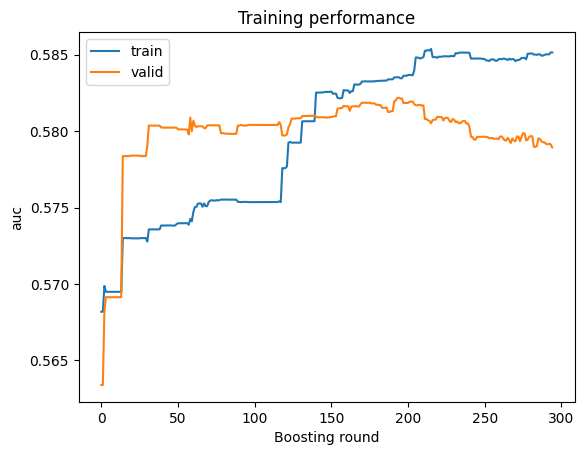

--------------------------------------------------------------------------------
Round 4 / 5
optuna score : 0.5779246646374565
valid score : 0.5861651246988593
--------------------------------------------------------------------------------


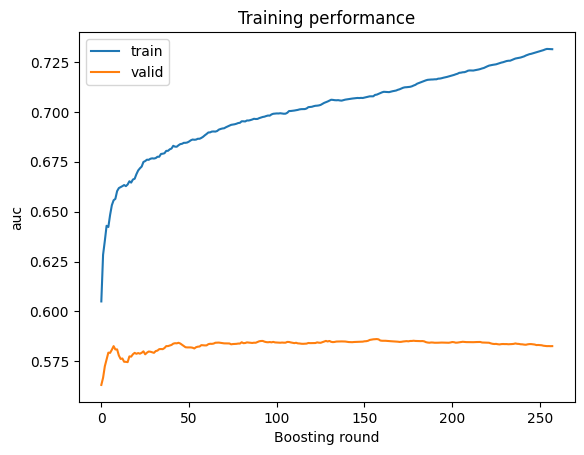

--------------------------------------------------------------------------------
Round 5 / 5
optuna score : 0.5979082386700756
valid score : 0.583428256889745
--------------------------------------------------------------------------------


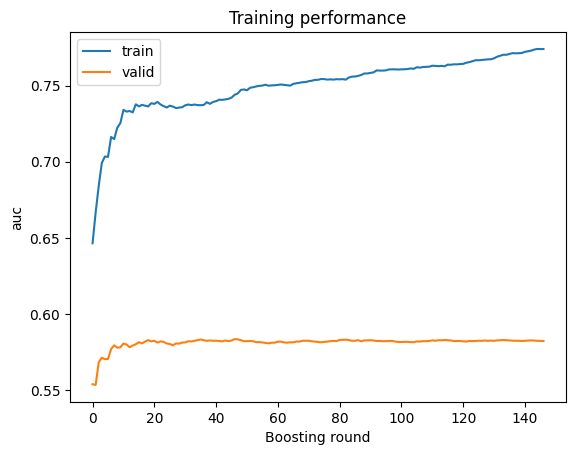

In [79]:
for target in target_ary:
    print(target)
    model_ary = dict_model[target]
    opt_ary = dict_opt[target]
    for i in range(len(model_ary)):
        print('-'*80)
        print(f'Round {i+1} / {len(model_ary)}')
        opt_score = opt_ary[i]['score']
        print(f'optuna score : {opt_score}')
        model = model_ary[i]['model']
        val_score = model.best_score['valid'][metric]
        print(f'valid score : {val_score}')
        print('-'*80)
        evaluation_results = model_ary[i]['evaluation_results']
        show_train_result(evaluation_results)

In [81]:
def show_roc_curve(X, model, target):
    for_verifi = model.predict(X)
    true = train[target]
    fpr, tpr, thresholds = roc_curve(true, for_verifi)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.title('ROC Curve')
    plt.show()

    return {'for_verifi' : for_verifi,
            'fpr' : fpr,
            'tpr' : tpr}

In [80]:
def show_cm(for_verifi, target):
    cm = confusion_matrix(train[target], np.round(for_verifi))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.show()

【Target : EC1】
--------------------------------------------------------------------------------
Round 1 / 5
Valid Score : 0.7180223376261119
--------------------------------------------------------------------------------


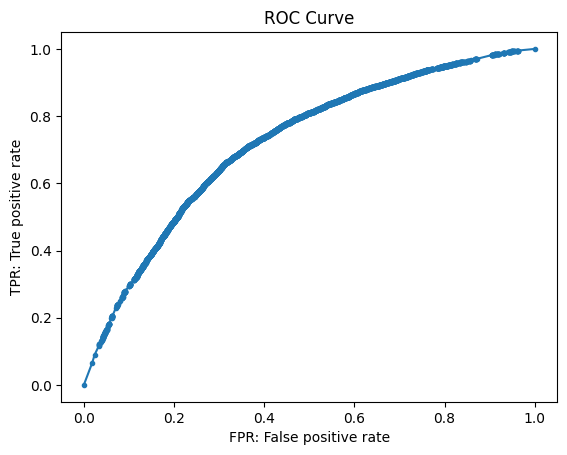

auc : 0.7201557984573697

Confusion Matrix


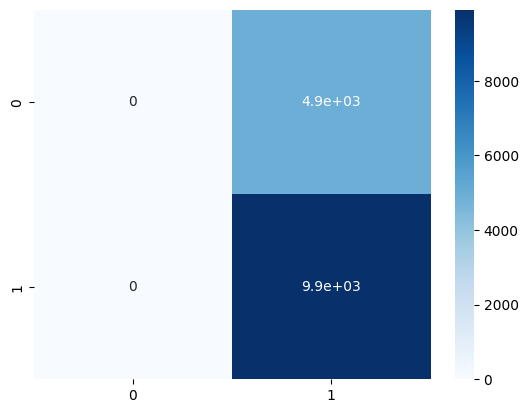

--------------------------------------------------------------------------------
Round 2 / 5
Valid Score : 0.7184251060888541
--------------------------------------------------------------------------------


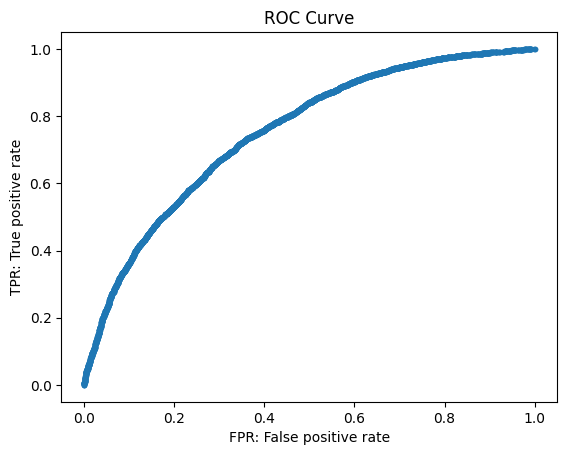

auc : 0.751590422966341

Confusion Matrix


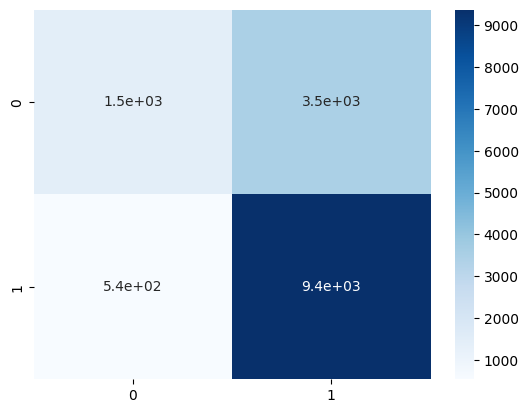

--------------------------------------------------------------------------------
Round 3 / 5
Valid Score : 0.718851717624184
--------------------------------------------------------------------------------


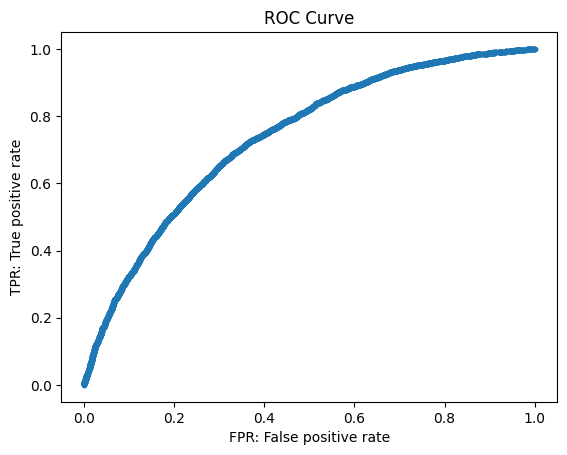

auc : 0.7369905667639238

Confusion Matrix


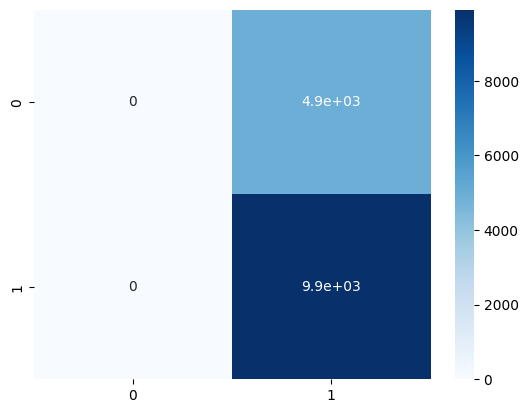

--------------------------------------------------------------------------------
Round 4 / 5
Valid Score : 0.7152234685568839
--------------------------------------------------------------------------------


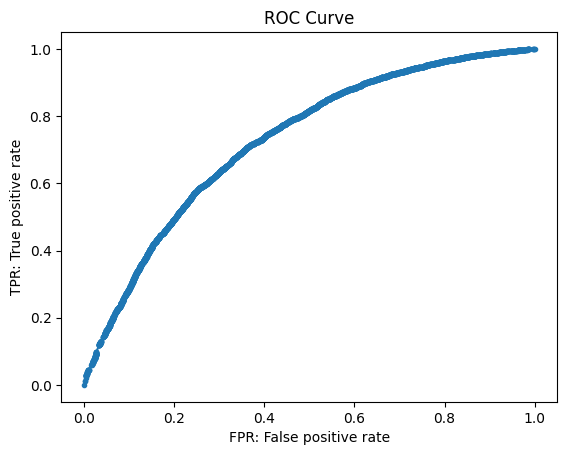

auc : 0.727143564607779

Confusion Matrix


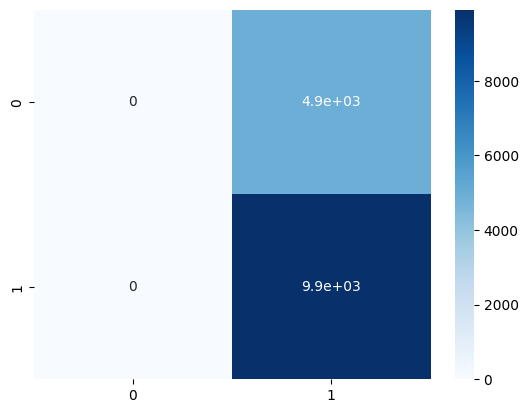

--------------------------------------------------------------------------------
Round 5 / 5
Valid Score : 0.7144046000209203
--------------------------------------------------------------------------------


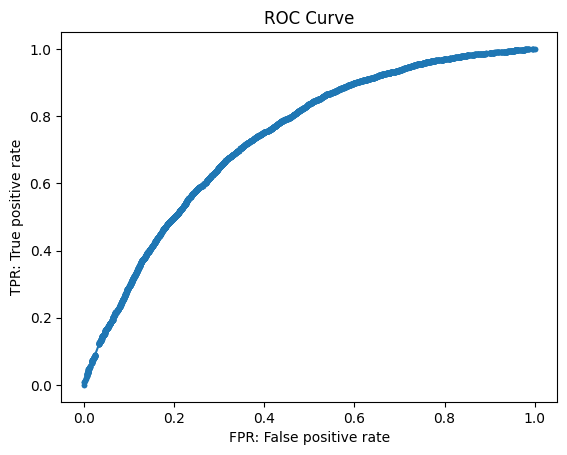

auc : 0.7351289879057716

Confusion Matrix


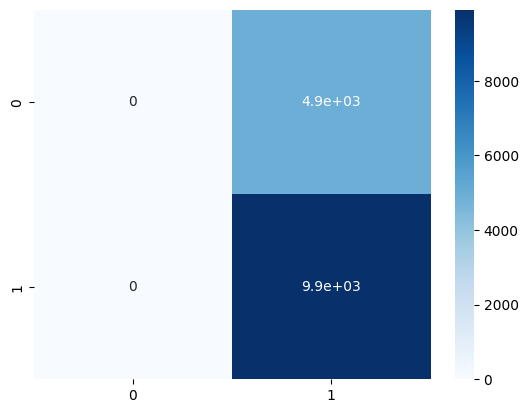

【Target : EC2】
--------------------------------------------------------------------------------
Round 1 / 5
Valid Score : 0.5931305811640742
--------------------------------------------------------------------------------


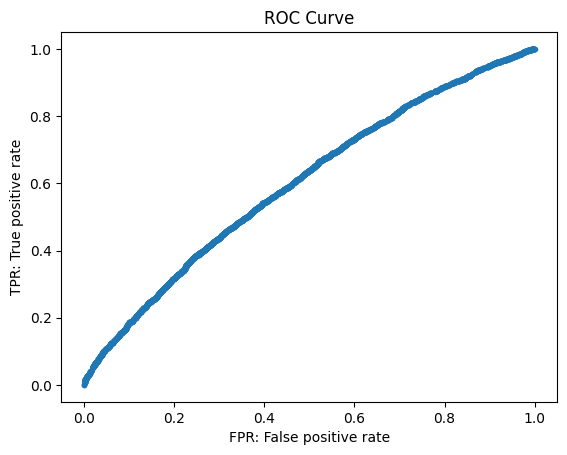

auc : 0.6018102581293999

Confusion Matrix


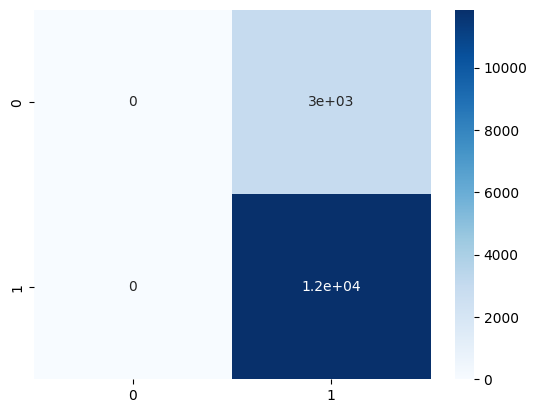

--------------------------------------------------------------------------------
Round 2 / 5
Valid Score : 0.5748155640982967
--------------------------------------------------------------------------------


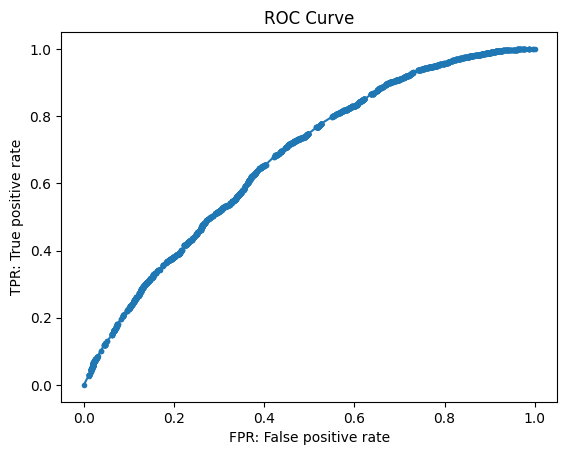

auc : 0.6753997239806677

Confusion Matrix


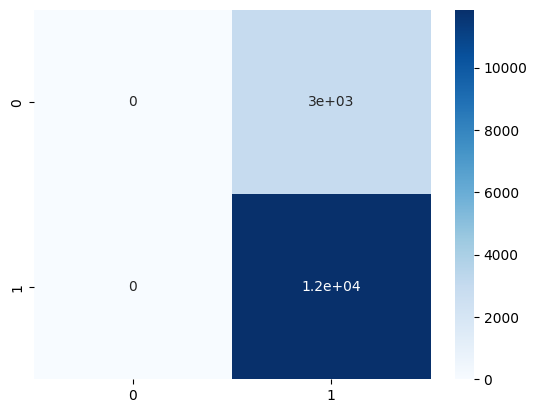

--------------------------------------------------------------------------------
Round 3 / 5
Valid Score : 0.5821769711586995
--------------------------------------------------------------------------------


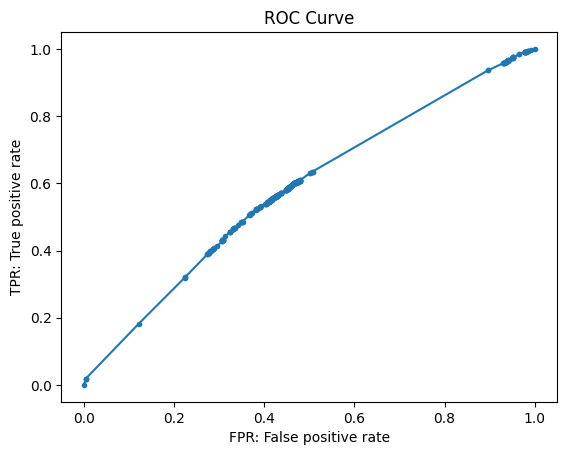

auc : 0.5832145973252338

Confusion Matrix


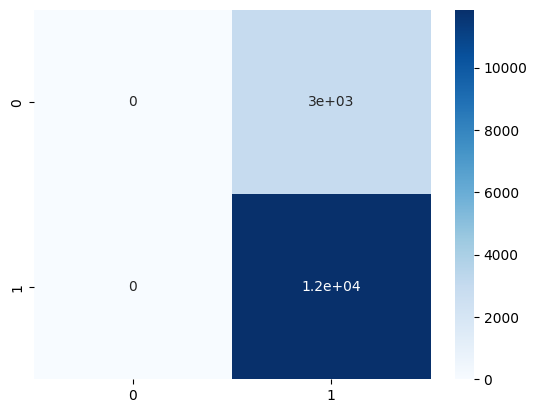

--------------------------------------------------------------------------------
Round 4 / 5
Valid Score : 0.5861651246988593
--------------------------------------------------------------------------------


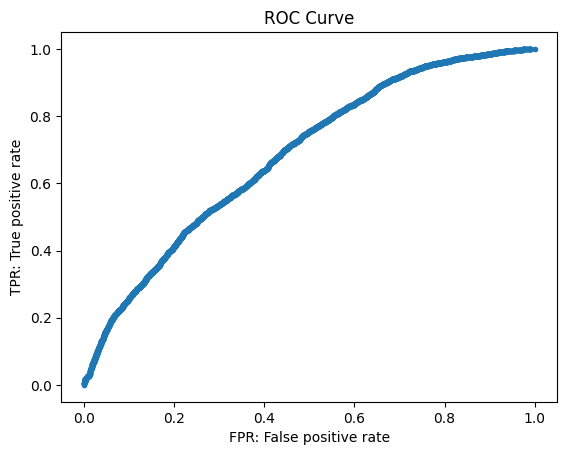

auc : 0.6834650394128516

Confusion Matrix


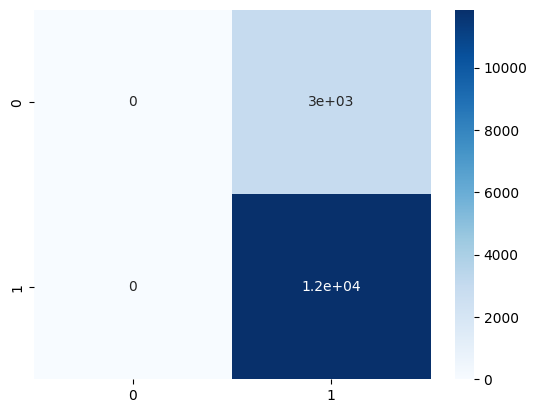

--------------------------------------------------------------------------------
Round 5 / 5
Valid Score : 0.583428256889745
--------------------------------------------------------------------------------


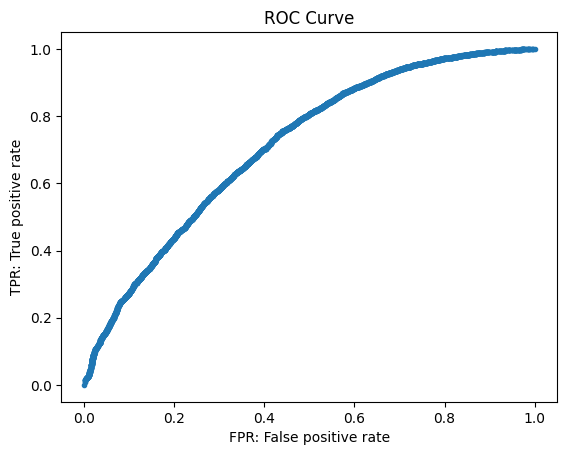

auc : 0.7116950643835382

Confusion Matrix


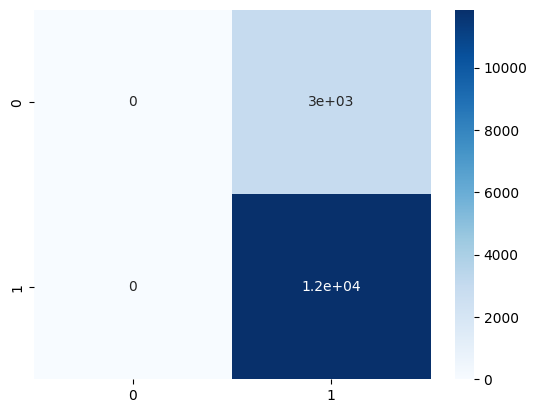

CPU times: user 6.69 s, sys: 1.73 s, total: 8.42 s
Wall time: 6.27 s


In [85]:
%%time

for target in target_ary:
    if order == 2 and target == 'EC2':
        X = train[np.append(np.array(test.columns), 'EC1')]
    else:
        X = train[test.columns]
    model_ary = dict_model[target]
    print('='*40)
    print(f'【Target : {target}】')
    print('='*40)
    for i in range(len(model_ary)):
        print('-'*80)
        print(f'Round {i+1} / {len(model_ary)}')
        model = model_ary[i]['model']
        val_score = model.best_score['valid'][metric]
        print(f'Valid Score : {val_score}')
        print('-'*80)

        # Rock curve
        obj = show_roc_curve(X, model, target)

        # Auc
        fpr = obj['fpr']
        tpr = obj['tpr']
#        print(f'fpr:{fpr},tpr{tpr}')
        acc = auc(fpr, tpr)
        model_ary[i]['auc'] = acc # model_aryにaucを保存
        print(f'auc : {acc}')
        print()

        # Confusion Matrix
        print('Confusion Matrix')
        for_verify = obj['for_verifi']
        show_cm(for_verify, target)

In [86]:
def get_pred(test, target, feat_ary):
    dict_fold = {}
    model_ary = dict_model[target]
    opt_ary = dict_opt[target]
    fold = []
    print()
    for i in range(len(model_ary)):
        model = model_ary[i]['model']
        auc = model_ary[i]['auc']
        if auc > 0.5:
            print(f'#{target}<br>')
            print(f'#auc : {auc}<br>')
            print(f'{opt_ary[i]}<br>')
            print()
            result = model.predict(test[feat_ary])
            fold.append(result)
    dict_fold[target] = fold
    print('-'*80)
    print(f'Result : {fold}')
    print('-'*80)
    return dict_fold

In [88]:
print('='*40)
print('【Selected optuna params and results】')
print('='*40)
dict_target = {}
for target in target_ary:
    if order == 2 and target == 'EC2':
        feat_ary = feat_ary_3
    else:
        feat_ary = test.columns
    dict_fold = get_pred(test, target, feat_ary)

    # 複数のモデルで予測した結果をアンサンブル
    # Ensemble predicted results
    fold = dict_fold[target]
    if len(fold) > 0:
        df_result = pd.DataFrame(fold).transpose().mean(axis=1)
        dict_target[target] = df_result

        if order == 2 and target == 'EC1':
            # EC1の予測結果を含めて再学習
            # Relearn including EC1 prediction results
            test[target] = np.array(df_result)
    else:
        print('No result')

【Selected optuna params and results】

#EC1<br>
#auc : 0.7201557984573697<br>
{'score': 0.7132550527058433, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 9.245852940295732, 'lambda_l2': 0.013020611473167807, 'num_leaves': 31, 'feature_fraction': 0.584, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100, 'num_iterations': 100, 'early_stopping_round': 100}}<br>

#EC1<br>
#auc : 0.751590422966341<br>
{'score': 0.6936960042990463, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 1.2320732132435812, 'lambda_l2': 4.8795803915243466e-05, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 100, 'early_stopping_round': 100}}<br>

#EC1<br>
#auc : 0.7369905667639238<br>
{'score': 0.7067869117817088, 'params': {'objective': 'binary', 'metric': 'auc', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, '

In [89]:
for target in target_ary:
    df_result = dict_target[target]
    sub[target] = df_result
sub

id       EC1       EC2
0     14838  0.613977  0.786480
1     14839  0.708568  0.811373
2     14840  0.699290  0.790787
3     14841  0.687588  0.808976
4     14842  0.709113  0.788052
...     ...       ...       ...
9888  24726  0.660115  0.789767
9889  24727  0.695977  0.807823
9890  24728  0.592486  0.814548
9891  24729  0.603498  0.815265
9892  24730  0.587056  0.814032

[9893 rows x 3 columns]

In [90]:
sub.to_csv('lgbm_optuna_5.csv', index=False)